# Unsupervised Learning Trading Strategy
1. Download SP500 stock prices data.
2. Calculate different technical indicators and features for each stock.
3. Aggregate on a monthly level and filter for each month by the top 100 stocks.
4. Calculate monthly returns for different time horizons to add to features.
5. Download Fama-French factors and calculate rolling factor betas for each stock.
6. For each month, fit a K-means clustering model to group similar assets based on their features.
7. For each month, select assets based on the cluster and form a portfolio based on Efficient Frontier max Sharpe ratio portfolio optimization.
8. Visualize the portfolio returns and compare them with the SP500 returns.

In [2]:
from statsmodels.regression.rolling import RollingOLS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as web
import yfinance as yf
import pandas_ta as ta
import warnings
import statsmodels.api as sm
import sklearn as skp
from sklearn.cluster import KMeans
warnings.filterwarnings("ignore")



In [4]:
#getting the table from wikipedia of the S&P 500 companies to current date
sp500 = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
sp500

Symbol            Security             GICS Sector  \
0      MMM                  3M             Industrials   
1      AOS         A. O. Smith             Industrials   
2      ABT              Abbott             Health Care   
3     ABBV              AbbVie             Health Care   
4      ACN           Accenture  Information Technology   
..     ...                 ...                     ...   
498    XYL          Xylem Inc.             Industrials   
499    YUM         Yum! Brands  Consumer Discretionary   
500   ZBRA  Zebra Technologies  Information Technology   
501    ZBH       Zimmer Biomet             Health Care   
502    ZTS              Zoetis             Health Care   

                                GICS Sub-Industry    Headquarters Location  \
0                        Industrial Conglomerates    Saint Paul, Minnesota   
1                               Building Products     Milwaukee, Wisconsin   
2                           Health Care Equipment  North Chicago, Illinois   
3                                   Biotechnology  North Chicago, Illinois   
4                  IT Consulting & Other Services          Dublin, Ireland   
..                                            ...                      ...   
498  Industrial Machinery & Supplies & Components   White Plains, New York   
499                                   Restaurants     Louisville, Kentucky   
500            Electronic Equipment & Instruments   Lincolnshire, Illinois   
501                         Health Care Equipment          Warsaw, Indiana   
502                               Pharmaceuticals   Parsippany, New Jersey   

     Date added      CIK      Founded  
0    1957-03-04    66740         1902  
1    2017-07-26    91142         1916  
2    1957-03-04     1800         1888  
3    2012-12-31  1551152  2013 (1888)  
4    2011-07-06  1467373         1989  
..          ...      ...          ...  
498  2011-11-01  1524472         2011  
499  1997-10-06  1041061         1997  
500  2019-12-23   877212         1969  
501  2001-08-07  1136869         1927  
502  2013-06-21  1555280         1952  

[503 rows x 8 columns]

In [8]:
#Creating a unique list of all the symbols in the S&P 500
symbols_list = sp500['Symbol'].unique().tolist() 
#specifying the end data of the dataset
end_date = "2024-01-31"
#The start of the year is going to be 8 year before the end date
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

In [9]:
print(end_date)
print(start_date)

2024-01-31
2016-02-02 00:00:00


In [10]:
#This will download the S&P500 consistuents between the start and end dates.
#replacing dot with hyphen
symbols_list = [symbol.replace('.', '-') for symbol in symbols_list]  
df = yf.download(tickers = symbols_list,start = start_date,end = end_date)
#change the matrix so it is more suitable and data can be accessed more easily and efficiently 
df = df.stack()
df

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['SOLV', 'SW', 'GEV']: YFChartError("%ticker%: Data doesn't exist for startDate = 1454389200, endDate = 1706677200")


Price               Adj Close       Close        High         Low        Open  \
Date       Ticker                                                               
2016-02-02 A        34.621189   37.070000   37.549999   36.950001   37.180000   
           AAL      35.387547   37.029999   38.970001   37.000000   38.830002   
           AAPL     21.446991   23.620001   24.010000   23.570000   23.855000   
           ABBV     37.524925   53.950001   54.779999   53.320000   53.639999   
           ABT      32.324383   37.880001   38.730000   37.820000   38.000000   
...                       ...         ...         ...         ...         ...   
2024-01-30 XYL     113.123207  113.750000  114.050003  112.190002  112.919998   
           YUM     129.334000  130.619995  131.220001  129.580002  130.360001   
           ZBH     121.869461  122.370003  123.199997  121.900002  122.870003   
           ZBRA    250.910004  250.910004  255.979996  250.559998  255.979996   
           ZTS     190.432755  191.429993  193.509995  190.440002  192.869995   

Price                   Volume  
Date       Ticker               
2016-02-02 A         1742300.0  
           AAL      12401400.0  
           AAPL    149428800.0  
           ABBV      7918300.0  
           ABT       9632400.0  
...                        ...  
2024-01-30 XYL        960800.0  
           YUM       1421500.0  
           ZBH       1448600.0  
           ZBRA       302100.0  
           ZTS       1607500.0  

[987856 rows x 6 columns]

In [11]:
#making all the column and index names lowercase
df.index.names = ["date","ticker"]
df.columns = df.columns.str.lower()
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-02-02 A        34.621189   37.070000   37.549999   36.950001   37.180000   
           AAL      35.387547   37.029999   38.970001   37.000000   38.830002   
           AAPL     21.446991   23.620001   24.010000   23.570000   23.855000   
           ABBV     37.524925   53.950001   54.779999   53.320000   53.639999   
           ABT      32.324383   37.880001   38.730000   37.820000   38.000000   
...                       ...         ...         ...         ...         ...   
2024-01-30 XYL     113.123207  113.750000  114.050003  112.190002  112.919998   
           YUM     129.334000  130.619995  131.220001  129.580002  130.360001   
           ZBH     121.869461  122.370003  123.199997  121.900002  122.870003   
           ZBRA    250.910004  250.910004  255.979996  250.559998  255.979996   
           ZTS     190.432755  191.429993  193.509995  190.440002  192.869995   

Price                   volume  
date       ticker               
2016-02-02 A         1742300.0  
           AAL      12401400.0  
           AAPL    149428800.0  
           ABBV      7918300.0  
           ABT       9632400.0  
...                        ...  
2024-01-30 XYL        960800.0  
           YUM       1421500.0  
           ZBH       1448600.0  
           ZBRA       302100.0  
           ZTS       1607500.0  

[987856 rows x 6 columns]

## Calculate Features and technical indicators of stock 
1. Garman-Klass Volatility 
2. RSI
3. Boilinger Bands
4. ATR
5. MACD
6. Dollar Volume

### Garman-Klass Volatility Formula

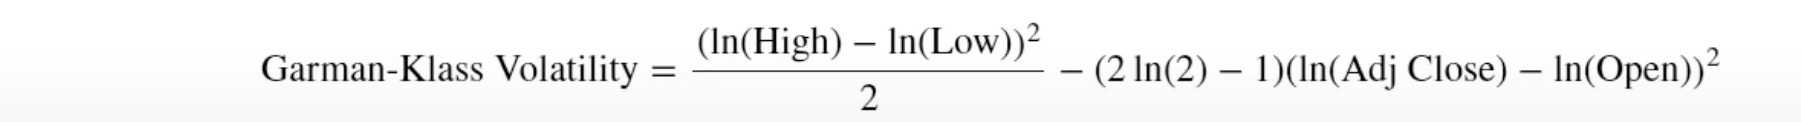

In [332]:
%pip install ta

python(25795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
433745.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=e439fb56fa532aaa155a0e2ac4014f0eceb96043e4d37efa3540e95f1f485a82
  Stored in directory: /Users/adi/Library/Caches/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta

[notice] A new release of pip is available: 24.1.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import pandas as pd
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import RSIIndicator
from ta.trend import MACD

# multi-level index with columns 'high', 'low', 'adj close', 'close', 'open', and 'volume'

# Garman-Klass Volatility Formula
df["garman_klass_vol"] = ((np.log(df["high"]) - np.log(df["low"]))**2) / 2 - ((2 * np.log(2) - 1) * (np.log(df["adj close"]) - np.log(df["open"]))**2) / 2

# RSI Calculation
df["rsi"] = df.groupby(level=1, group_keys=False)["adj close"].transform(lambda x: RSIIndicator(close=x, window=20).rsi())


# Bollinger Bands Calculation
def compute_bbands(stock_data):
    bb = BollingerBands(close=stock_data["adj close"], window=20)
    stock_data["bb_low"] = bb.bollinger_lband()
    stock_data["bb_mid"] = bb.bollinger_mavg()
    stock_data["bb_high"] = bb.bollinger_hband()
    return stock_data

df = df.groupby(level=1, group_keys=False).apply(compute_bbands)


# ATR function requires three columns as input
def compute_atr(stock_data):
    atr = AverageTrueRange(high=stock_data["high"], low=stock_data["low"], close=stock_data["close"], window=14).average_true_range()
    if atr.isnull().any():
        print("ATR calculation resulted in NaNs")
    return atr.sub(atr.mean()).div(atr.std())

df["atr"] = df.groupby(level=1, group_keys=False).apply(compute_atr)


# Calculate MACD
def compute_macd(close):
    macd = MACD(close=close, window_slow=26, window_fast=12, window_sign=9).macd()
    if macd.isnull().any():
        print("MACD calculation resulted in NaNs")
    return macd.sub(macd.mean()).div(macd.std())

df["macd"] = df.groupby(level=1, group_keys=False)["adj close"].apply(compute_macd)


# Calculate dollar_volume
df["dollar_volume"] = (df["adj close"] * df["volume"]) / 1e6


# Display the resulting DataFrame
df

MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculation resulted in NaNs
MACD calculati

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-02-02 A        34.621189   37.070000   37.549999   36.950001   37.180000   
           AAL      35.387547   37.029999   38.970001   37.000000   38.830002   
           AAPL     21.446991   23.620001   24.010000   23.570000   23.855000   
           ABBV     37.524925   53.950001   54.779999   53.320000   53.639999   
           ABT      32.324383   37.880001   38.730000   37.820000   38.000000   
...                       ...         ...         ...         ...         ...   
2024-01-30 XYL     113.123207  113.750000  114.050003  112.190002  112.919998   
           YUM     129.334000  130.619995  131.220001  129.580002  130.360001   
           ZBH     121.869461  122.370003  123.199997  121.900002  122.870003   
           ZBRA    250.910004  250.910004  255.979996  250.559998  255.979996   
           ZTS     190.432755  191.429993  193.509995  190.440002  192.869995   

Price                   volume  garman_klass_vol        rsi      bb_low  \
date       ticker                                                         
2016-02-02 A         1742300.0         -0.000852        NaN         NaN   
           AAL      12401400.0         -0.000319        NaN         NaN   
           AAPL    149428800.0         -0.002016        NaN         NaN   
           ABBV      7918300.0         -0.024292        NaN         NaN   
           ABT       9632400.0         -0.004772        NaN         NaN   
...                        ...               ...        ...         ...   
2024-01-30 XYL        960800.0          0.000135  61.036410  109.647151   
           YUM       1421500.0          0.000067  54.698944  126.234996   
           ZBH       1448600.0          0.000043  57.938603  119.353587   
           ZBRA       302100.0          0.000152  50.189867  241.607746   
           ZTS       1607500.0          0.000097  52.429444  184.699426   

Price                  bb_mid     bb_high       atr      macd  dollar_volume  
date       ticker                                                             
2016-02-02 A              NaN         NaN -1.834171       NaN      60.320498  
           AAL            NaN         NaN -2.725402       NaN     438.855120  
           AAPL           NaN         NaN -1.393132       NaN    3204.798124  
           ABBV           NaN         NaN -2.431445       NaN     297.133615  
           ABT            NaN         NaN -1.924588       NaN     311.361385  
...                       ...         ...       ...       ...            ...  
2024-01-30 XYL     111.658822  113.670494 -0.196214  0.482256     108.688777  
           YUM     128.409691  130.584386  0.038029  0.176896     183.848280  
           ZBH     121.488519  123.623451 -0.694162  0.356165     176.540101  
           ZBRA    253.253000  264.898253  0.009226 -0.035609      75.799912  
           ZTS     191.557238  198.415050  0.646917 -0.230845     306.120653  

[987856 rows x 14 columns]

## Aggregate to monthly level and filter the top 150 most liquid stocks for each month

In [15]:
#Identify columns to convert and store it as a list
convert_columns = [c for c in df.columns.get_level_values(0).unique() if c not in ["dollar_volume", "high", "low", "close", "volume", "open"]]
convert_columns

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [16]:
#unstacking will give the dollar_volume of a given company over a specificed period of time if not specificed for each corresponding date column value.
#here we are finding the monthly average then restack the data and add it to the dataframe as a column with the monthly averages. And we take the last adjusted value for technical indicators.
# Unstack and resample dollar_volume separately
dollar_volume_resampled = df["dollar_volume"].unstack("ticker").resample('M').mean().stack("ticker").to_frame("dollar_volume")
# Unstack and resample other columns
other_columns_resampled = df[convert_columns].unstack().resample("M").last().stack()
#Combine the results
data = pd.concat([dollar_volume_resampled, other_columns_resampled], axis=1).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-03-31 A           61.798334   37.217545         -0.000950  58.526824   
           AAL        298.909255   39.297951         -0.000431  51.729038   
           AAPL      3226.828088   24.875013         -0.001803  72.694325   
           ABBV       251.504829   39.729824         -0.025150  55.528874   
           ABT        226.906117   35.695057         -0.004529  69.388962   
...                          ...         ...               ...        ...   
2024-01-31 ABNB       608.209116  149.440002          0.000113  62.968005   
           CEG        176.788805  121.455276          0.000088  58.510165   
           GEHC       194.034098   73.946541          0.000178  50.450417   
           KVUE       341.192682   20.440403         -0.000035  49.665314   
           VLTO       102.759538   78.178879          0.000192  52.892521   

                       bb_low      bb_mid     bb_high       atr      macd  
date       ticker                                                          
2016-03-31 A        35.426929   36.668851   37.910773 -1.108641  0.113175  
           AAL      38.637768   40.151281   41.664794  0.227958  0.507396  
           AAPL     22.696370   23.879922   25.063474 -1.091906  0.010105  
           ABBV     38.336047   39.244671   40.153296 -0.900060 -0.059467  
           ABT      32.849770   34.382627   35.915484 -1.110609  0.301385  
...                       ...         ...         ...       ...       ...  
2024-01-31 ABNB    129.458910  139.994998  150.531086 -0.775295  0.702088  
           CEG     109.553548  115.783117  122.012685  0.236403 -0.012486  
           GEHC     71.636442   74.828361   78.020281 -0.389304 -0.427072  
           KVUE     19.852910   20.710722   21.568533 -0.757652  0.483598  
           VLTO     74.141097   77.043571   79.946044 -0.125142 -0.533851  

[46640 rows x 9 columns]

#### Calculating the 5-year rolling average volume for each stock before filtering

In [17]:
#Calculating rolling mean for all dollar volume over the 5 year period so data.loc is very important
data["dollar_volume"] = (data.loc[:,"dollar_volume"].unstack("ticker").rolling(window=5*12, min_periods=1).mean().stack())
#Rank by dollar volume
data["dollar_volume_rank"] = data.groupby(level=0)["dollar_volume"].rank(ascending=False)
#filter based on top 150 dollar_volume
filtered_data = data[data["dollar_volume_rank"] < 150]
data = filtered_data
#removing the dollar_volume and dollar_volume_ranked columns since it is not needed after filtering the top 150 comapnies
data = data.drop(["dollar_volume", "dollar_volume_rank"], axis=1)
data

adj close  garman_klass_vol        rsi      bb_low  \
date       ticker                                                        
2016-03-31 AAL      39.297951         -0.000431  51.729038   38.637768   
           AAPL     24.875013         -0.001803  72.694325   22.696370   
           ABBV     39.729824         -0.025150  55.528874   38.336047   
           ABT      35.695057         -0.004529  69.388962   32.849770   
           ACN     100.344002         -0.003598  77.133394   86.088489   
...                       ...               ...        ...         ...   
2024-01-31 MRNA    102.470001          0.000188  55.479148   95.789434   
           UBER     66.839996          0.000241  67.109316   56.722615   
           CRWD    301.350006          0.000098  71.050870  240.840662   
           ABNB    149.440002          0.000113  62.968005  129.458910   
           KVUE     20.440403         -0.000035  49.665314   19.852910   

                       bb_mid     bb_high       atr      macd  
date       ticker                                              
2016-03-31 AAL      40.151281   41.664794  0.227958  0.507396  
           AAPL     23.879922   25.063474 -1.091906  0.010105  
           ABBV     39.244671   40.153296 -0.900060 -0.059467  
           ABT      34.382627   35.915484 -1.110609  0.301385  
           ACN      93.871193  101.653898 -0.890005  0.567802  
...                       ...         ...       ...       ...  
2024-01-31 MRNA    105.231250  114.673065 -0.461434  0.194584  
           UBER     62.756500   68.790385 -0.257810  1.281652  
           CRWD    279.376499  317.912337  0.328222  1.973549  
           ABNB    139.994998  150.531086 -0.775295  0.702088  
           KVUE     20.710722   21.568533 -0.757652  0.483598  

[14155 rows x 8 columns]

## Calculate Monthly returns in different time horizons as features

To capture time series dynamics that reflect momentum patterned for example. Can compute historical returns using the method pct_change(lag),that is,returns over various monthly periods as identified by lags. This can help capture the momentum patterns  

In [18]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    # Different month levels for return to track momentum over time of each stock
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f"return_{lag}m"] = (
            df["adj close"]
            .pct_change(lag)
            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1 - outlier_cutoff)))
            .add(1)
            .pow(1 / lag)
            .sub(1)
        )
    return df

# Apply the calculate_returns function
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi      bb_low  \
date       ticker                                                        
2017-03-31 AAL      40.966816         -0.000095  44.018291   38.472709   
           AAPL     33.480961         -0.000924  72.900304   31.998916   
           ABBV     47.054874         -0.021034  58.182222   46.093212   
           ABT      38.856293         -0.003294  52.441450   38.736707   
           ACN     106.346481         -0.003035  45.957901  105.296466   
...                       ...               ...        ...         ...   
2024-01-31 XOM     103.047531          0.000353  59.664537   93.533540   
           MRNA    102.470001          0.000188  55.479148   95.789434   
           UBER     66.839996          0.000241  67.109316   56.722615   
           CRWD    301.350006          0.000098  71.050870  240.840662   
           ABNB    149.440002          0.000113  62.968005  129.458910   

                       bb_mid     bb_high       atr      macd  return_1m  \
date       ticker                                                          
2017-03-31 AAL      41.089807   43.706904  0.463611 -0.926235  -0.087575   
           AAPL     32.810690   33.622463 -1.142533 -0.014057   0.048690   
           ABBV     47.222040   48.350869 -1.580403  0.079358   0.053687   
           ABT      39.362883   39.989059 -1.331816 -0.139214  -0.014862   
           ACN     109.042842  112.789219 -0.962991 -0.306927  -0.021388   
...                       ...         ...       ...       ...        ...   
2024-01-31 XOM      98.491723  103.449906  0.243747  0.107849   0.048710   
           MRNA    105.231250  114.673065 -0.461434  0.194584   0.030367   
           UBER     62.756500   68.790385 -0.257810  1.281652   0.085594   
           CRWD    279.376499  317.912337  0.328222  1.973549   0.180284   
           ABNB    139.994998  150.531086 -0.775295  0.702088   0.097694   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-03-31 AAL     -0.021195  -0.031662   0.025180   0.046528    0.003472  
           AAPL     0.090404   0.075995   0.042385   0.048020    0.025068  
           ABBV     0.032606   0.016739   0.008674   0.008830    0.014201  
           ABT      0.031117   0.051827   0.010335   0.015779    0.007097  
           ACN      0.026051   0.007766  -0.001428   0.007460    0.004853  
...                      ...        ...        ...        ...         ...  
2024-01-31 XOM      0.010216  -0.000130  -0.000878  -0.010514   -0.005615  
           MRNA     0.148386   0.104936  -0.022775  -0.028470   -0.044102  
           UBER     0.088819   0.155890   0.051470   0.086176    0.066321  
           CRWD     0.127640   0.194596   0.109374   0.107674    0.091058  
           ABNB     0.087584   0.081035  -0.003035   0.024991    0.025005  

[11892 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
1. We will be usin Fama-French Factors to estimate the exposure of stocks to common risk factors using linear regression
2. The five Fama-French factors are:
    1. Market Risk Premium (MKT): Measures the excess return of the market over the risk-free rate, capturing the overall market risk.
    2. Size (SMB - Small Minus Big): Represents the difference in returns between small-cap and large-cap stocks, capturing the size effect.
    3. Value (HML - High Minus Low): Reflects the difference in returns between value stocks (high book-to-market ratio) and growth stocks (low book-to-market ratio), capturing the value effect.
    4. Profitability (RMW - Robust Minus Weak): Measures the difference in returns between firms with robust and weak profitability, capturing the profitability effect.
    5. Investment (CMA - Conservative Minus Aggressive): Represents the difference in returns between firms that invest conservatively and those that invest aggressively, capturing the investment effect.
3. we can access historical factor returns using the pandas_datareader and estimate historical exposure using RollingOLS.

In [19]:
#This datareader fuction reads data from various online sources and the percise dataset name is provide to fetch the information from. 
#Index 0 is used to values of the first key in the dictionary which are the values of the factors by month. index 1 is by year which we don't need.
factor_data = web.DataReader("F-F_Research_Data_5_Factors_2x3","famafrench",start = "2010")[0] 
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample("M").last().div(100)
factor_data.index.name = "date"
factor_data = factor_data.join(data["return_1m"]).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA      RF  return_1m
date       ticker                                                           
2017-03-31 AAL     0.0017  0.0074 -0.0335  0.0061 -0.0094  0.0003  -0.087575
           AAPL    0.0017  0.0074 -0.0335  0.0061 -0.0094  0.0003   0.048690
           ABBV    0.0017  0.0074 -0.0335  0.0061 -0.0094  0.0003   0.053687
           ABT     0.0017  0.0074 -0.0335  0.0061 -0.0094  0.0003  -0.014862
           ACN     0.0017  0.0074 -0.0335  0.0061 -0.0094  0.0003  -0.021388
...                   ...     ...     ...     ...     ...     ...        ...
2024-01-31 VRTX    0.0070 -0.0574 -0.0238  0.0069 -0.0095  0.0047   0.096316
           VZ      0.0070 -0.0574 -0.0238  0.0069 -0.0095  0.0047   0.127970
           WFC     0.0070 -0.0574 -0.0238  0.0069 -0.0095  0.0047   0.040024
           WMT     0.0070 -0.0574 -0.0238  0.0069 -0.0095  0.0047   0.050365
           XOM     0.0070 -0.0574 -0.0238  0.0069 -0.0095  0.0047   0.048710

[11892 rows x 7 columns]

#### Filter out stocks that have less than 10 months of data
This step is important since I are going to use rolling window for the regression of around 2 years (24 months) and stocks with insufficient data will break the fuction 

In [20]:
checker = factor_data.groupby(level = 1).size()
valid_stocks = checker[checker >= 10]
factor_data = factor_data[factor_data.index.get_level_values("ticker").isin(valid_stocks.index)]
#Now that I am done removing the stocks which have data I can create the 2 year rolling factors betas by defining a function 
#endog is the dependent variable for the regression (y axis) and the exog is the independent variables that I specify as all the other variables except the dependent variable(return_1m).
#To achieve this we create a constant for all the columns except return_1m which we can drop later so we don't add redundant data to the main table. 
#window set the size of the rolling window for the regression and we need to make sure it take into account window can take data point less than 24
#min_nobs is the minimum number of observations required to perform the regression to ensure there are enough data points to estimate all the coefficients and constant terms.
#params_only indicates only the parameter cofficient in regression model are needed so this makes computation faster.
#Extracts the regression parameters from the fitted model 

def compute_rolling_ols(x):
    min_window = min(24, x.shape[0])
    rolling_model = RollingOLS(endog=x["return_1m"], exog=sm.add_constant(x.drop("return_1m", axis=1)), window=min_window, min_nobs=len(x.columns) + 1)
    fitted_model = rolling_model.fit(params_only=True)
    params = fitted_model.params.drop("const", axis=1, errors='ignore')
    return params

betas = factor_data.groupby(level="ticker", group_keys=False).apply(compute_rolling_ols)

betas

Mkt-RF       SMB       HML       RMW       CMA         RF
date       ticker                                                             
2017-03-31 AAL          NaN       NaN       NaN       NaN       NaN        NaN
           AAPL         NaN       NaN       NaN       NaN       NaN        NaN
           ABBV         NaN       NaN       NaN       NaN       NaN        NaN
           ABT          NaN       NaN       NaN       NaN       NaN        NaN
           ACN          NaN       NaN       NaN       NaN       NaN        NaN
...                     ...       ...       ...       ...       ...        ...
2024-01-31 VRTX    0.408110  0.341360 -0.860232  0.156479  1.042126   2.648722
           VZ      0.426310 -0.912742  0.542658  0.014722 -0.144564   7.272667
           WFC     1.047635  0.371788  1.573909 -0.217215 -1.205023   5.012580
           WMT     0.527837  0.277508 -0.948646  0.678766  0.944093   2.103905
           XOM     0.919681 -0.430927  0.790368  0.672640  0.152868 -17.095918

[11839 rows x 6 columns]

In [21]:

month_adjust = betas.groupby("ticker").shift()

data = data.join(month_adjust, on=['date', 'ticker'], how='left')
data

adj close  garman_klass_vol        rsi      bb_low  \
date       ticker                                                        
2017-03-31 AAL      40.966816         -0.000095  44.018291   38.472709   
           AAPL     33.480961         -0.000924  72.900304   31.998916   
           ABBV     47.054874         -0.021034  58.182222   46.093212   
           ABT      38.856293         -0.003294  52.441450   38.736707   
           ACN     106.346481         -0.003035  45.957901  105.296466   
...                       ...               ...        ...         ...   
2024-01-31 XOM     103.047531          0.000353  59.664537   93.533540   
           MRNA    102.470001          0.000188  55.479148   95.789434   
           UBER     66.839996          0.000241  67.109316   56.722615   
           CRWD    301.350006          0.000098  71.050870  240.840662   
           ABNB    149.440002          0.000113  62.968005  129.458910   

                       bb_mid     bb_high       atr      macd  return_1m  \
date       ticker                                                          
2017-03-31 AAL      41.089807   43.706904  0.463611 -0.926235  -0.087575   
           AAPL     32.810690   33.622463 -1.142533 -0.014057   0.048690   
           ABBV     47.222040   48.350869 -1.580403  0.079358   0.053687   
           ABT      39.362883   39.989059 -1.331816 -0.139214  -0.014862   
           ACN     109.042842  112.789219 -0.962991 -0.306927  -0.021388   
...                       ...         ...       ...       ...        ...   
2024-01-31 XOM      98.491723  103.449906  0.243747  0.107849   0.048710   
           MRNA    105.231250  114.673065 -0.461434  0.194584   0.030367   
           UBER     62.756500   68.790385 -0.257810  1.281652   0.085594   
           CRWD    279.376499  317.912337  0.328222  1.973549   0.180284   
           ABNB    139.994998  150.531086 -0.775295  0.702088   0.097694   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-03-31 AAL     -0.021195  -0.031662   0.025180   0.046528    0.003472   
           AAPL     0.090404   0.075995   0.042385   0.048020    0.025068   
           ABBV     0.032606   0.016739   0.008674   0.008830    0.014201   
           ABT      0.031117   0.051827   0.010335   0.015779    0.007097   
           ACN      0.026051   0.007766  -0.001428   0.007460    0.004853   
...                      ...        ...        ...        ...         ...   
2024-01-31 XOM      0.010216  -0.000130  -0.000878  -0.010514   -0.005615   
           MRNA     0.148386   0.104936  -0.022775  -0.028470   -0.044102   
           UBER     0.088819   0.155890   0.051470   0.086176    0.066321   
           CRWD     0.127640   0.194596   0.109374   0.107674    0.091058   
           ABNB     0.087584   0.081035  -0.003035   0.024991    0.025005   

                     Mkt-RF       SMB       HML       RMW       CMA         RF  
date       ticker                                                               
2017-03-31 AAL          NaN       NaN       NaN       NaN       NaN        NaN  
           AAPL         NaN       NaN       NaN       NaN       NaN        NaN  
           ABBV         NaN       NaN       NaN       NaN       NaN        NaN  
           ABT          NaN       NaN       NaN       NaN       NaN        NaN  
           ACN          NaN       NaN       NaN       NaN       NaN        NaN  
...                     ...       ...       ...       ...       ...        ...  
2024-01-31 XOM     0.906366 -0.647944  1.185857  0.573271 -0.117766 -21.822987  
           MRNA    1.683610  1.923855 -1.598197  1.450595  1.760762  -7.575872  
           UBER    1.122953  0.284971 -0.085751 -1.934036 -0.673074  18.570574  
           CRWD    0.522491 -1.219987 -0.134867 -3.168212 -1.297379   6.031701  
           ABNB    1.442532  0.650971 -0.111480 -1.008460 -0.165464   1.692649  

[11892 rows 

In [22]:
#Now I have the betas joined with out data set properly. Now I would need to impute the missing value of each factor with the average for that factor beta.
#I also dropped adj close but needed to remove the code for it when running again since it was already dropped
factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]
data.loc[:,factors] = data.groupby("ticker",group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
#drop all na values in the dataframe
data = data.drop("adj close",axis= 1)
data = data.dropna()
data

garman_klass_vol        rsi      bb_low      bb_mid  \
date       ticker                                                        
2017-03-31 AAL            -0.000095  44.018291   38.472709   41.089807   
           AAPL           -0.000924  72.900304   31.998916   32.810690   
           ABBV           -0.021034  58.182222   46.093212   47.222040   
           ABT            -0.003294  52.441450   38.736707   39.362883   
           ACN            -0.003035  45.957901  105.296466  109.042842   
...                             ...        ...         ...         ...   
2024-01-31 XOM             0.000353  59.664537   93.533540   98.491723   
           MRNA            0.000188  55.479148   95.789434  105.231250   
           UBER            0.000241  67.109316   56.722615   62.756500   
           CRWD            0.000098  71.050870  240.840662  279.376499   
           ABNB            0.000113  62.968005  129.458910  139.994998   

                      bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                         
2017-03-31 AAL      43.706904  0.463611 -0.926235  -0.087575  -0.021195   
           AAPL     33.622463 -1.142533 -0.014057   0.048690   0.090404   
           ABBV     48.350869 -1.580403  0.079358   0.053687   0.032606   
           ABT      39.989059 -1.331816 -0.139214  -0.014862   0.031117   
           ACN     112.789219 -0.962991 -0.306927  -0.021388   0.026051   
...                       ...       ...       ...        ...        ...   
2024-01-31 XOM     103.449906  0.243747  0.107849   0.048710   0.010216   
           MRNA    114.673065 -0.461434  0.194584   0.030367   0.148386   
           UBER     68.790385 -0.257810  1.281652   0.085594   0.088819   
           CRWD    317.912337  0.328222  1.973549   0.180284   0.127640   
           ABNB    150.531086 -0.775295  0.702088   0.097694   0.087584   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2017-03-31 AAL     -0.031662   0.025180   0.046528    0.003472  1.336805   
           AAPL     0.075995   0.042385   0.048020    0.025068  1.180423   
           ABBV     0.016739   0.008674   0.008830    0.014201  0.529626   
           ABT      0.051827   0.010335   0.015779    0.007097  0.820500   
           ACN      0.007766  -0.001428   0.007460    0.004853  1.190389   
...                      ...        ...        ...         ...       ...   
2024-01-31 XOM     -0.000130  -0.000878  -0.010514   -0.005615  0.906366   
           MRNA     0.104936  -0.022775  -0.028470   -0.044102  1.683610   
           UBER     0.155890   0.051470   0.086176    0.066321  1.122953   
           CRWD     0.194596   0.109374   0.107674    0.091058  0.522491   
           ABNB     0.081035  -0.003035   0.024991    0.025005  1.442532   

                        SMB       HML       RMW       CMA         RF  
date       ticker                                                     
2017-03-31 AAL     1.325883  0.507101  0.665609  0.517391   5.412759  
           AAPL   -0.249837 -0.574393  0.639784  0.067639  -0.939087  
           ABBV    0.146616  0.062548 -0.111321  0.086339 -11.130012  
           ABT    -0.224073 -0.496260  0.192966  0.921294  11.495239  
           ACN    -0.153730 -0.356629  0.260151  0.127499   7.442153  
...                     ...       ...       ...       ...        ...  
2024-01-31 XOM    -0.647944  1.185857  0.573271 -0.117766 -21.822987  
           MRNA    1.923855 -1.598197  1.450595  1.760762  -7.575872  
           UBER    0.284971 -0.085751 -1.934036 -0.673074  18.570574  
           CRWD   -1.219987 -0.134867 -3.168212 -1.297379   6.031701  
           ABNB    0.650971 -0.111480 -1.008460 -0.165464   1.692649  

[11684 rows x 19 columns]

## I am done preparing the data to fit in a machine learning model 
I will now begin to create a unsupervised ML model which predicts what will be the best stocks to add to the portfolio in the long run.
I will be using the k-mean clustering algorithm and split the data into cluster this will help us and the model to visualize the data

## For Each month fit K-Mean Clustering algorithm to group similar assets based on their features

### K-mean Clustering


In [183]:
#We didn't apply normalization to rsi so we can see the cluster trend with respect to the rsi (dependent variable).
rsi_data = data[['rsi']].dropna()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=0)
rsi_data['cluster'] = kmeans.fit_predict(rsi_data[['rsi']])

# Assign the clusters back to the main dataframe
data = data.drop(columns=['cluster'], errors='ignore')  # Remove existing 'cluster' column if exists
data = data.join(rsi_data['cluster'], how='left')

# Show the dataframe with clusters
data
# Done with data manipulation and perparing the data now it is time to analyze the data using Kmean clustering  (unsupervised learning) 

garman_klass_vol        rsi      bb_low      bb_mid  \
date       ticker                                                        
2017-03-31 AAL            -0.000095  44.018291   38.472709   41.089807   
           AAPL           -0.000924  72.900304   31.998916   32.810690   
           ABBV           -0.021034  58.182222   46.093212   47.222040   
           ABT            -0.003294  52.441450   38.736707   39.362883   
           ACN            -0.003035  45.957901  105.296466  109.042842   
...                             ...        ...         ...         ...   
2024-01-31 XOM             0.000353  59.664537   93.533540   98.491723   
           MRNA            0.000188  55.479148   95.789434  105.231250   
           UBER            0.000241  67.109316   56.722615   62.756500   
           CRWD            0.000098  71.050870  240.840662  279.376499   
           ABNB            0.000113  62.968005  129.458910  139.994998   

                      bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                         
2017-03-31 AAL      43.706904  0.463611 -0.926235  -0.087575  -0.021195   
           AAPL     33.622463 -1.142533 -0.014057   0.048690   0.090404   
           ABBV     48.350869 -1.580403  0.079358   0.053687   0.032606   
           ABT      39.989059 -1.331816 -0.139214  -0.014862   0.031117   
           ACN     112.789219 -0.962991 -0.306927  -0.021388   0.026051   
...                       ...       ...       ...        ...        ...   
2024-01-31 XOM     103.449906  0.243747  0.107849   0.048710   0.010216   
           MRNA    114.673065 -0.461434  0.194584   0.030367   0.148386   
           UBER     68.790385 -0.257810  1.281652   0.085594   0.088819   
           CRWD    317.912337  0.328222  1.973549   0.180284   0.127640   
           ABNB    150.531086 -0.775295  0.702088   0.097694   0.087584   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2017-03-31 AAL     -0.031662   0.025180   0.046528    0.003472  1.336805   
           AAPL     0.075995   0.042385   0.048020    0.025068  1.180423   
           ABBV     0.016739   0.008674   0.008830    0.014201  0.529626   
           ABT      0.051827   0.010335   0.015779    0.007097  0.820500   
           ACN      0.007766  -0.001428   0.007460    0.004853  1.190389   
...                      ...        ...        ...         ...       ...   
2024-01-31 XOM     -0.000130  -0.000878  -0.010514   -0.005615  0.906366   
           MRNA     0.104936  -0.022775  -0.028470   -0.044102  1.683610   
           UBER     0.155890   0.051470   0.086176    0.066321  1.122953   
           CRWD     0.194596   0.109374   0.107674    0.091058  0.522491   
           ABNB     0.081035  -0.003035   0.024991    0.025005  1.442532   

                        SMB       HML       RMW       CMA         RF  cluster  
date       ticker                                                              
2017-03-31 AAL     1.325883  0.507101  0.665609  0.517391   5.412759        0  
           AAPL   -0.249837 -0.574393  0.639784  0.067639  -0.939087        3  
           ABBV    0.146616  0.062548 -0.111321  0.086339 -11.130012        1  
           ABT    -0.224073 -0.496260  0.192966  0.921294  11.495239        1  
           ACN    -0.153730 -0.356629  0.260151  0.127499   7.442153        0  
...                     ...       ...       ...       ...        ...      ...  
2024-01-31 XOM    -0.647944  1.185857  0.573271 -0.117766 -21.822987        1  
           MRNA    1.923855 -1.598197  1.450595  1.760762  -7.575872        1  
           UBER    0.284971 -0.085751 -1.934036 -0.673074  18.570574        3  
           CRWD   -1.219987 -0.134867 -3.168212 -1.297379   6.031701        3  
           ABNB    0.650971 -0.111480 -1.008460 -0.165464   1.692649        3  

[11684 rows x 20 columns]

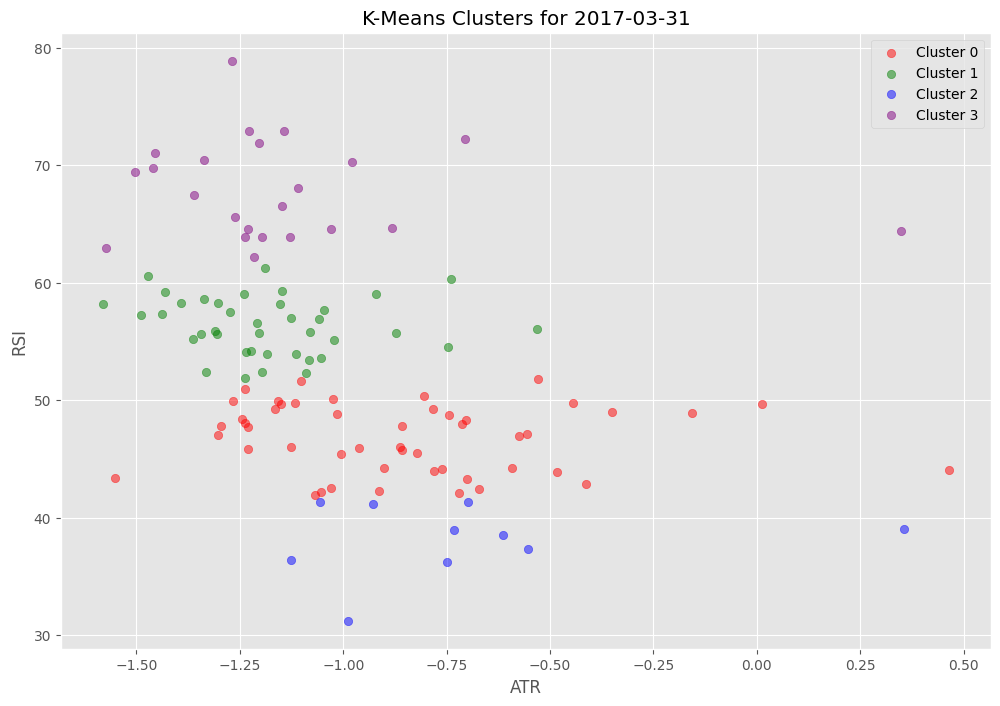

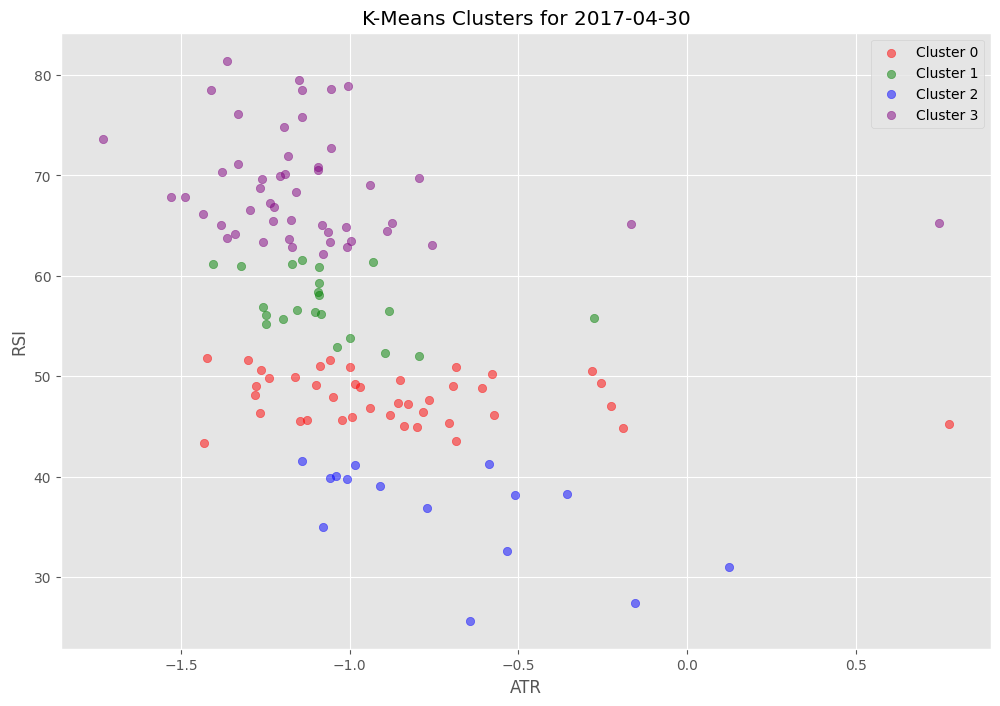

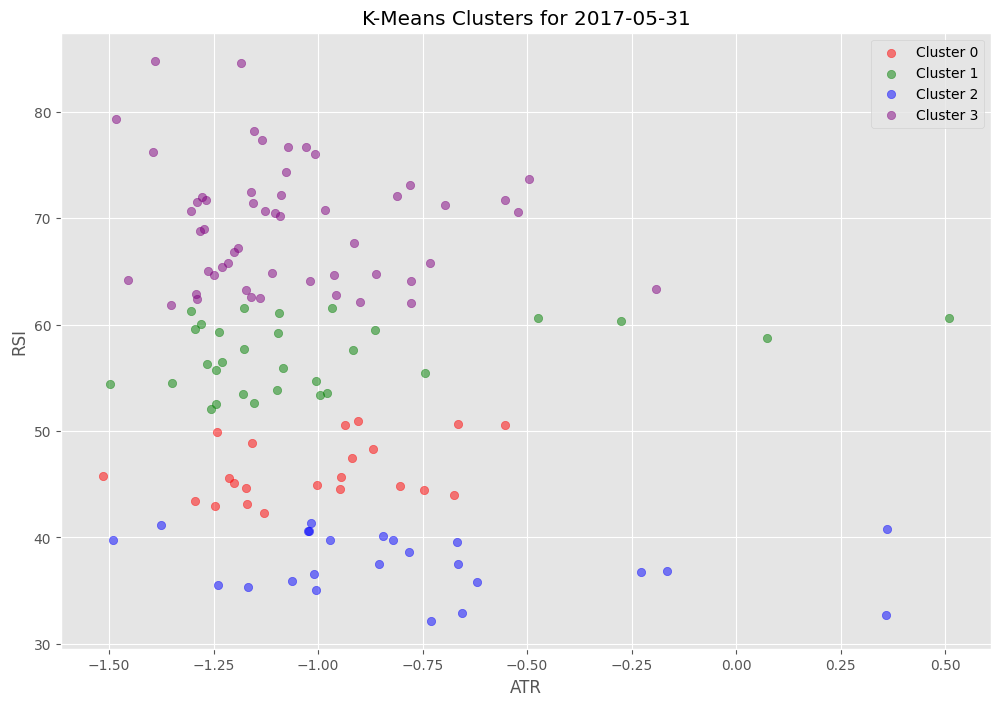

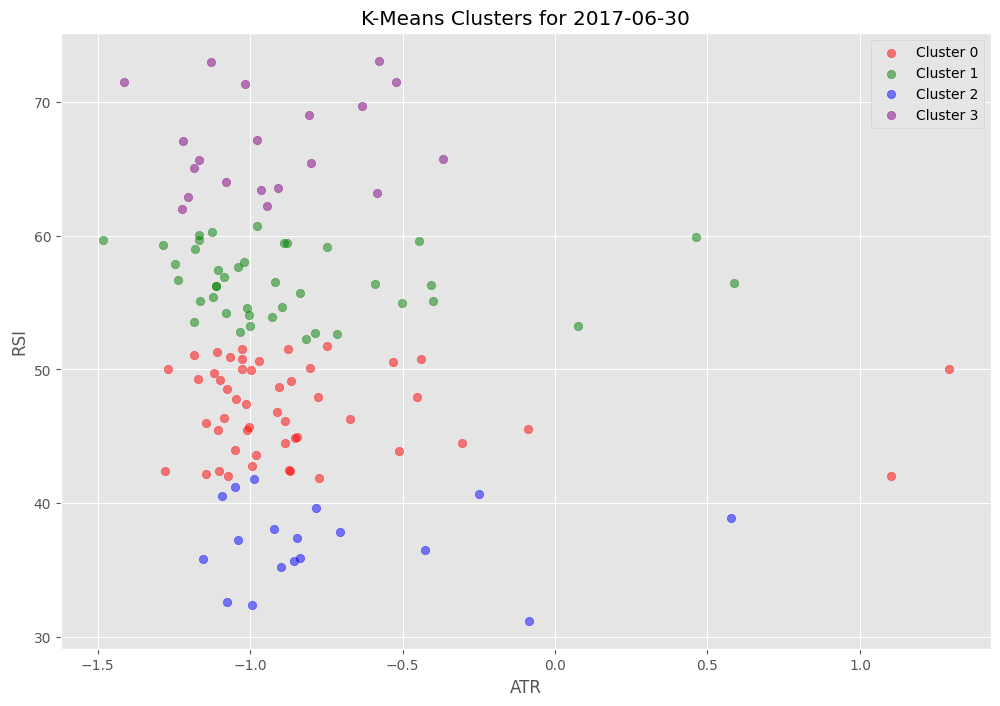

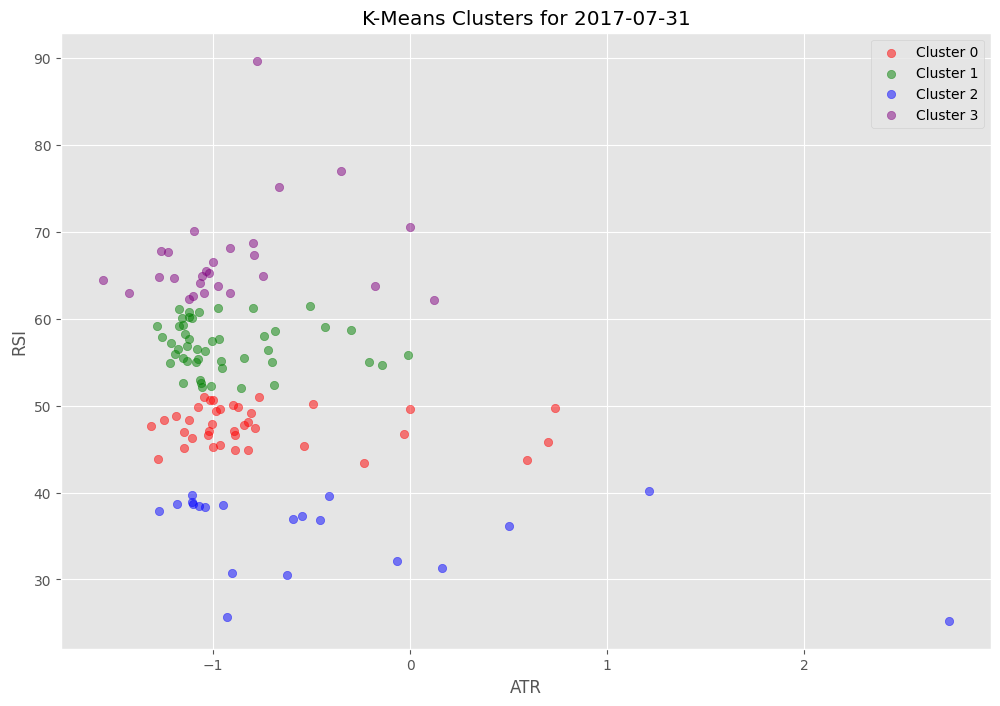

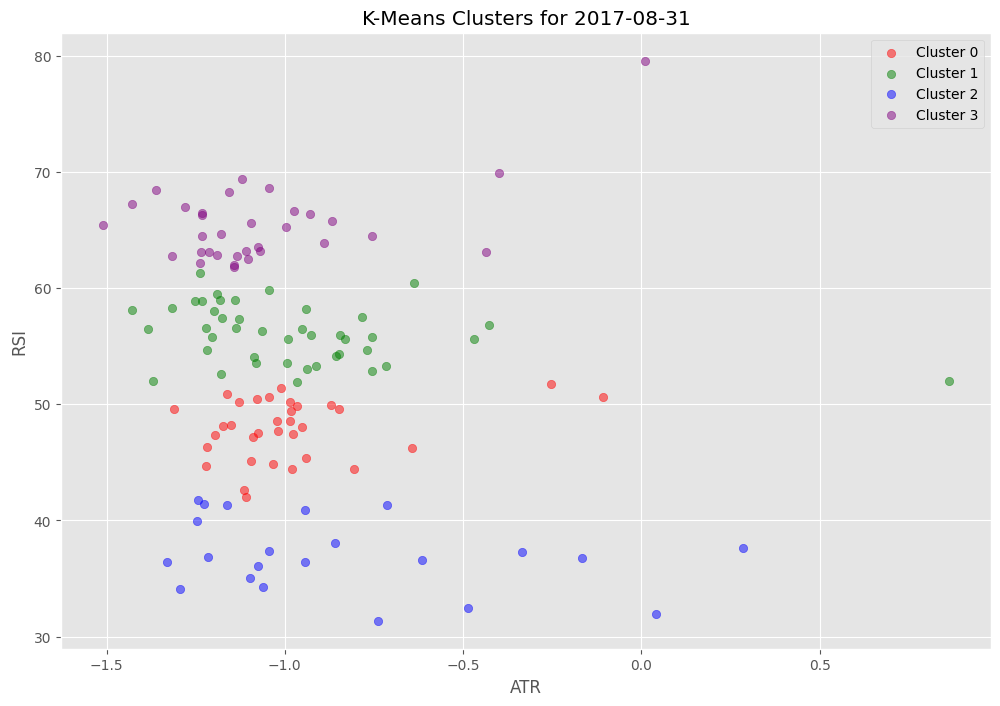

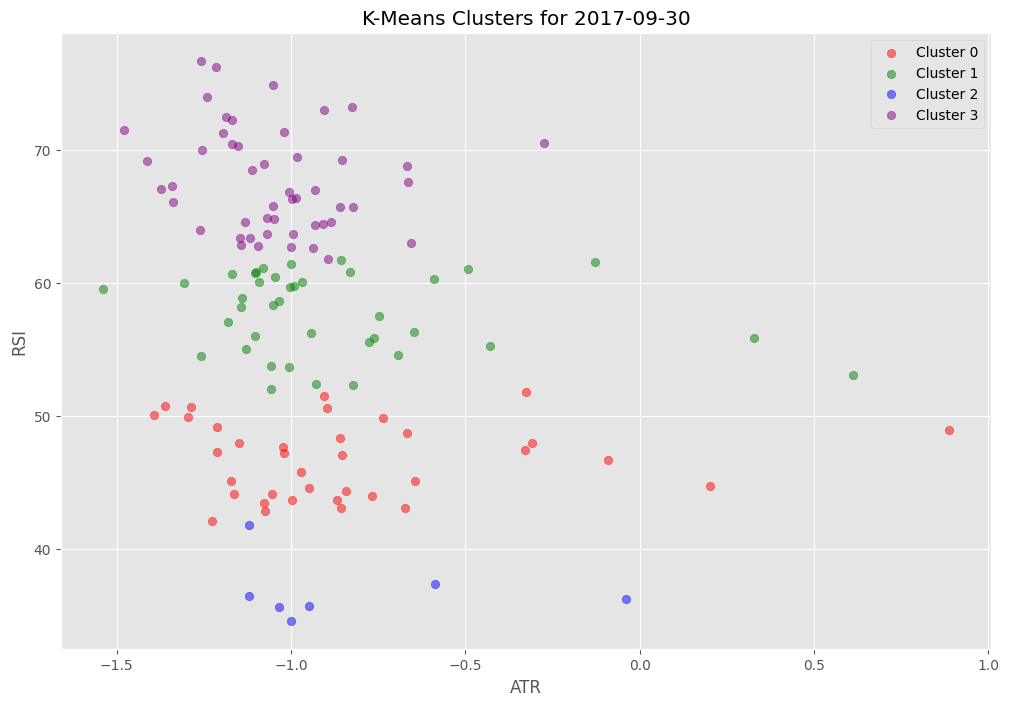

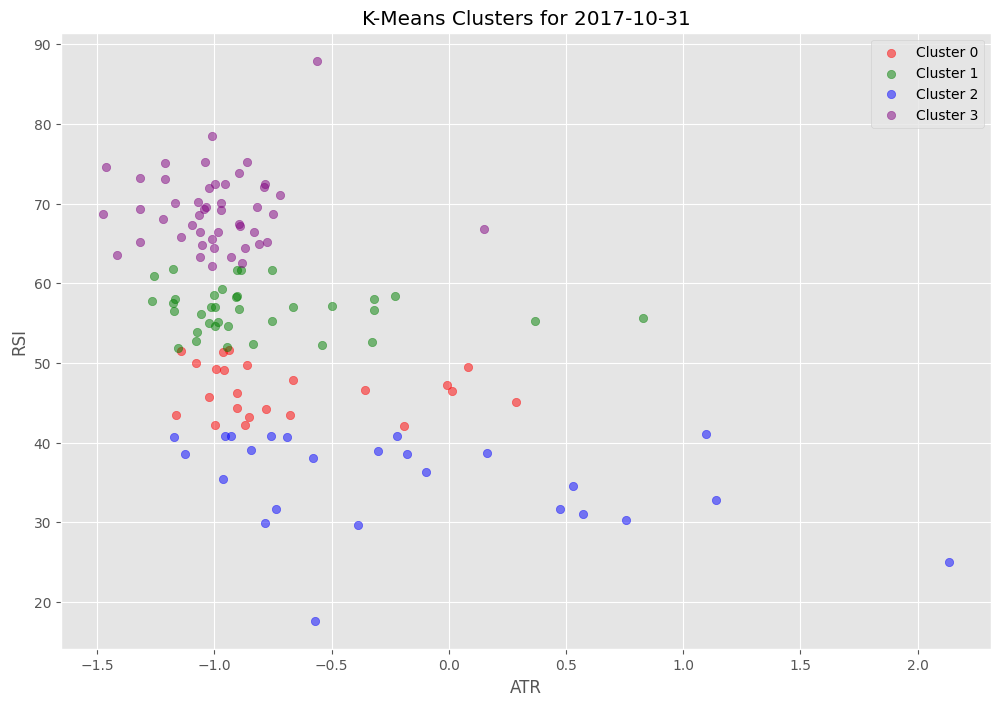

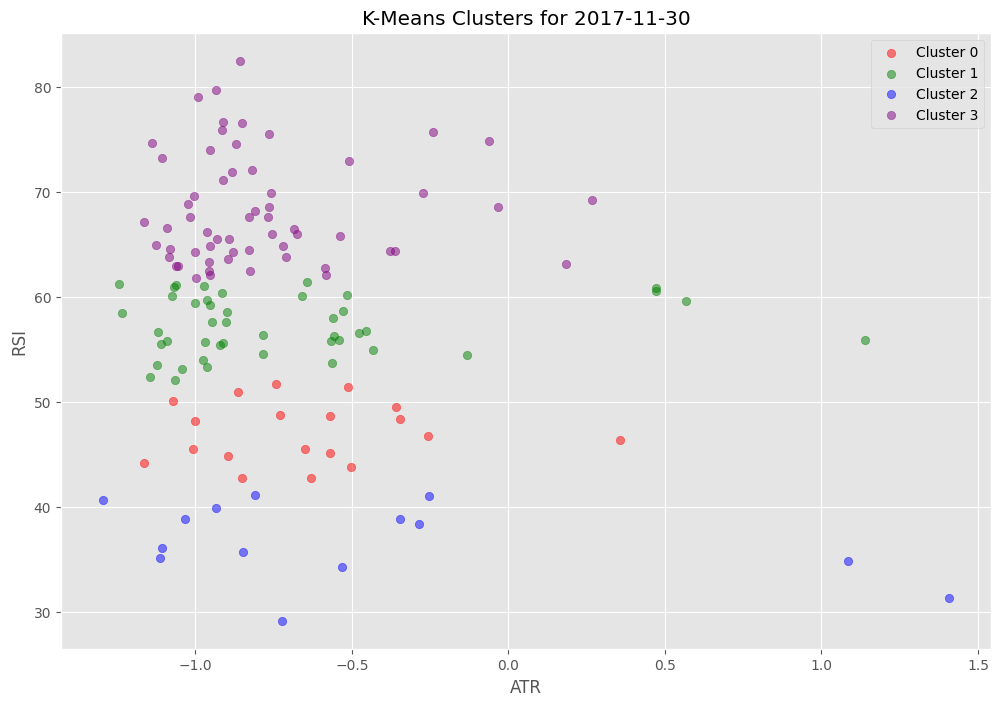

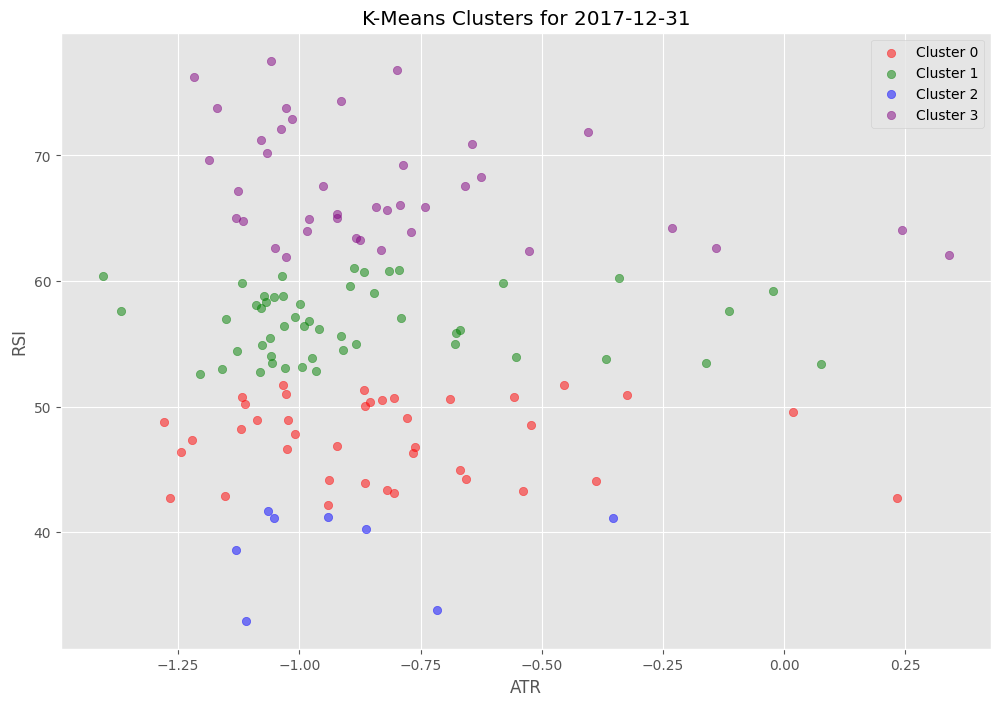

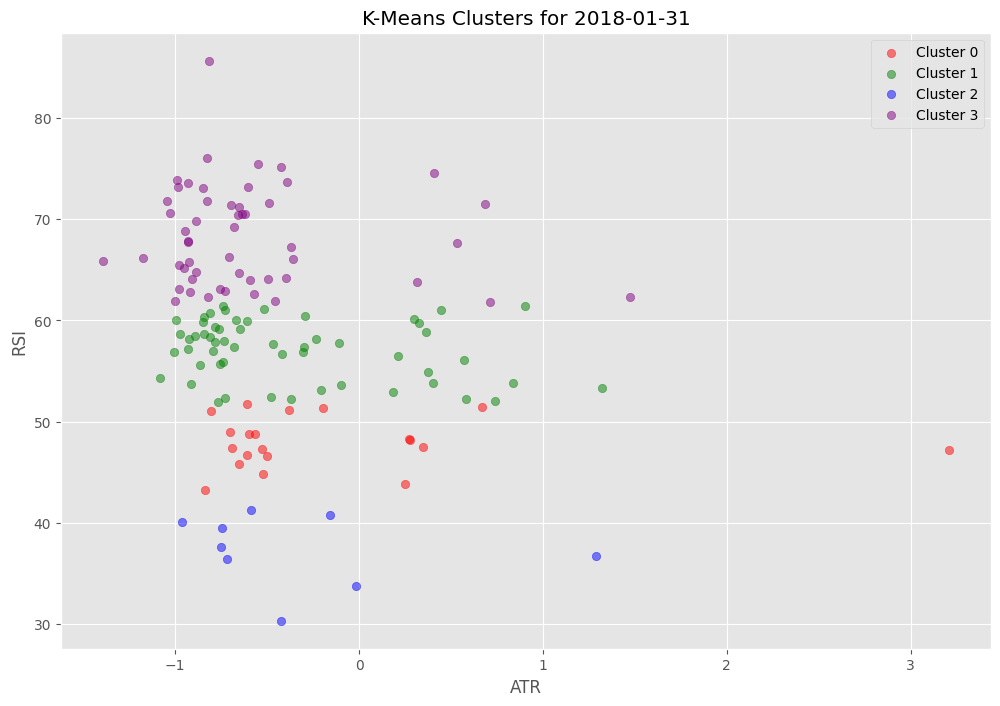

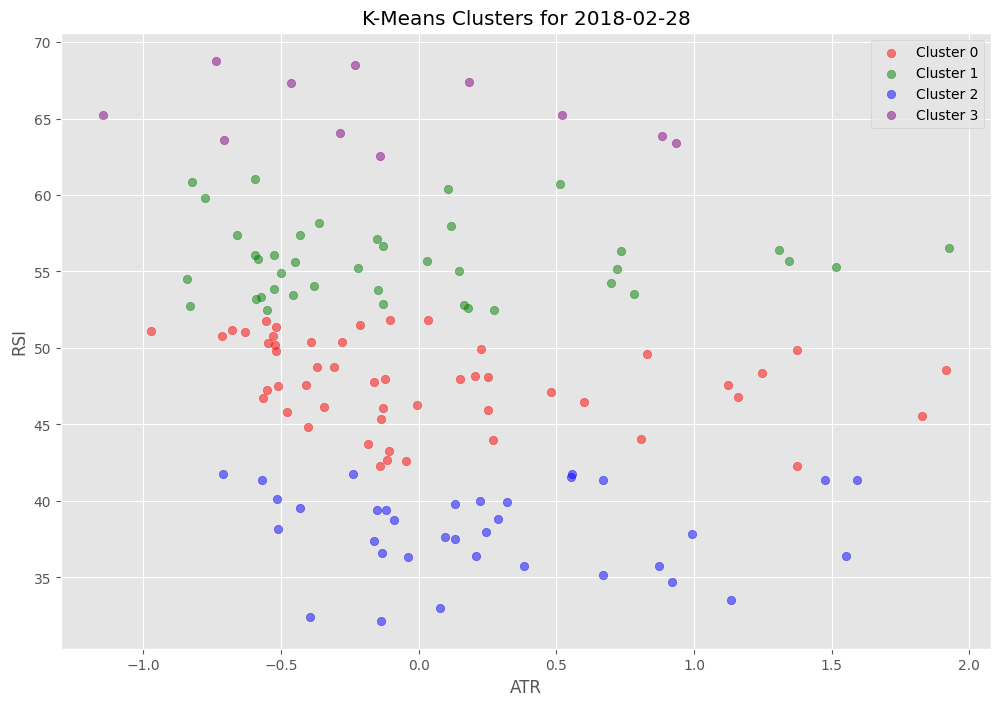

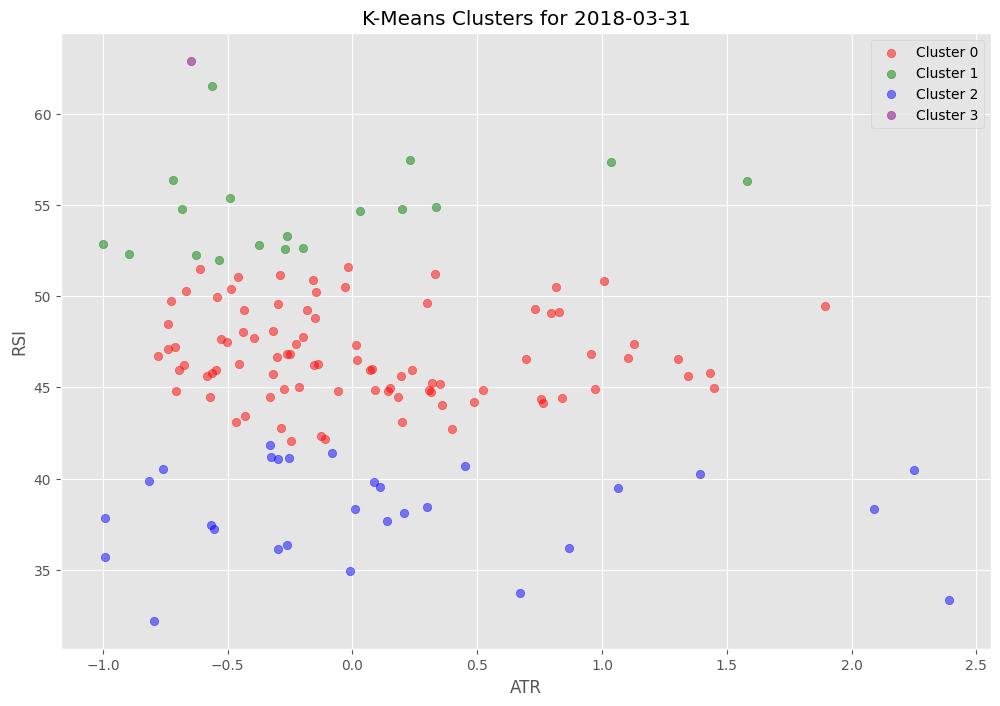

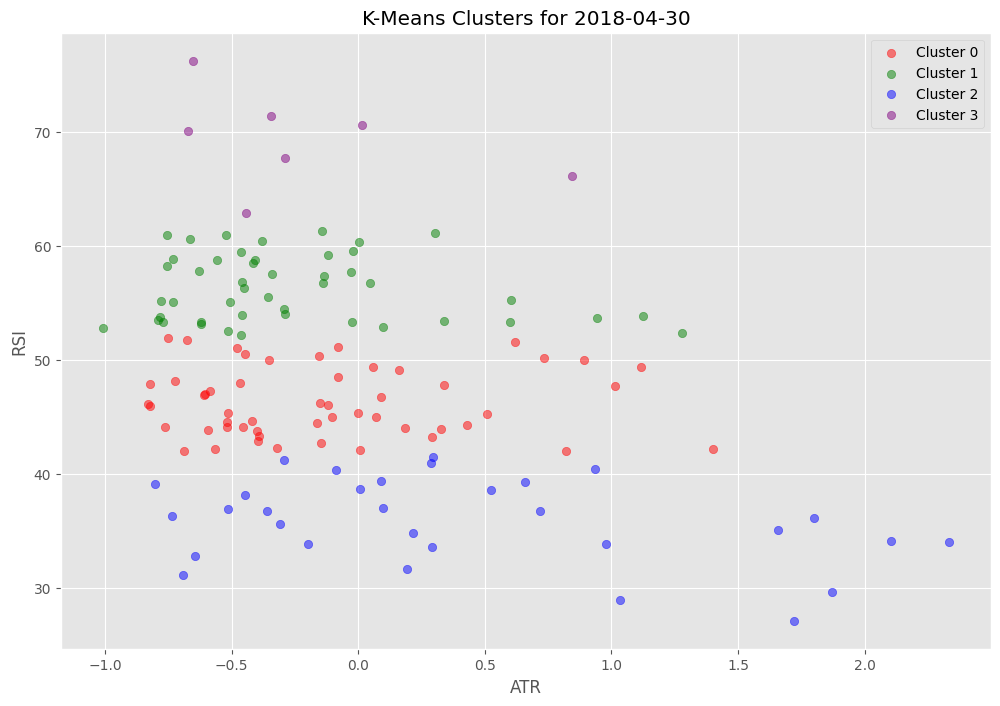

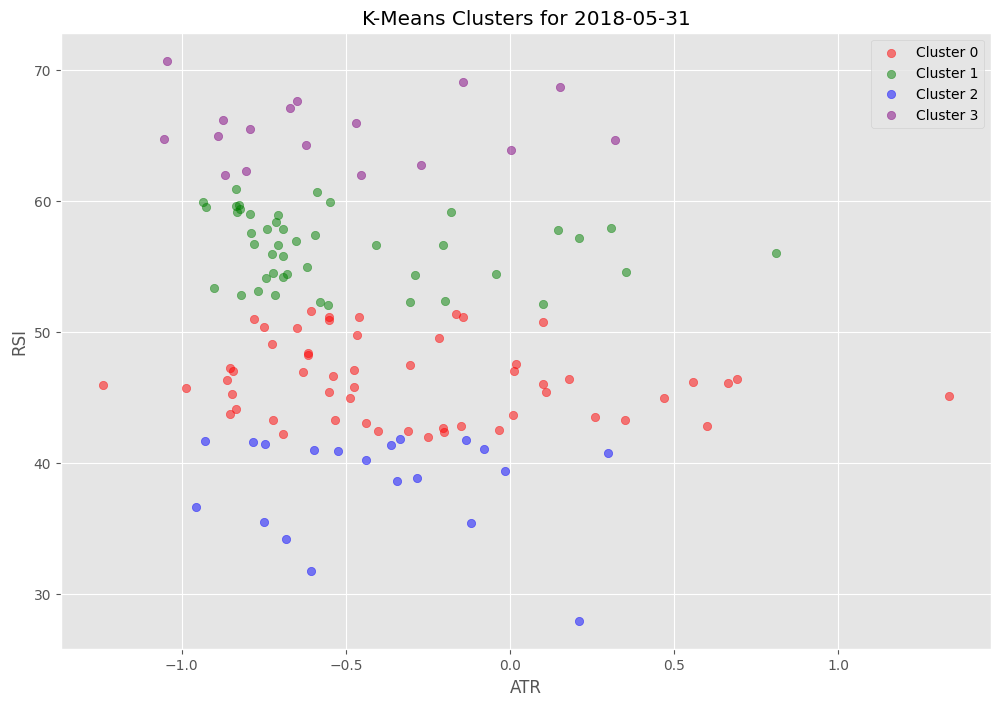

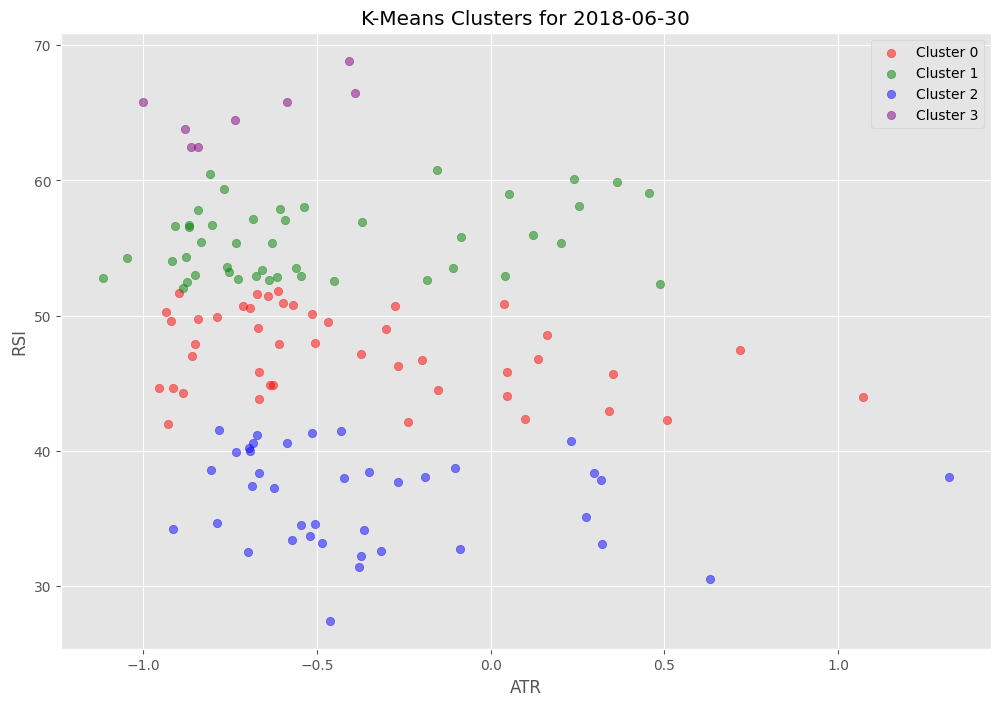

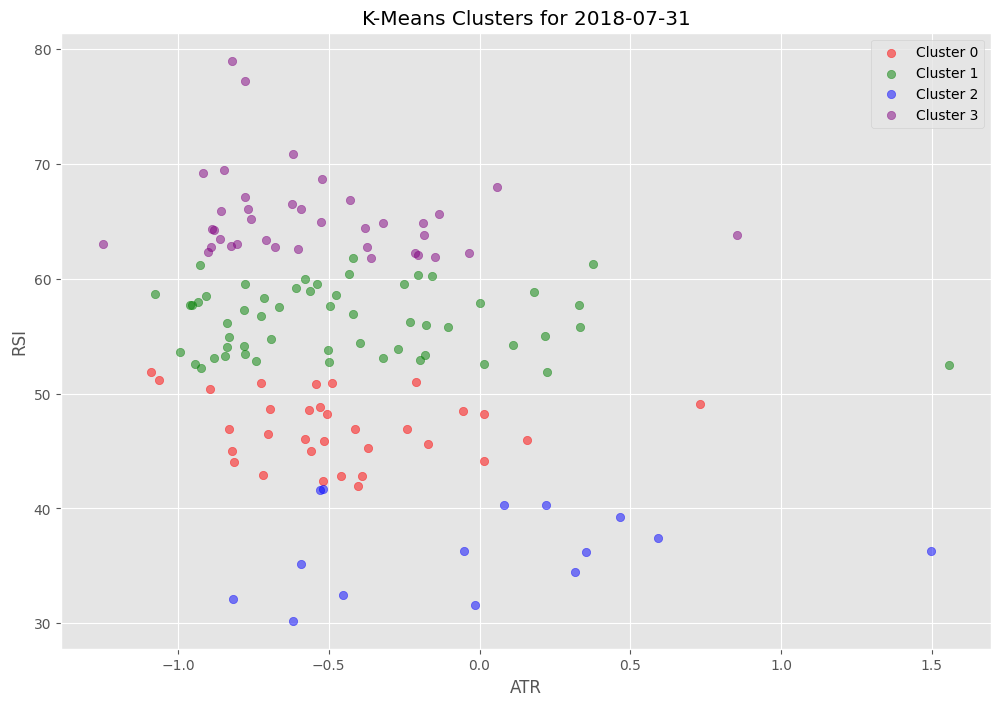

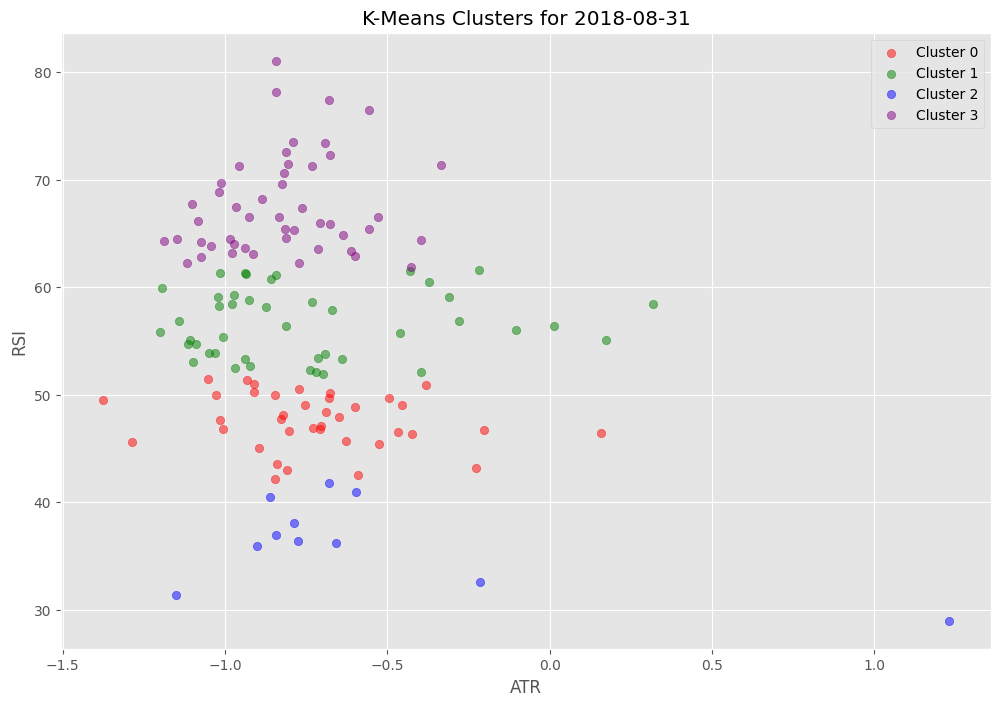

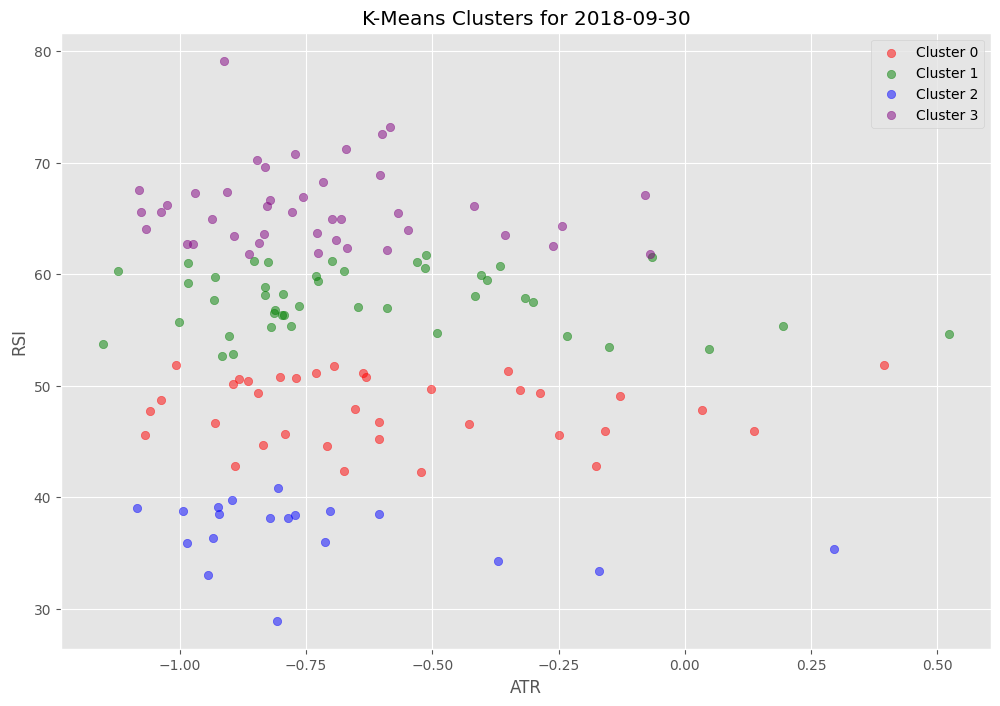

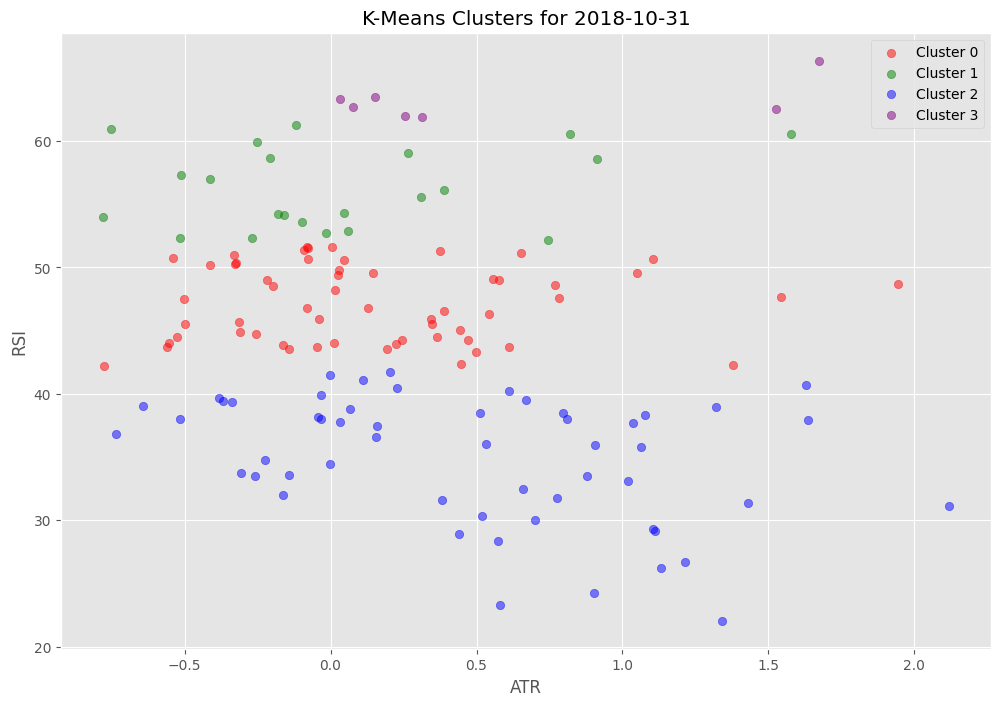

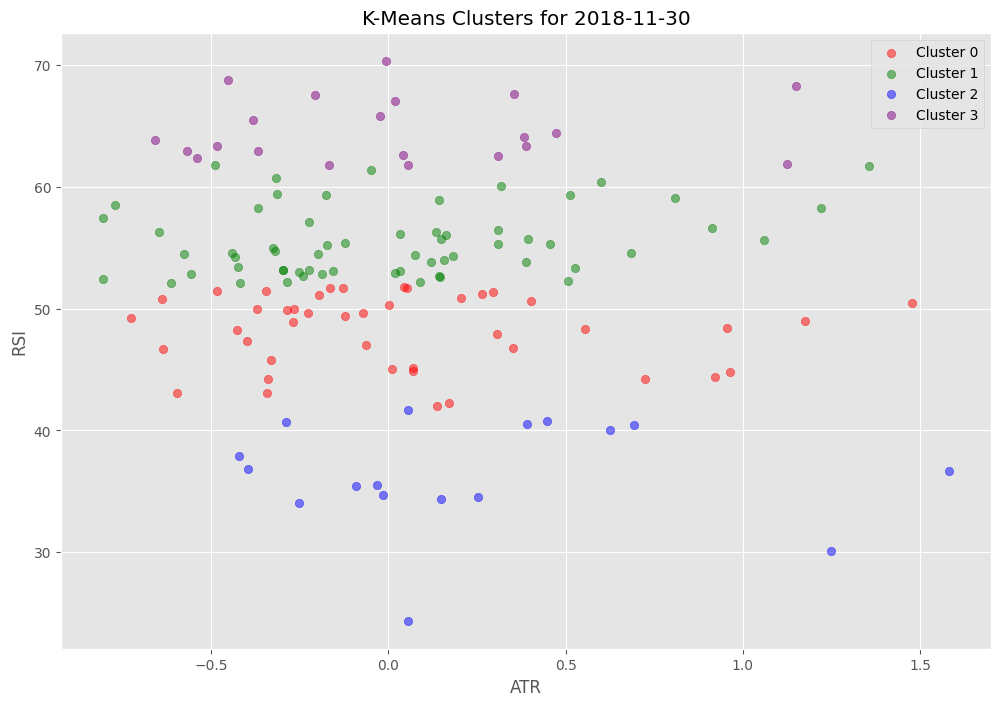

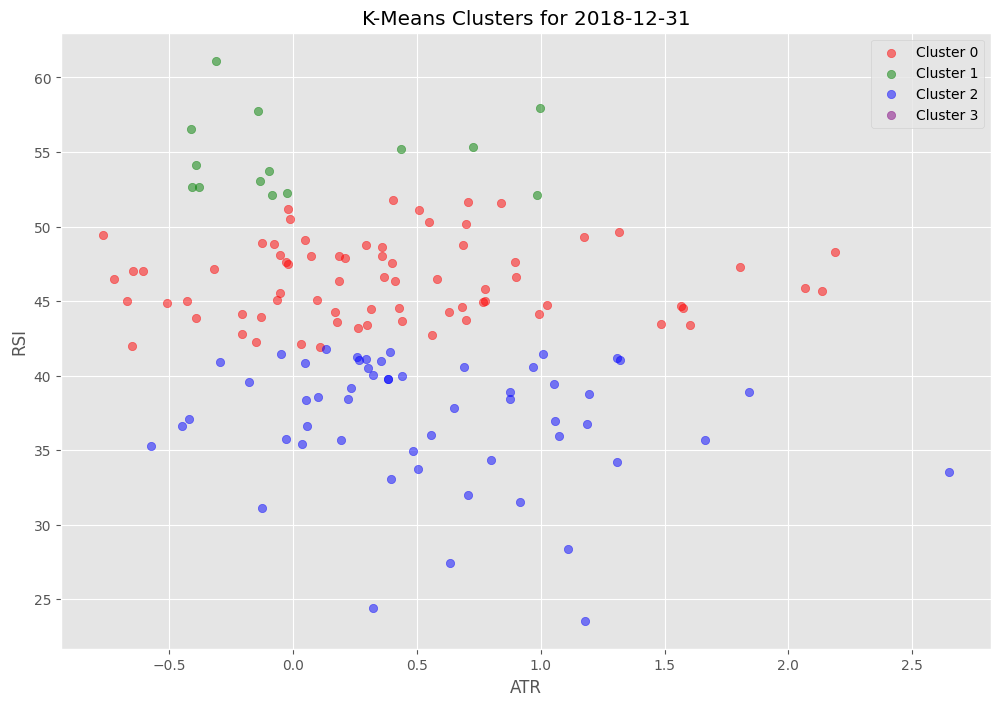

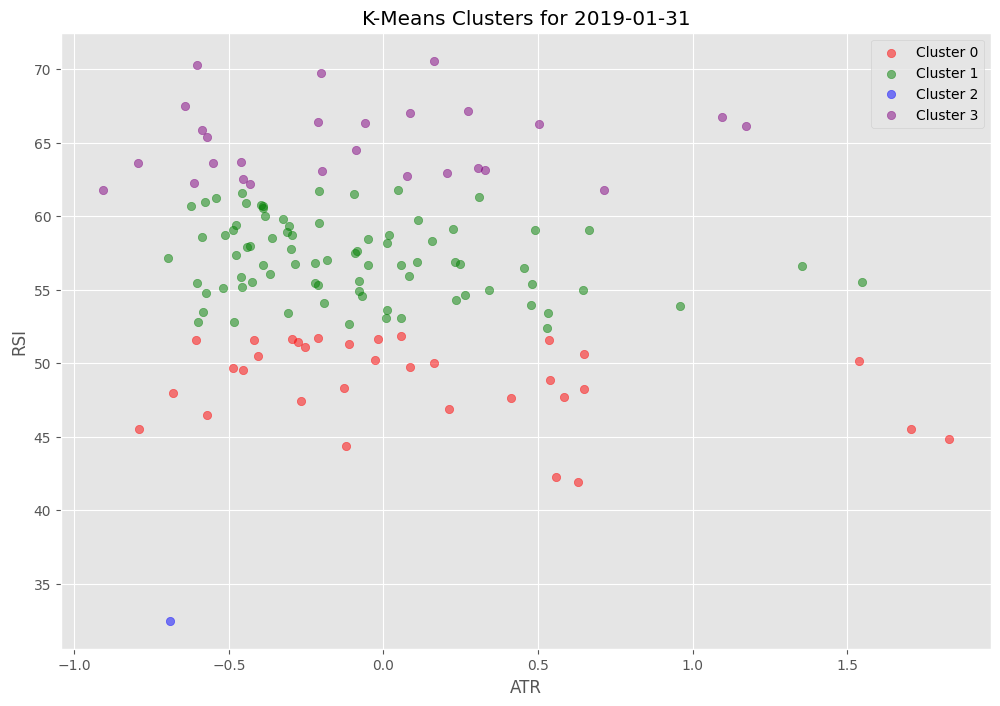

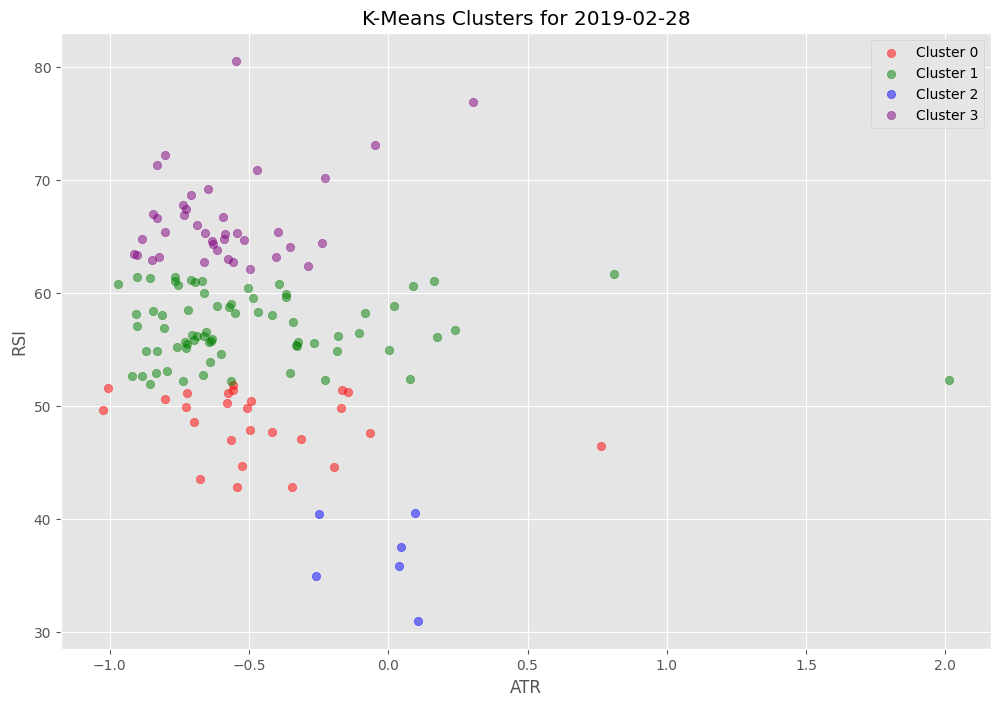

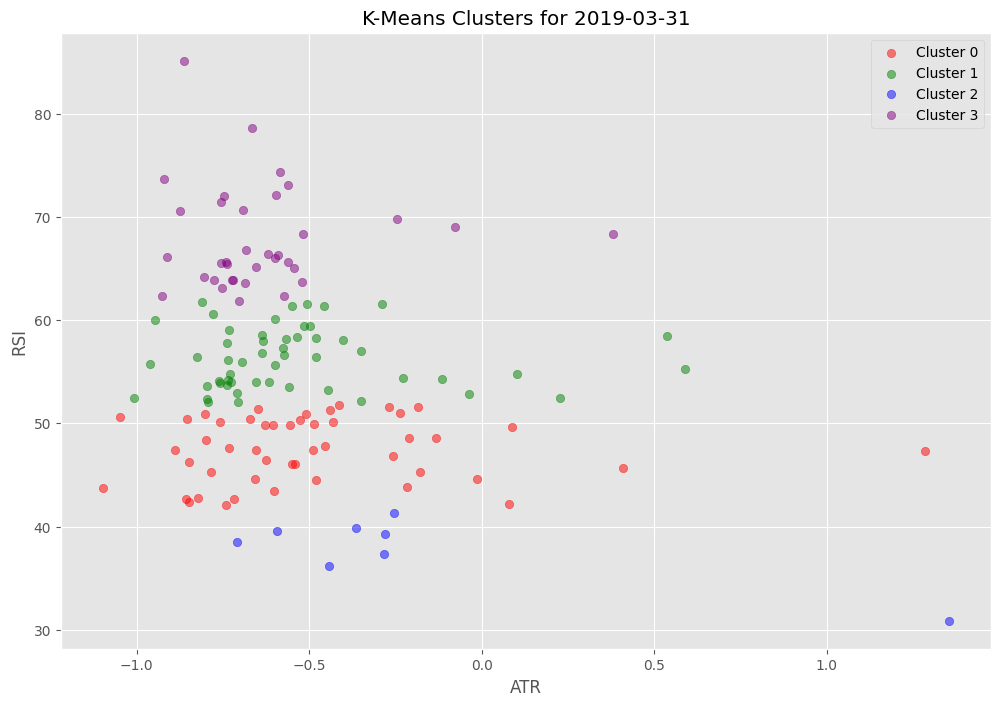

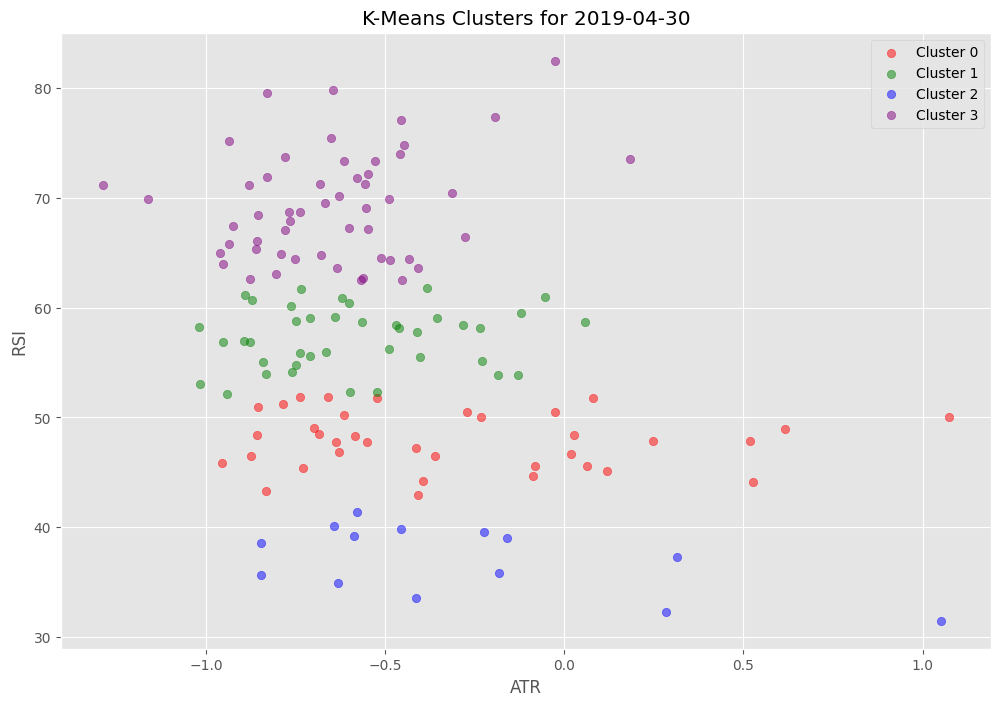

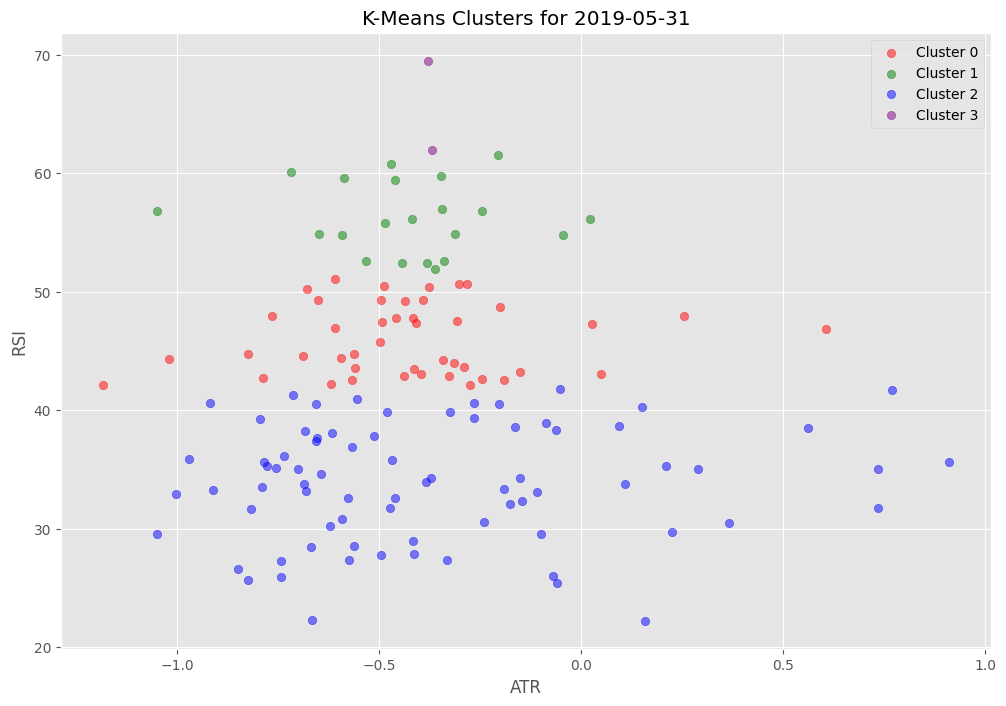

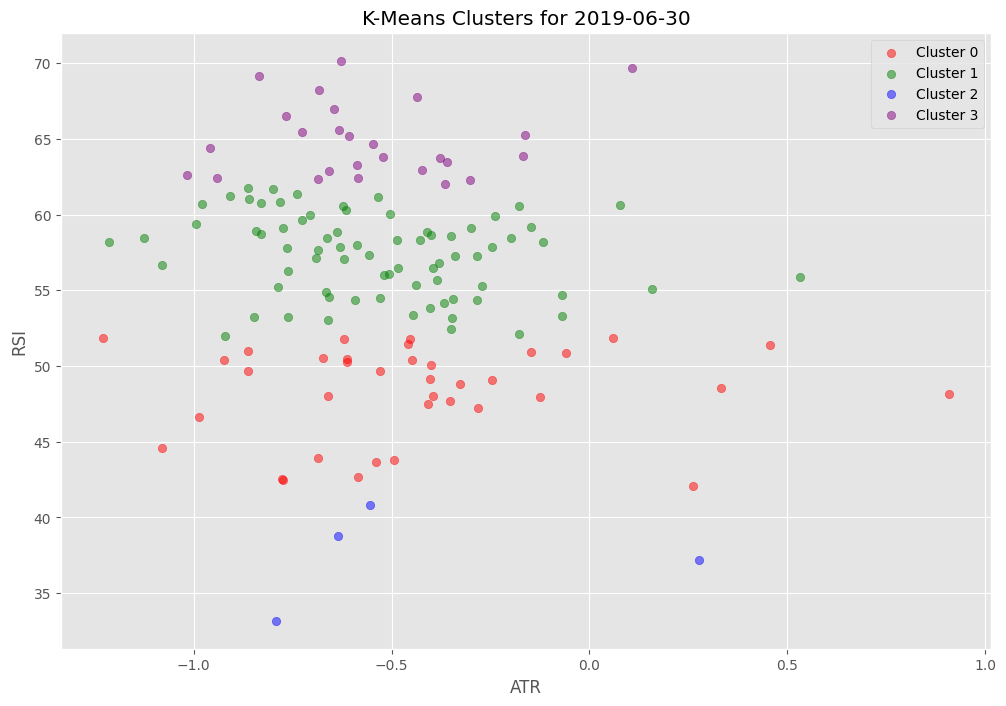

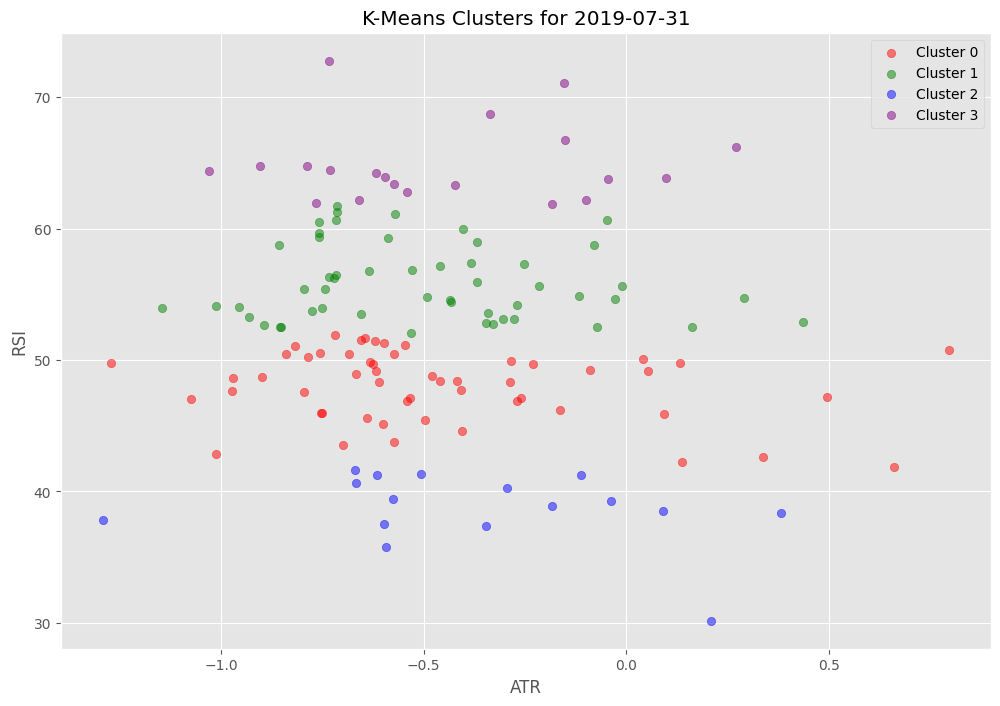

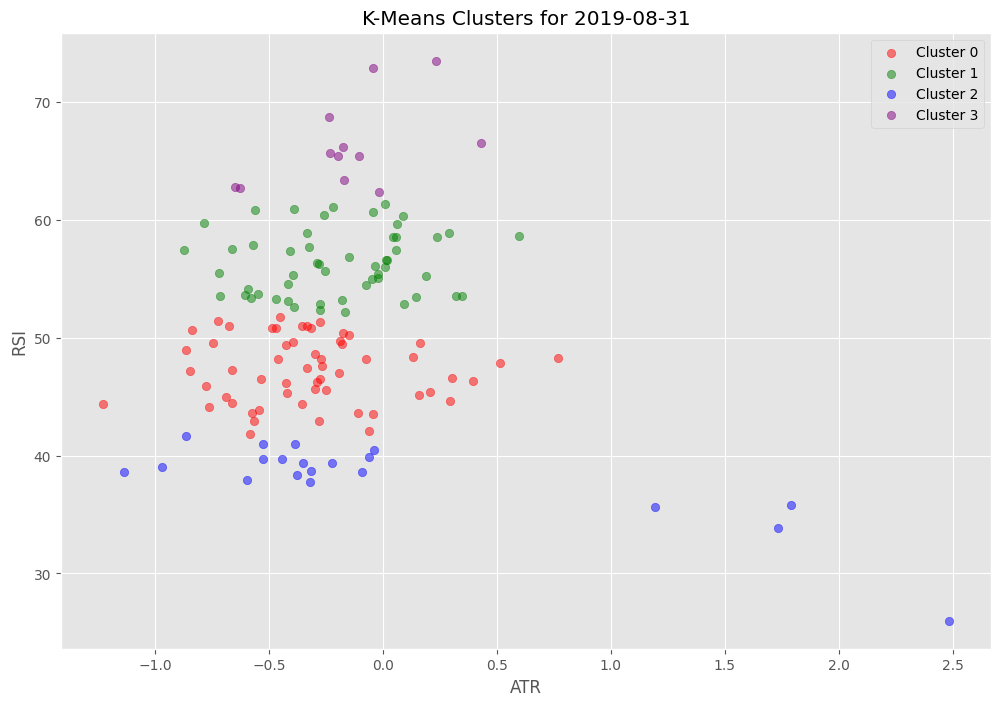

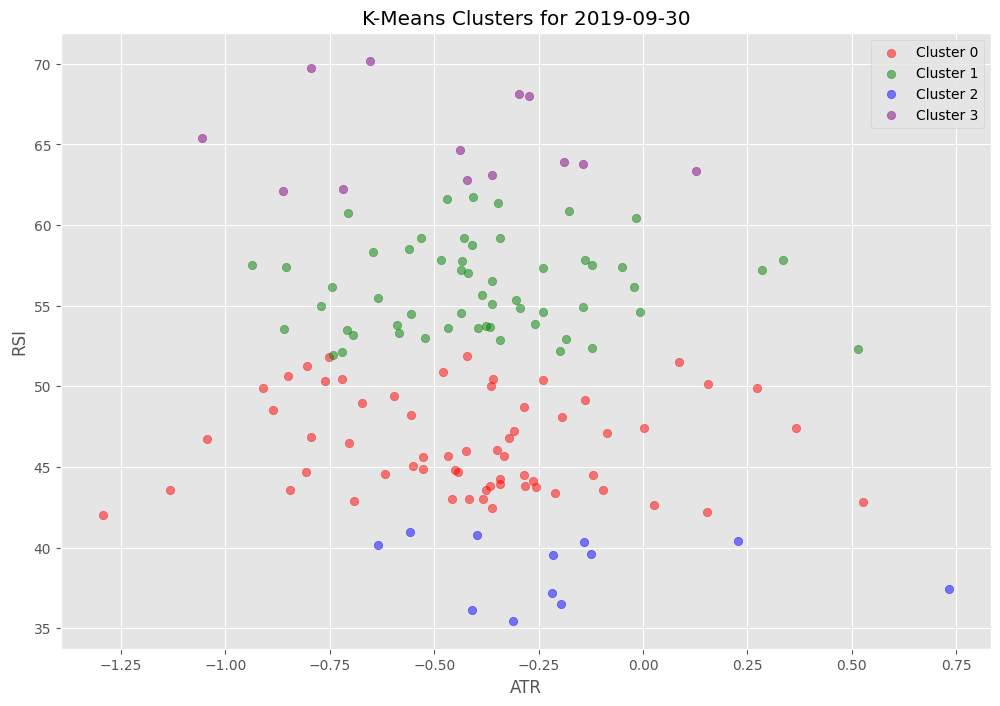

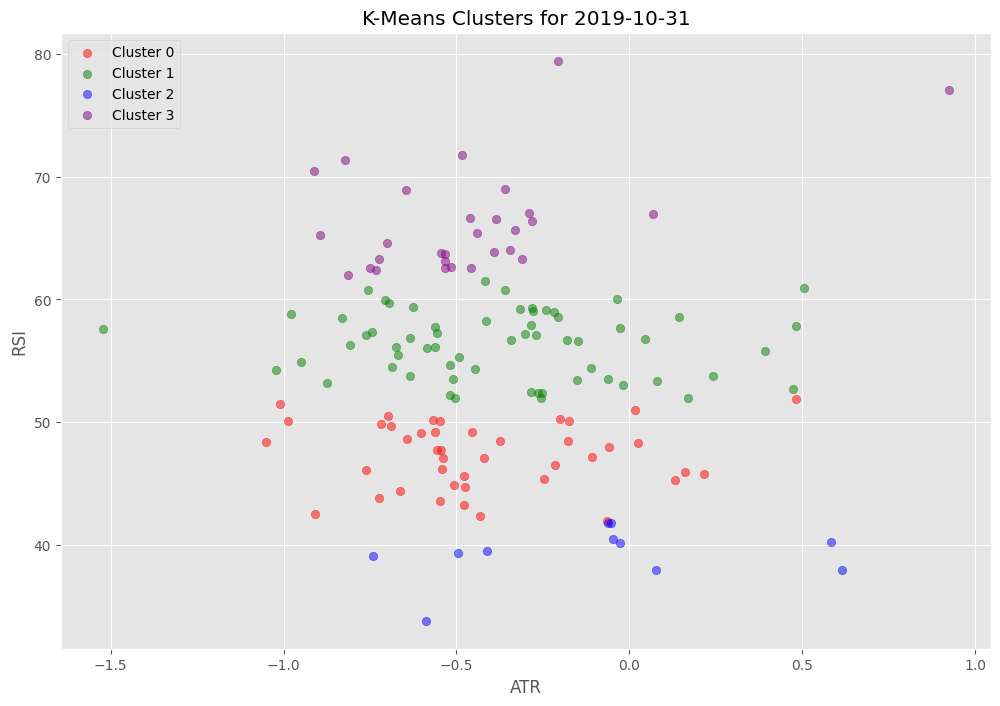

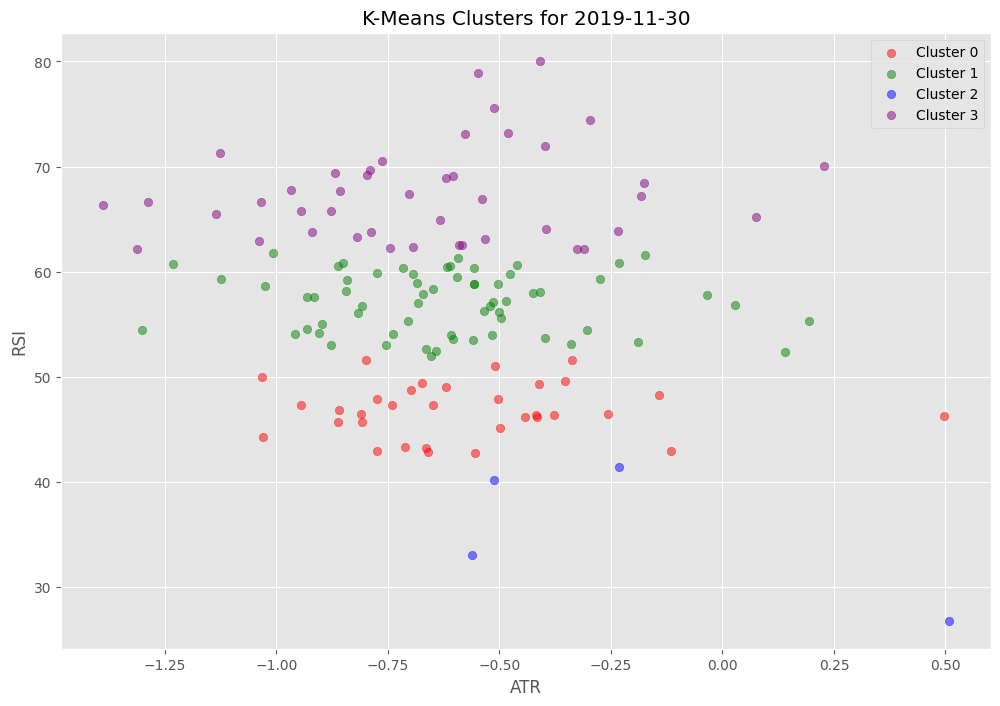

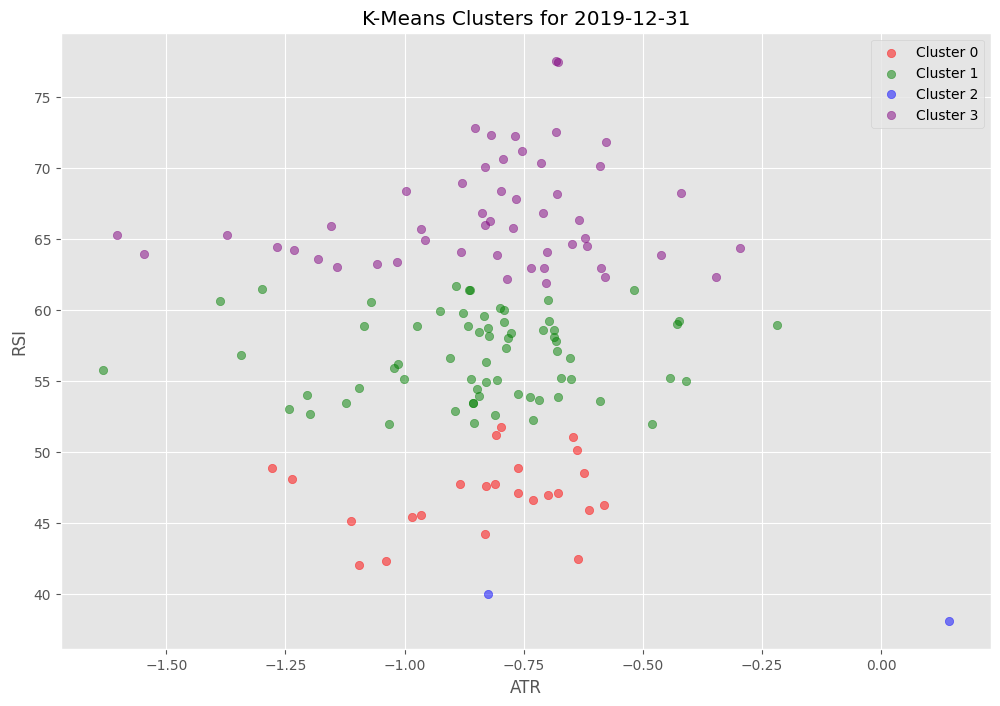

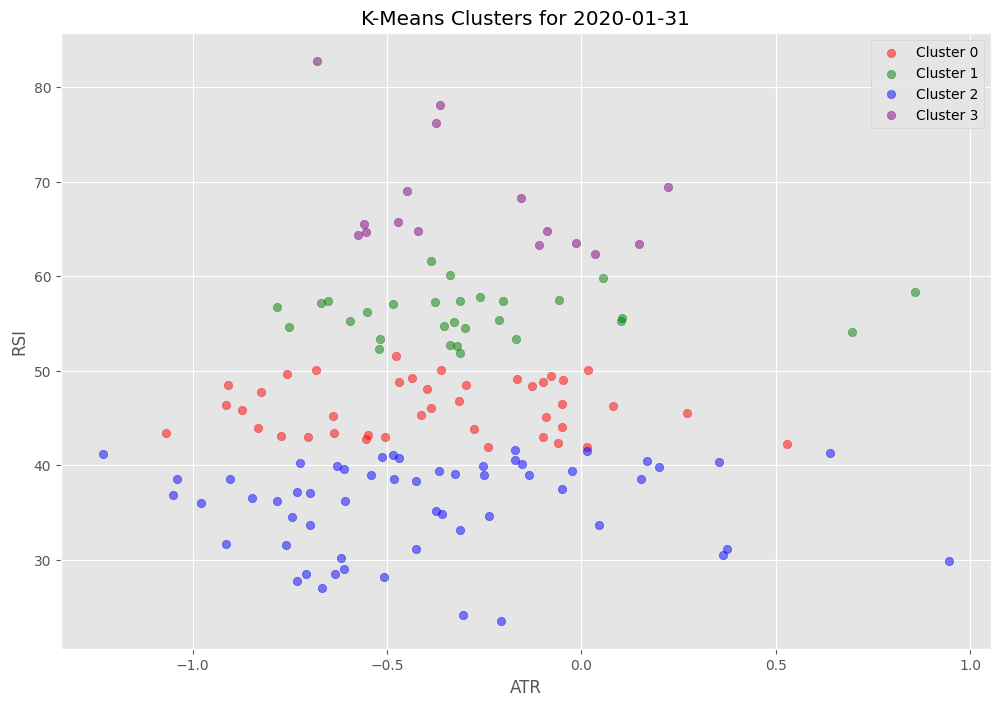

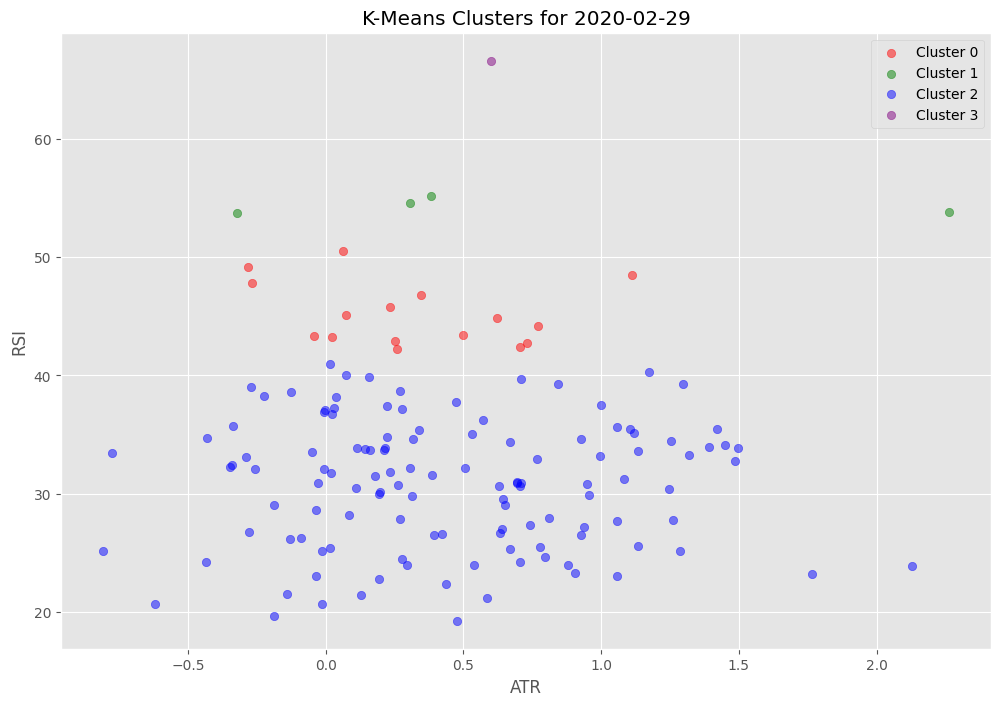

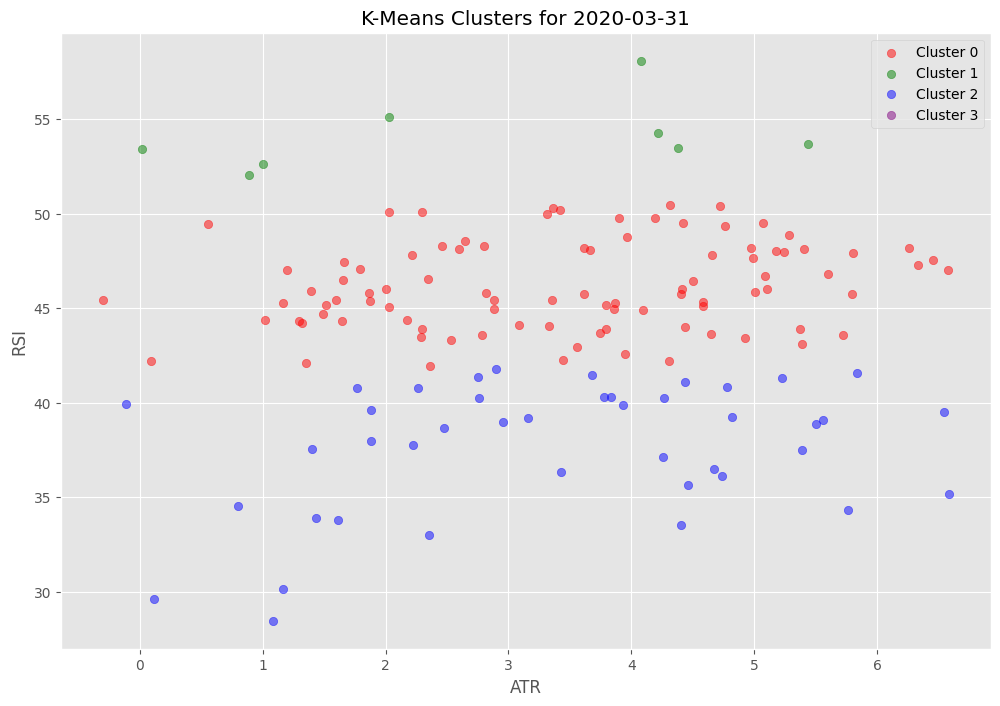

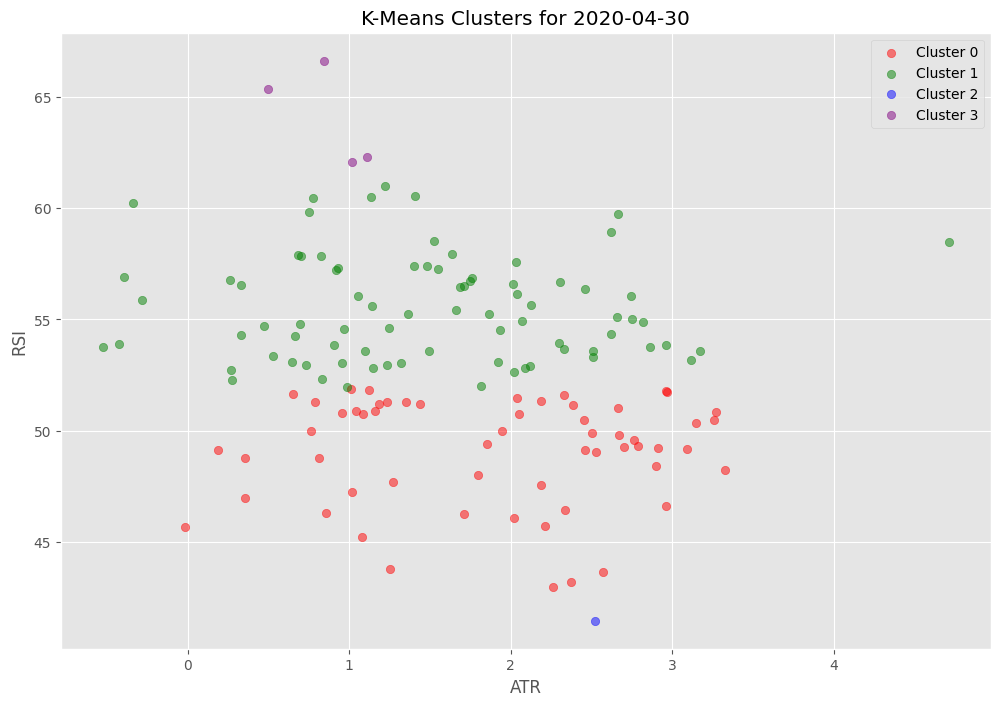

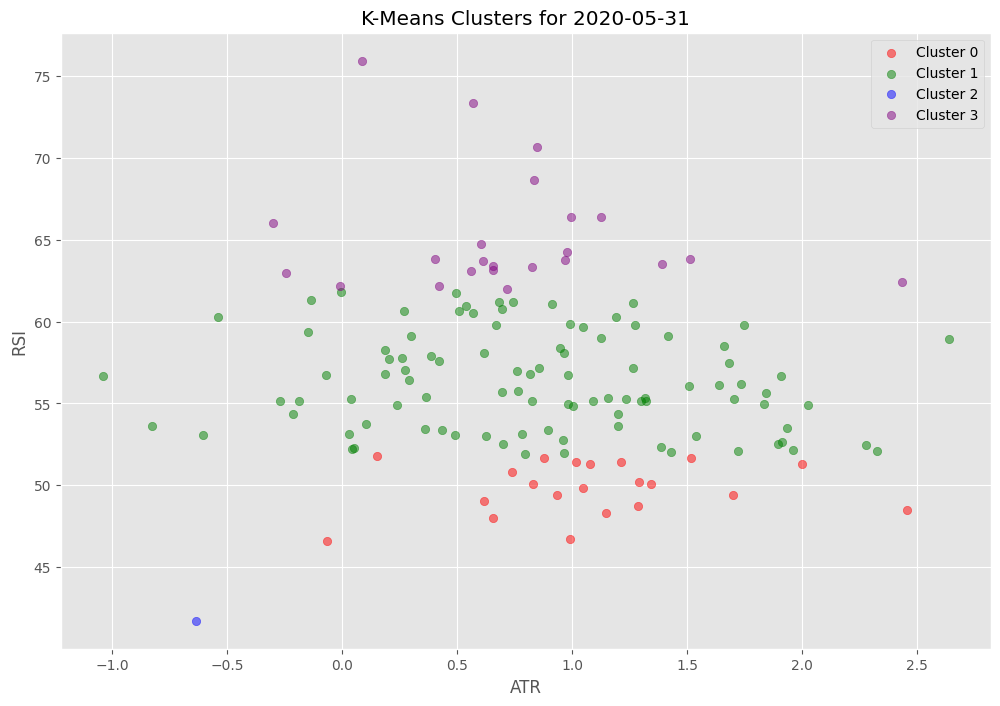

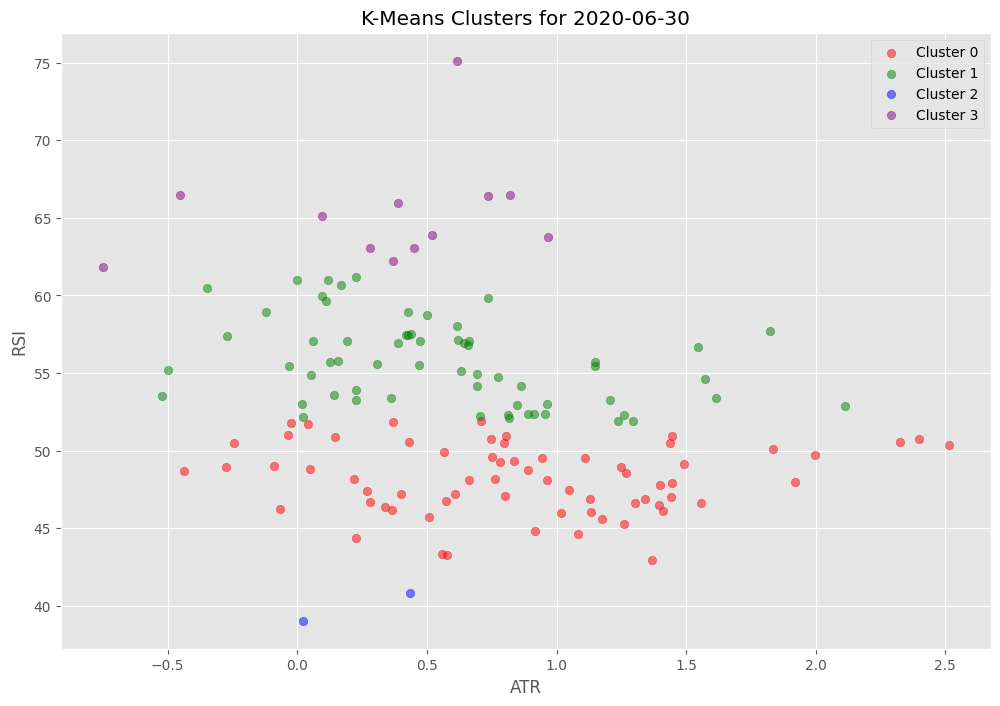

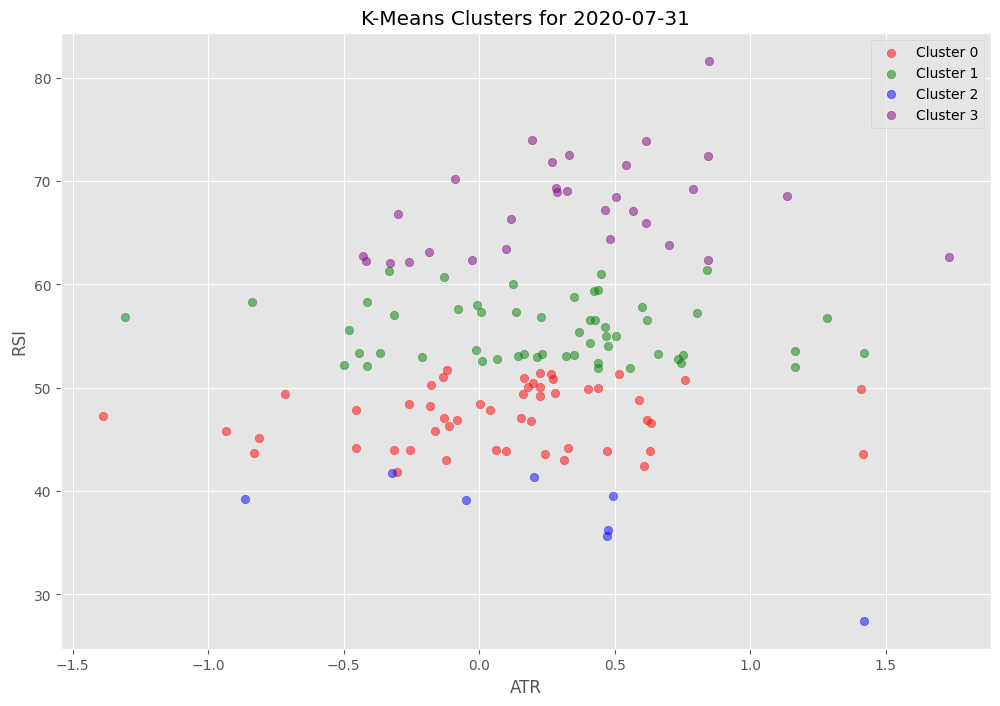

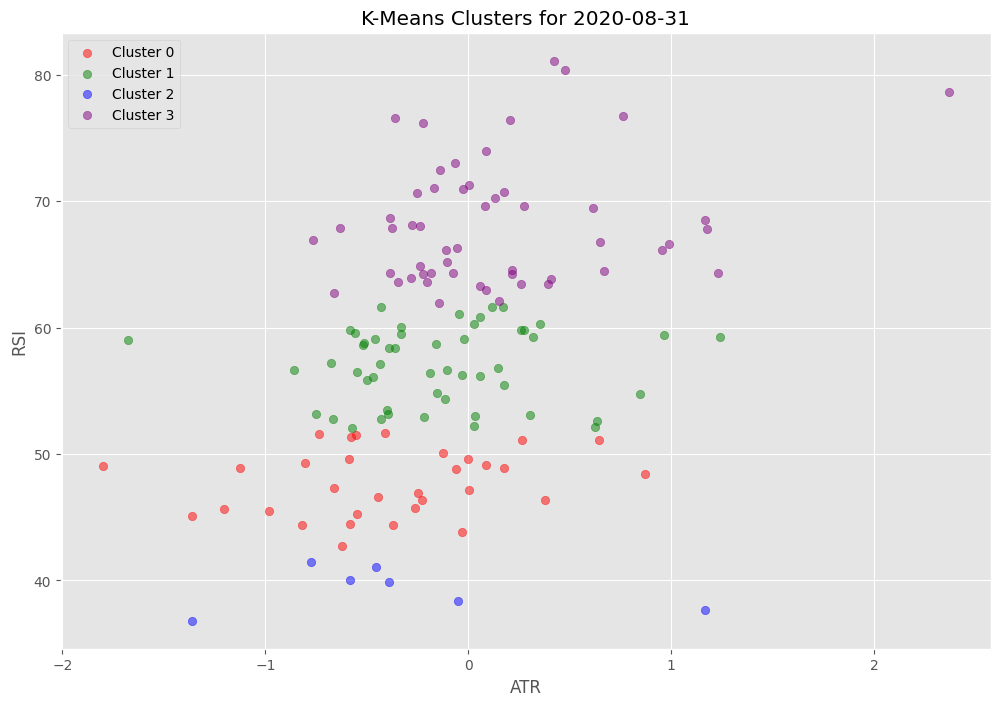

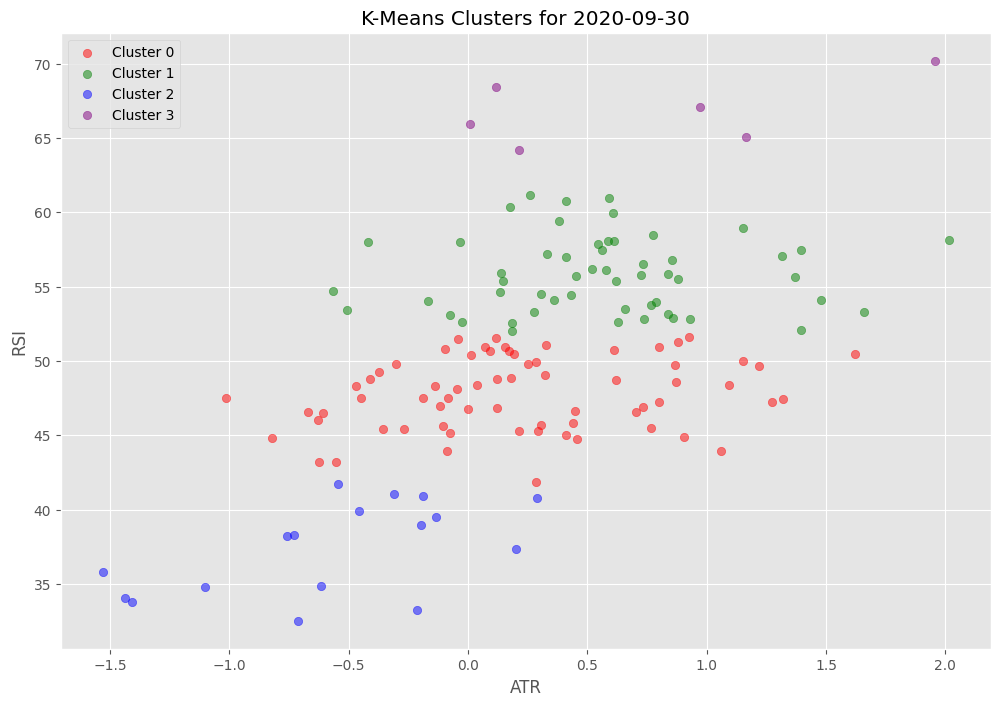

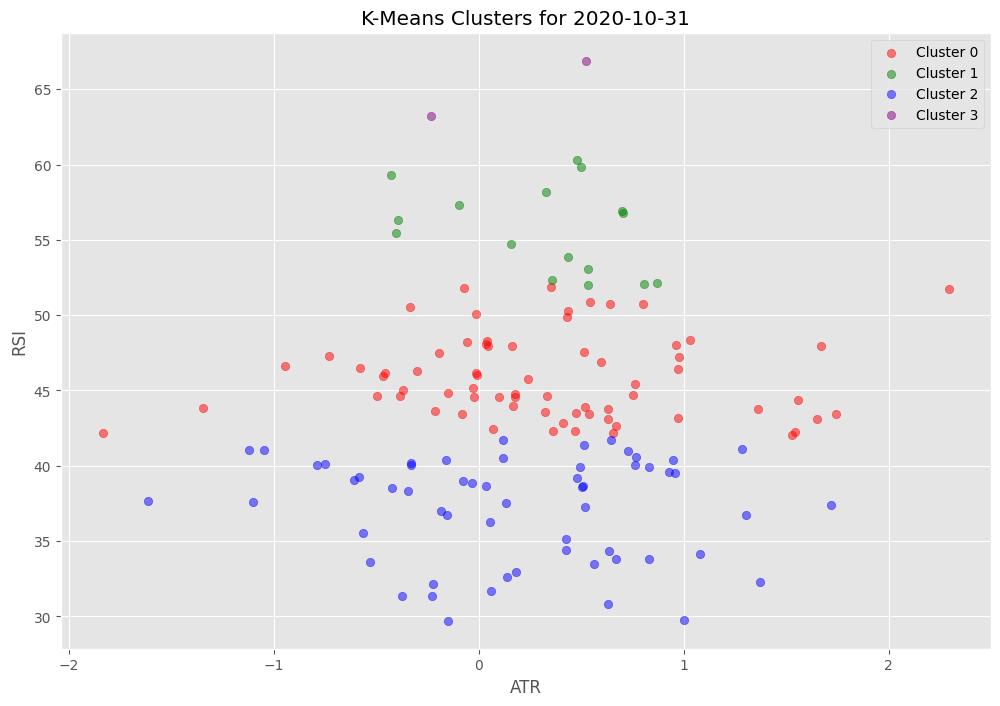

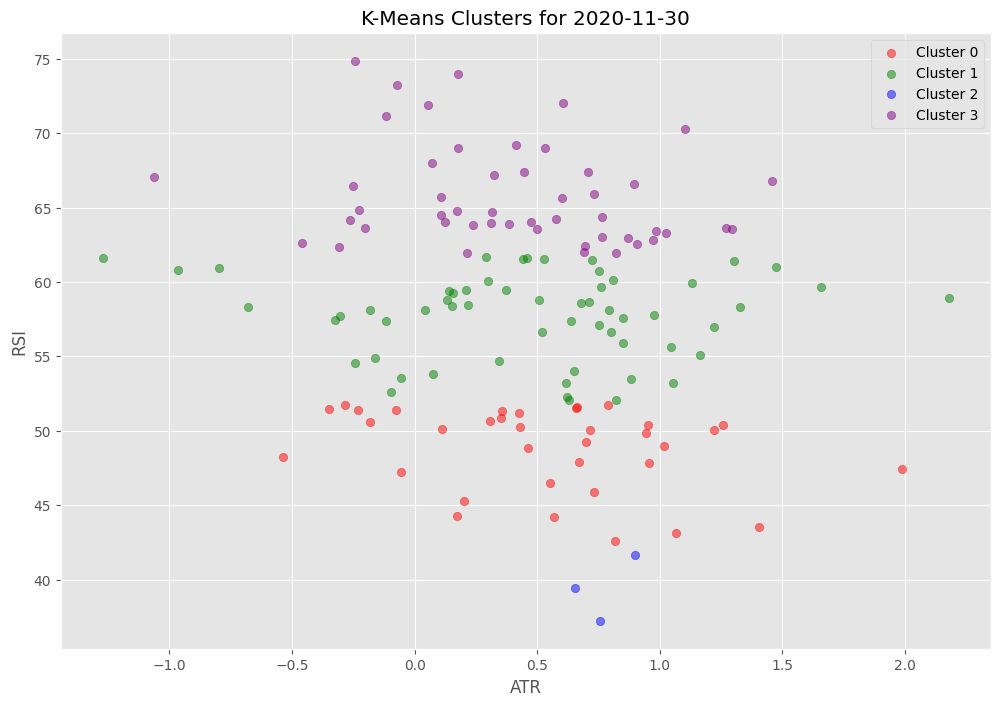

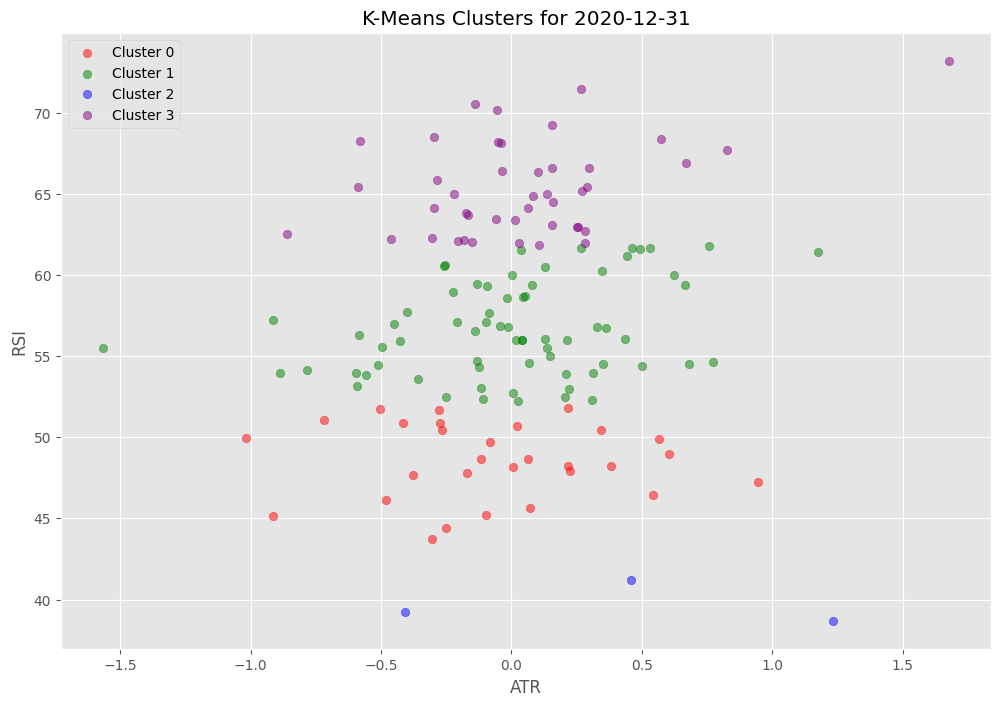

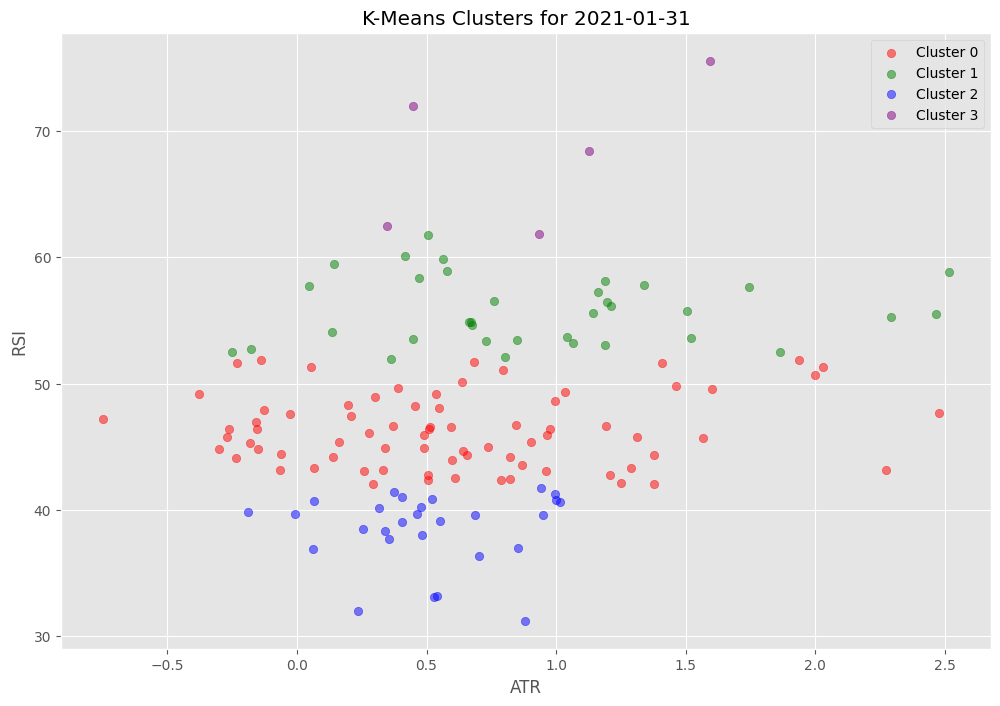

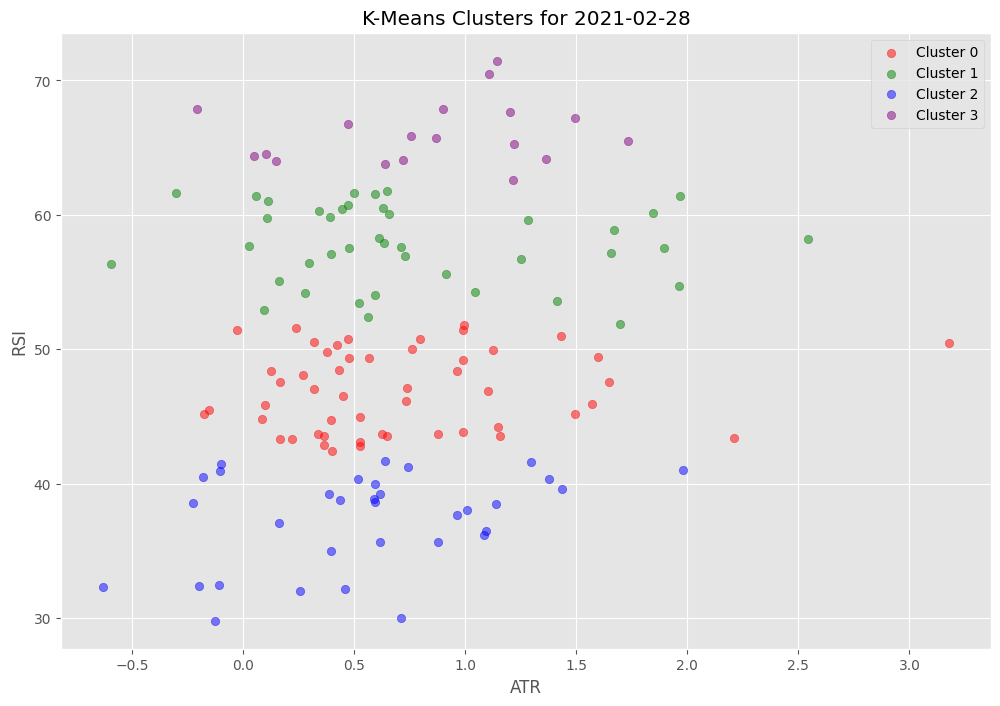

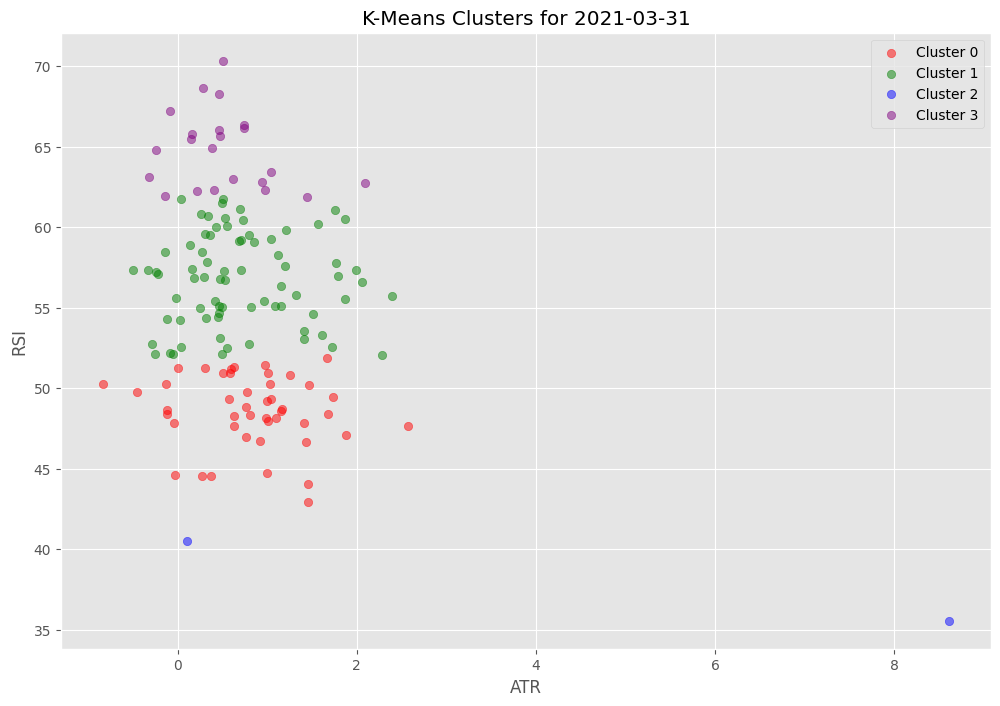

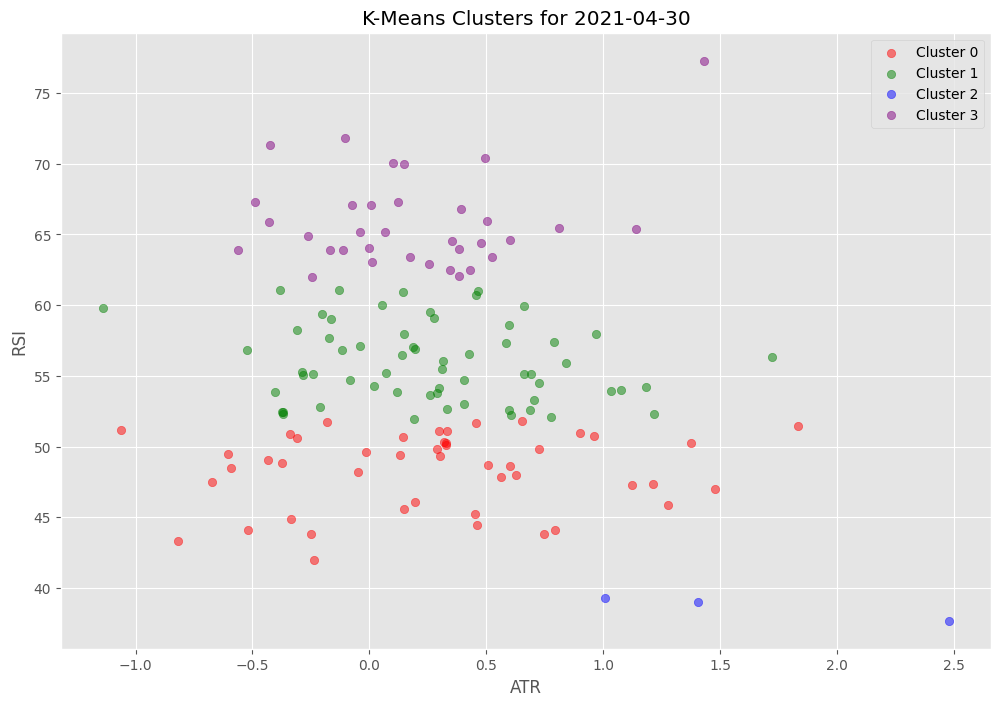

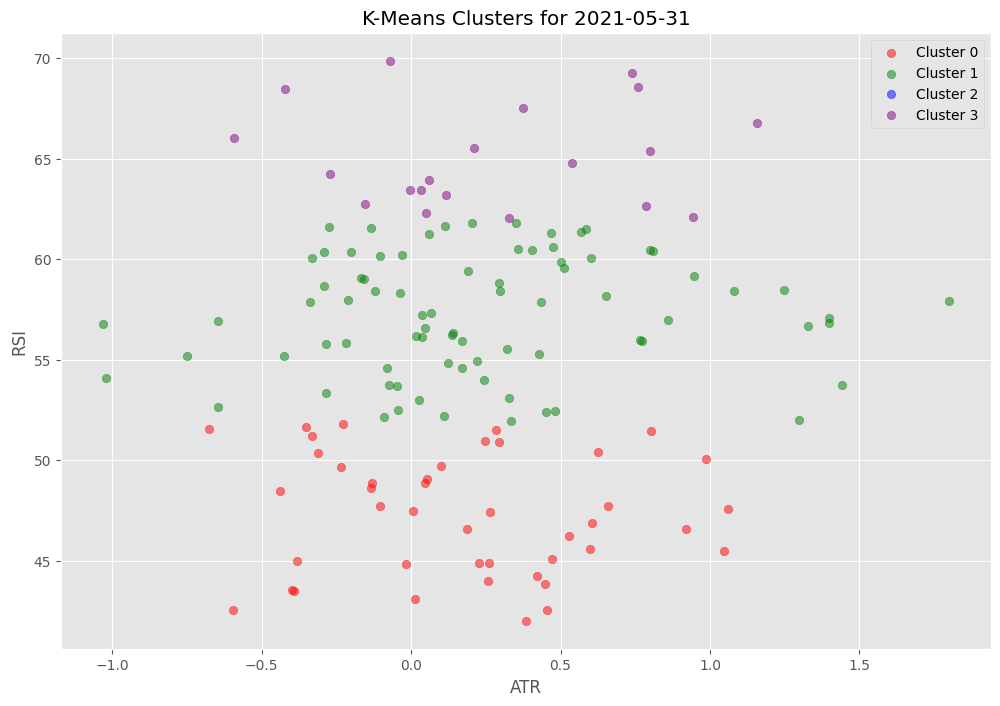

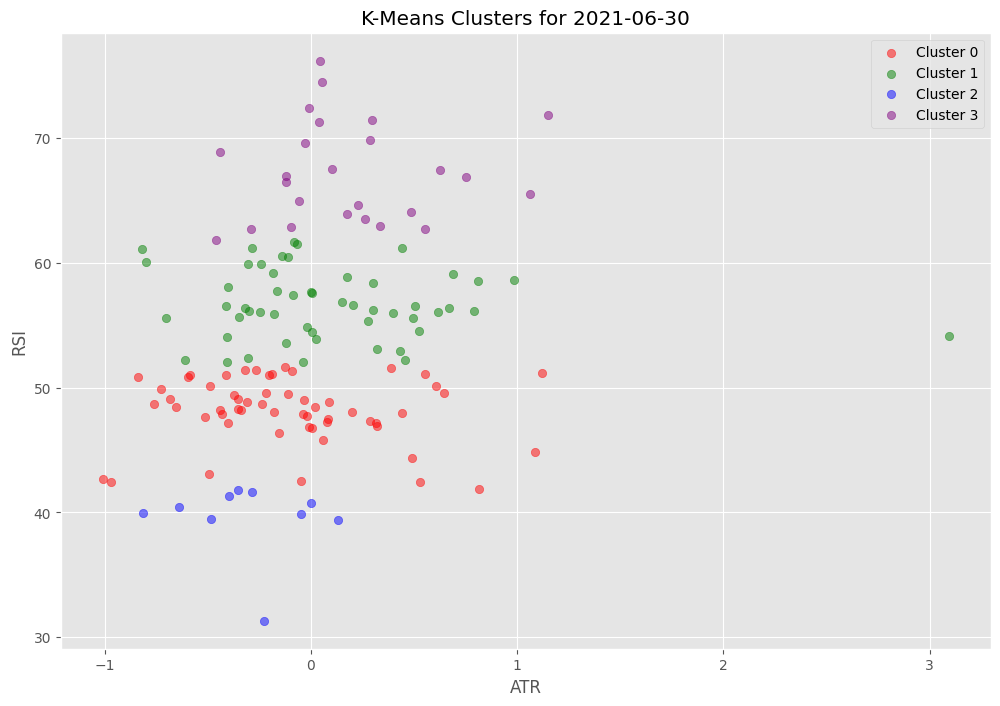

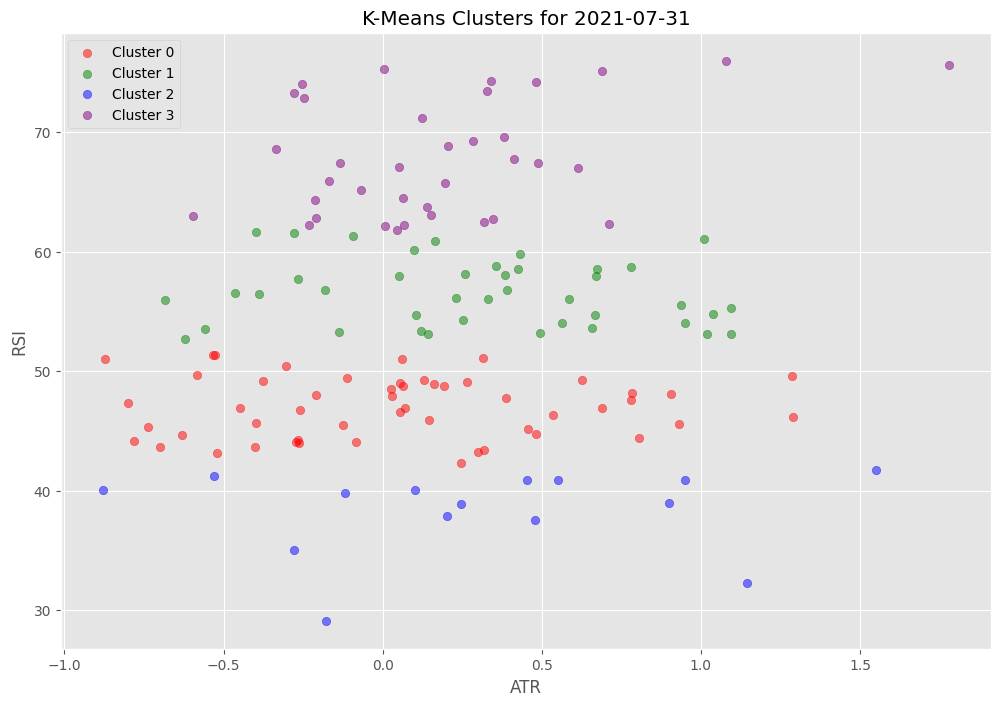

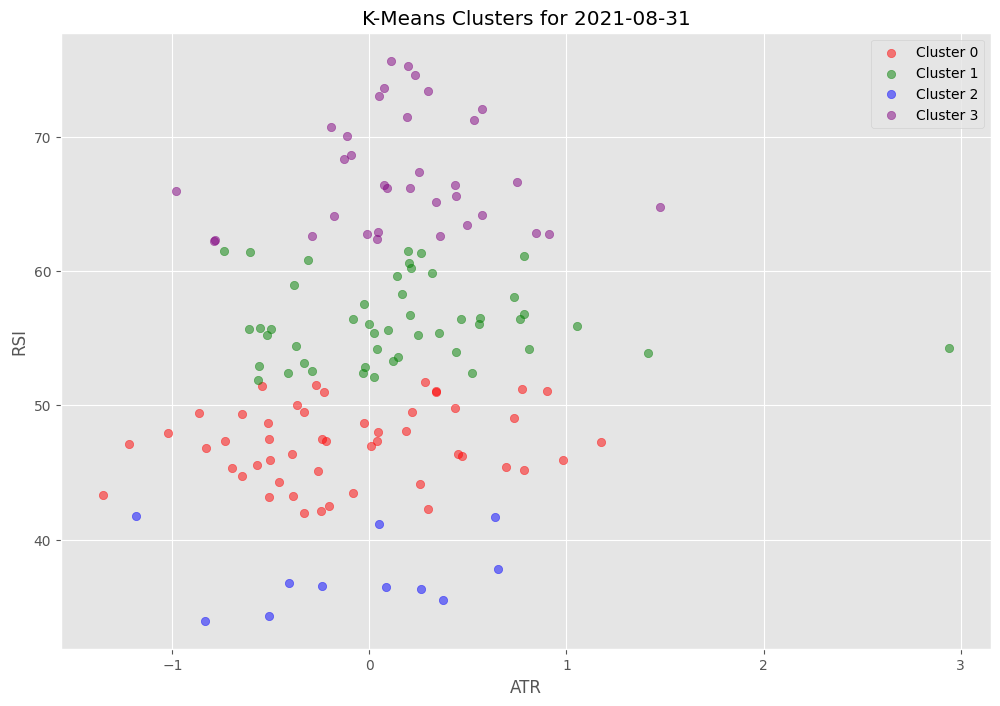

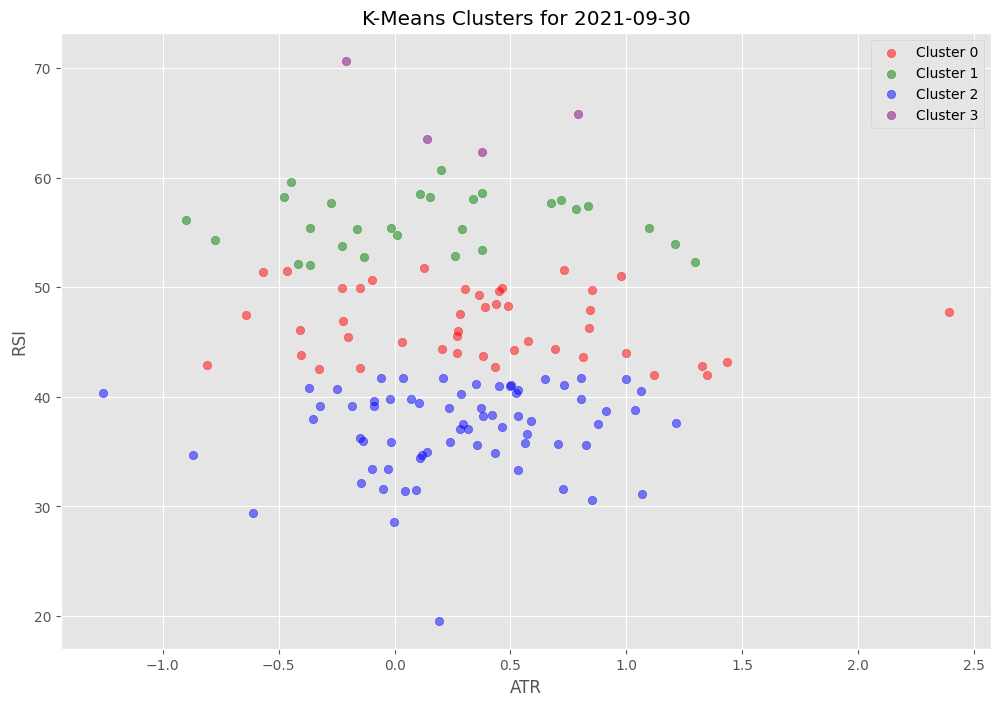

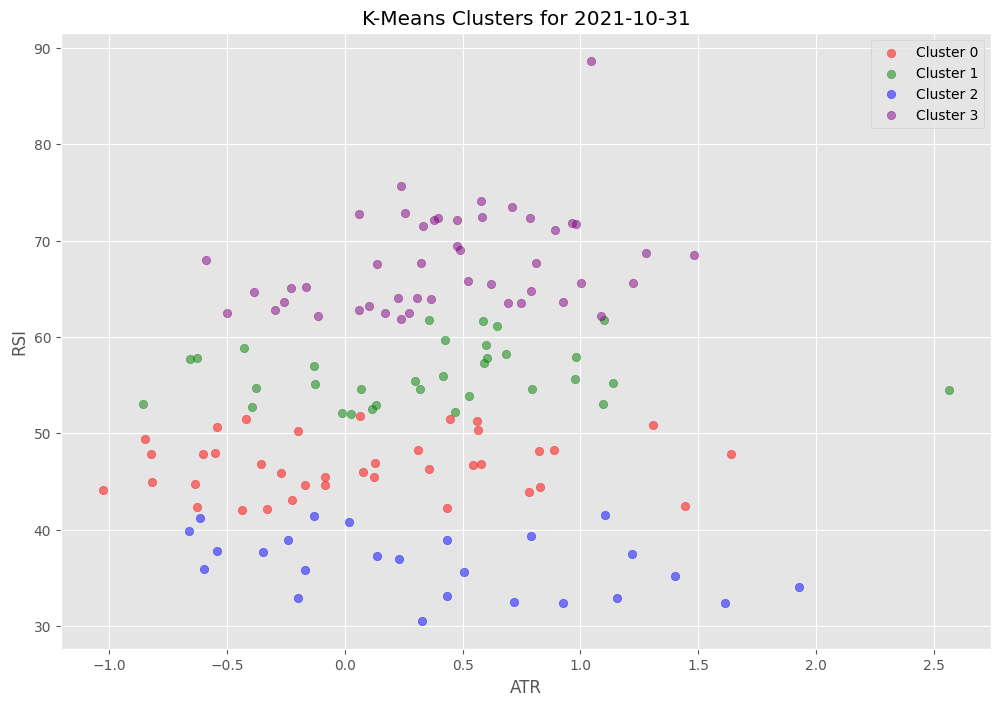

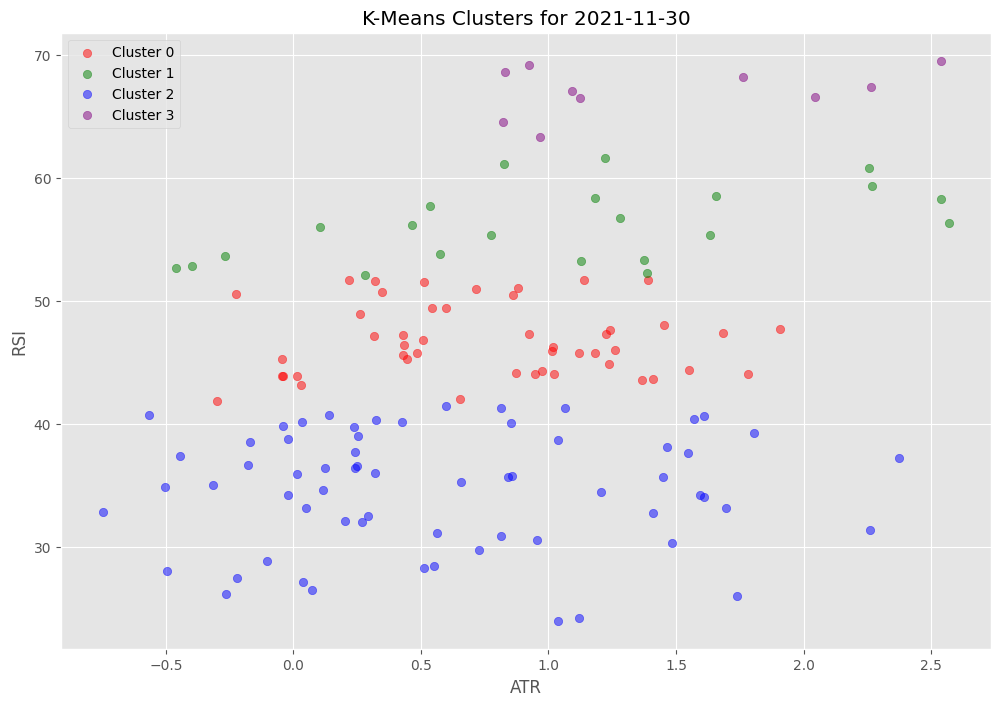

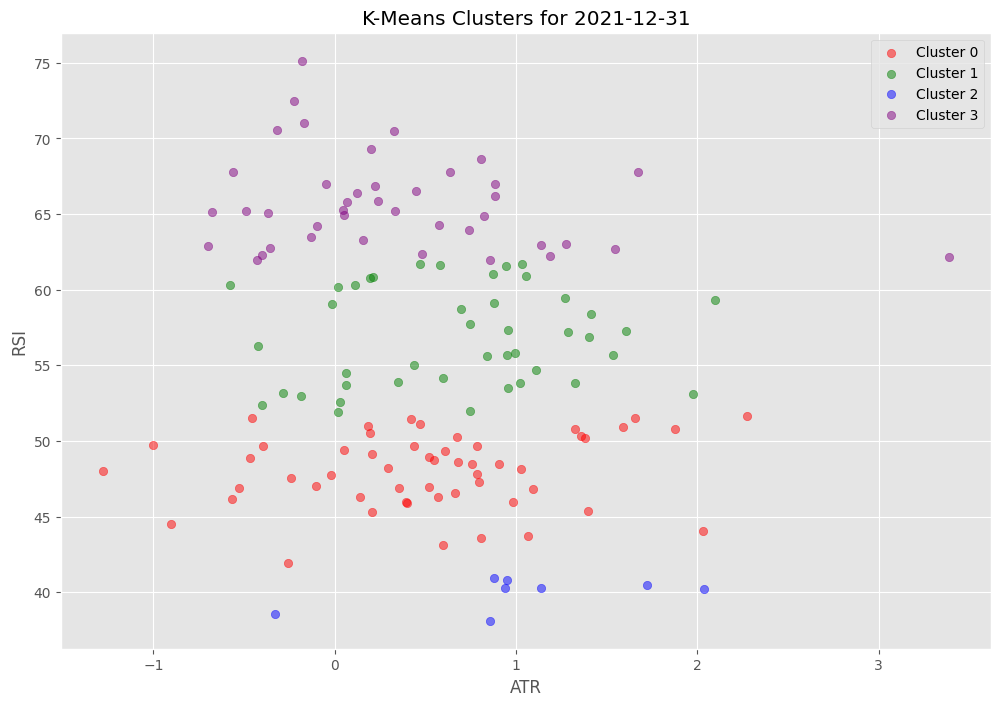

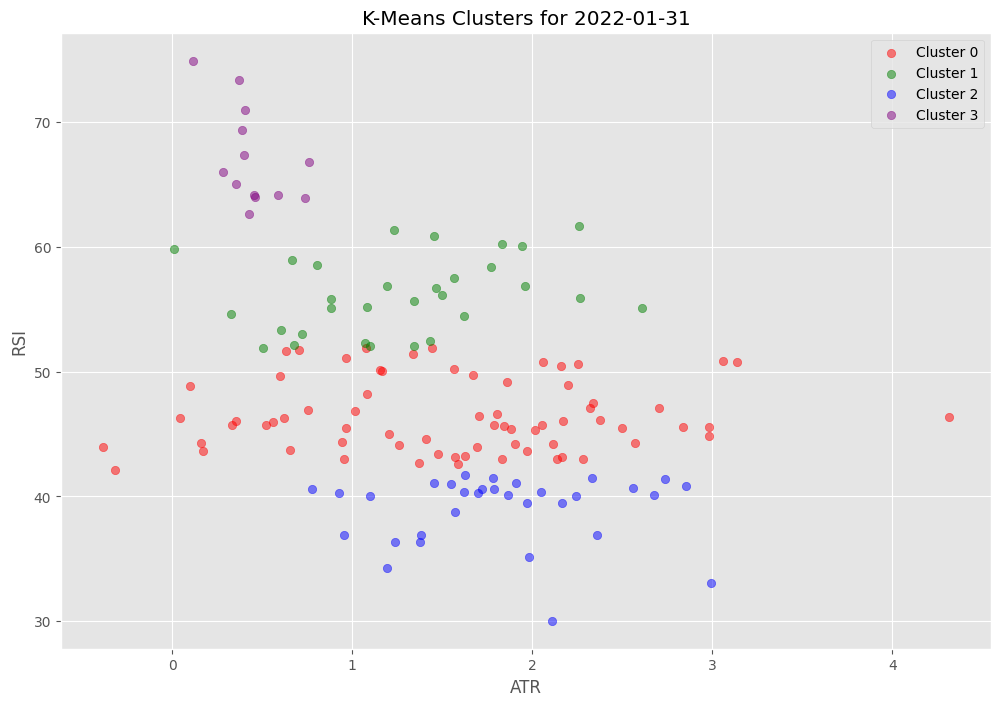

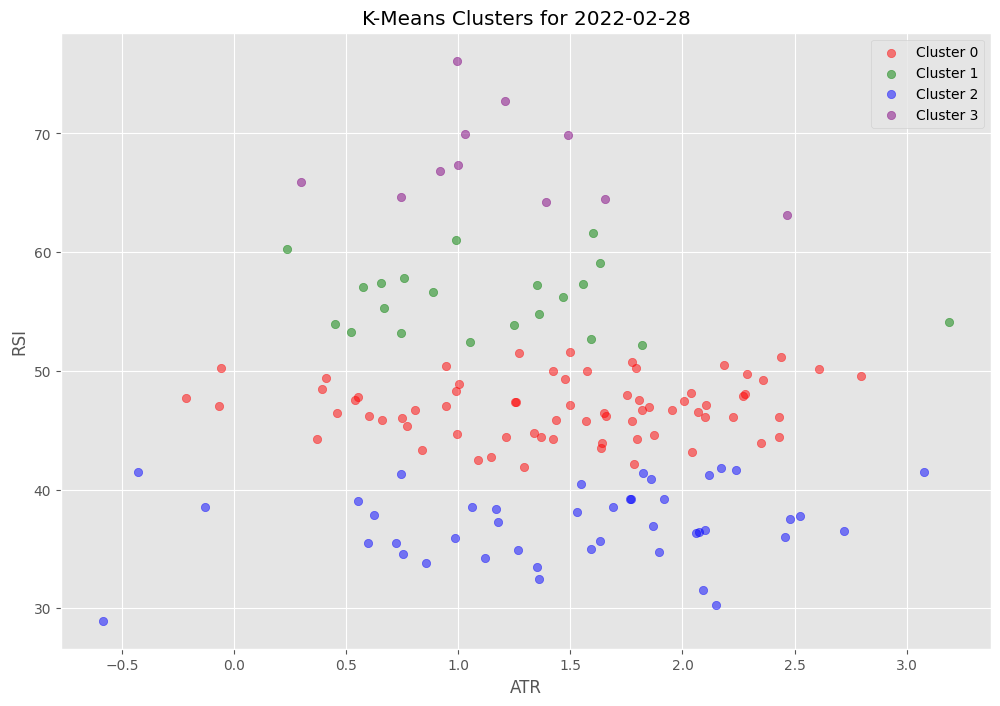

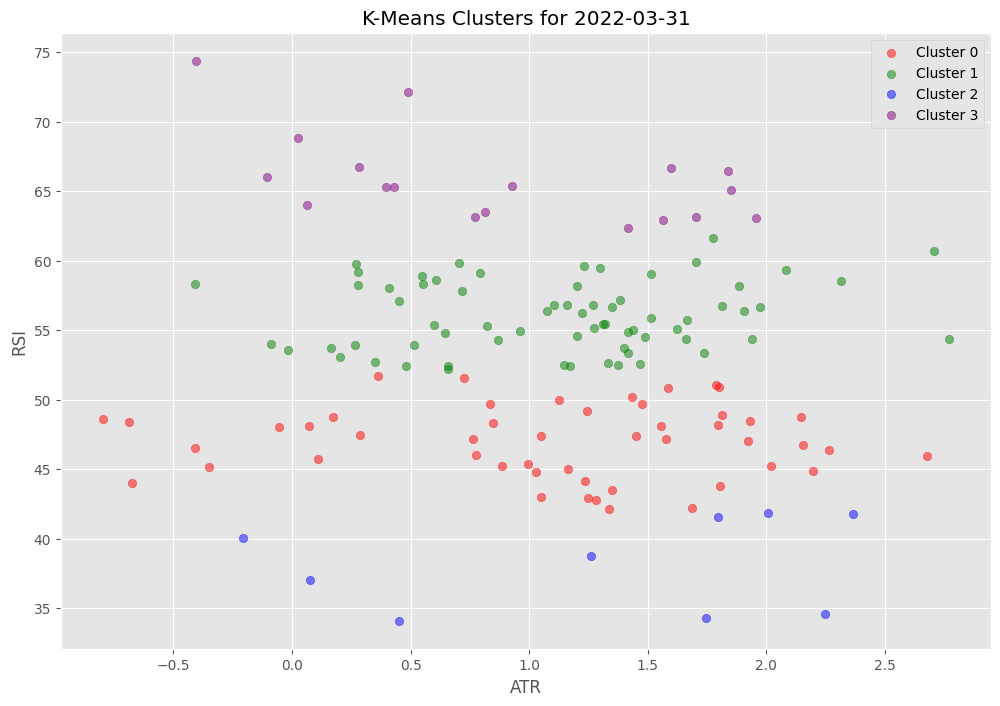

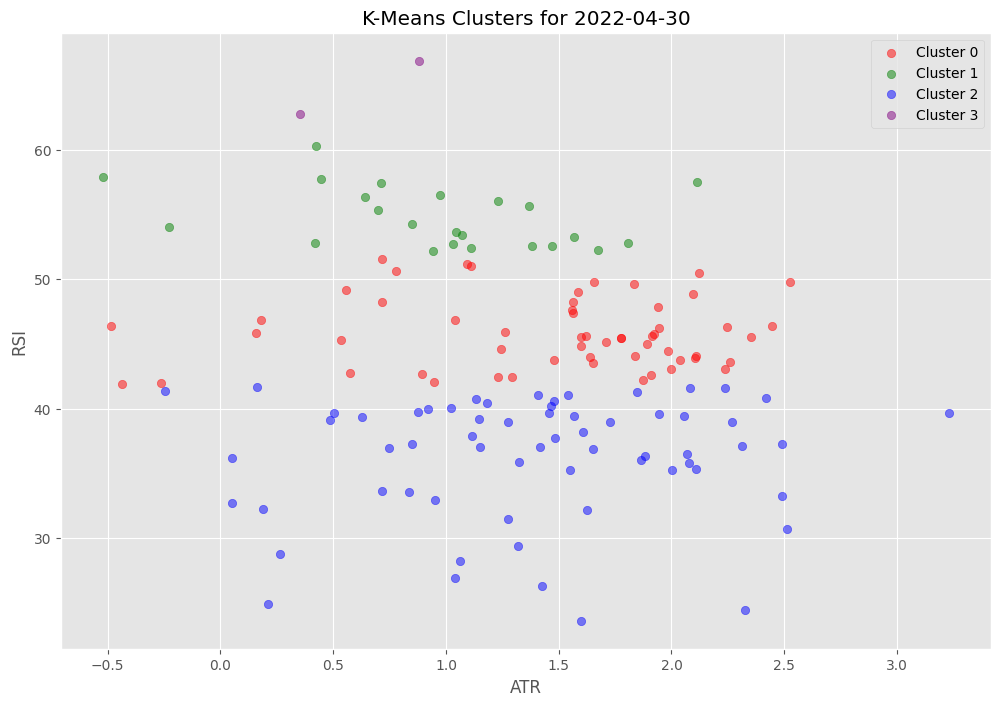

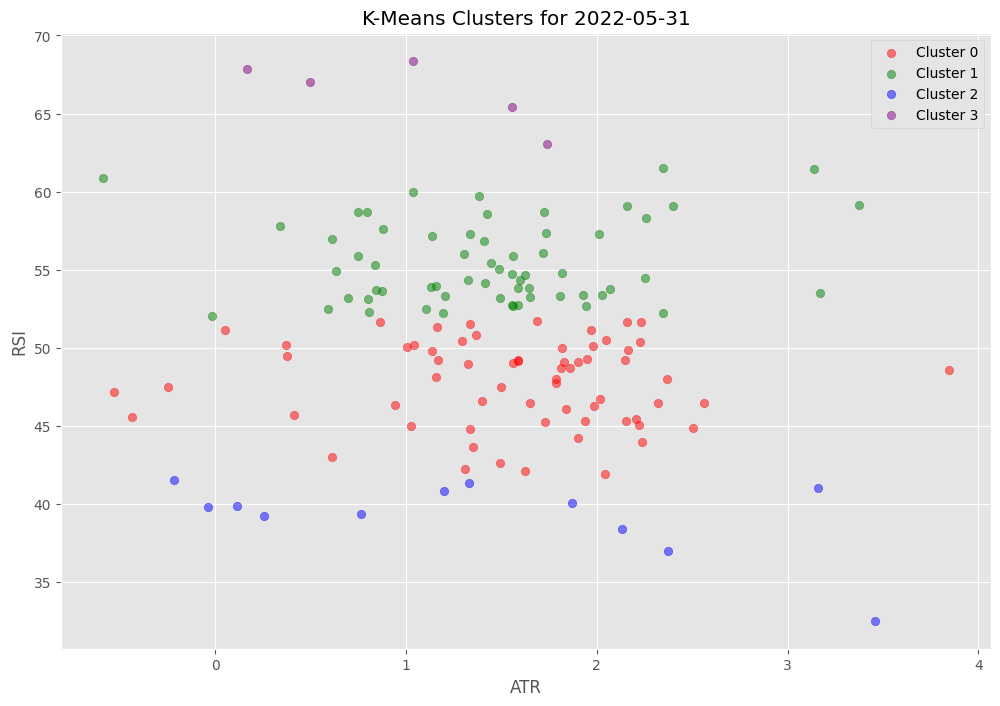

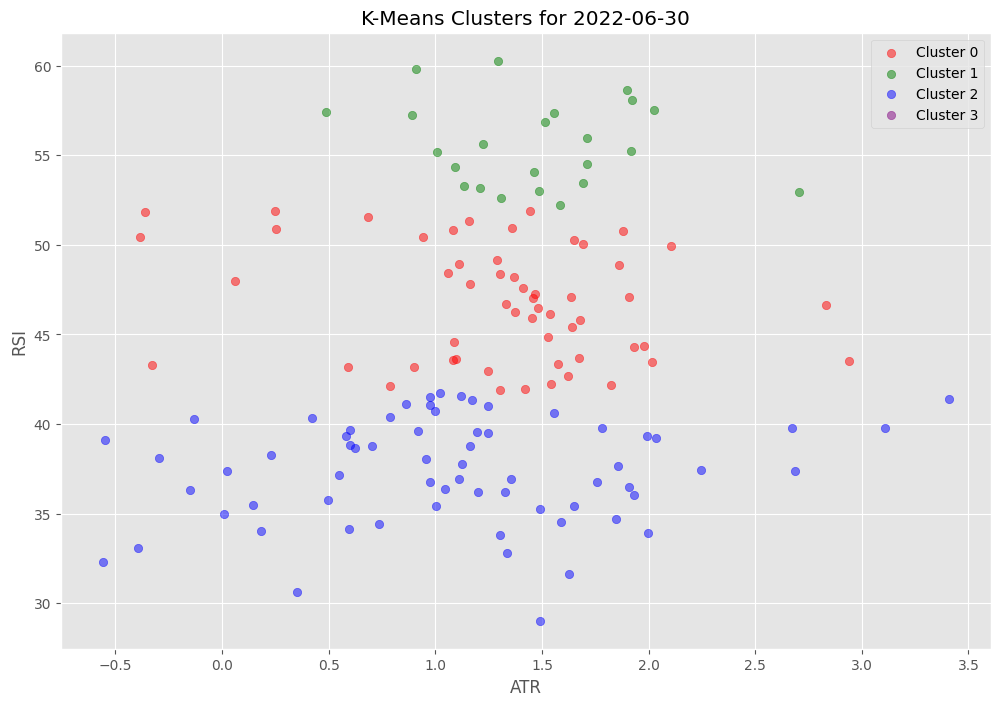

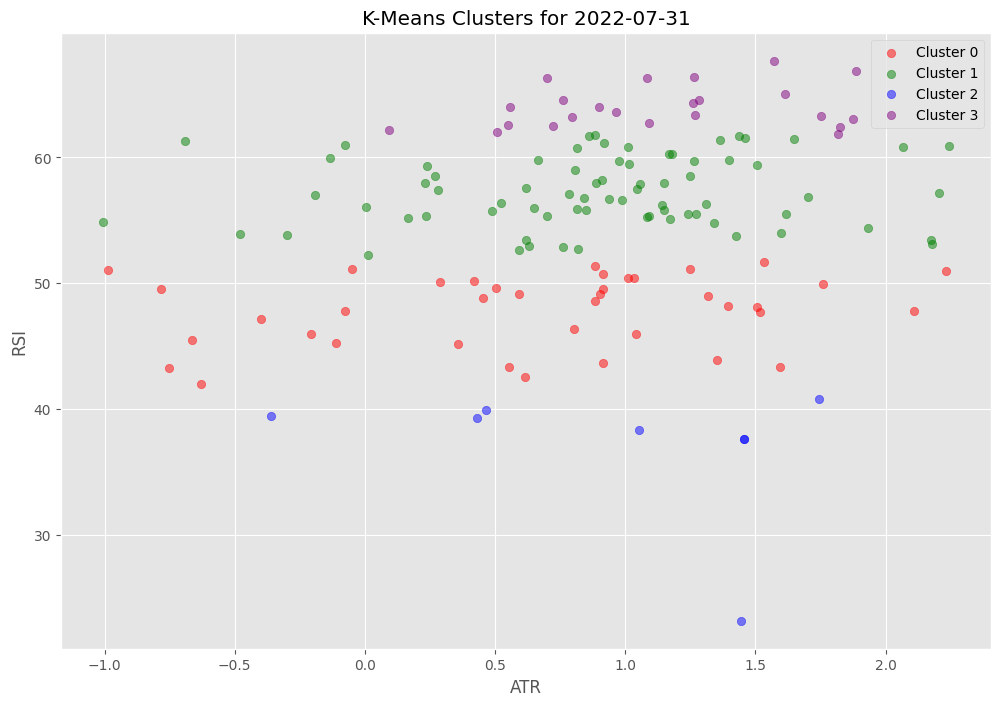

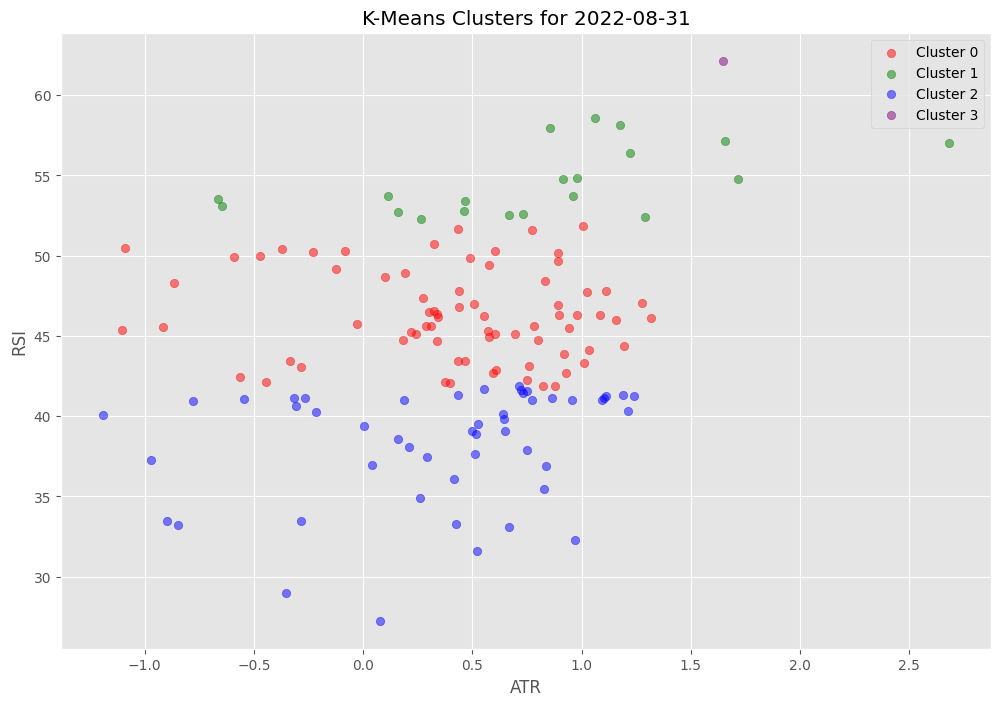

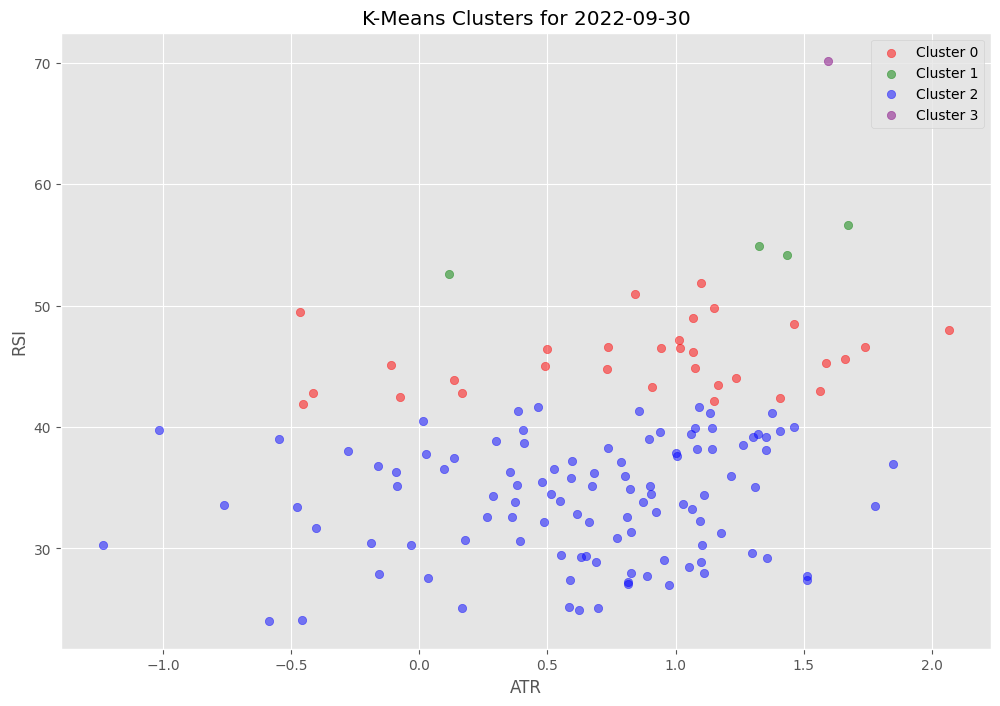

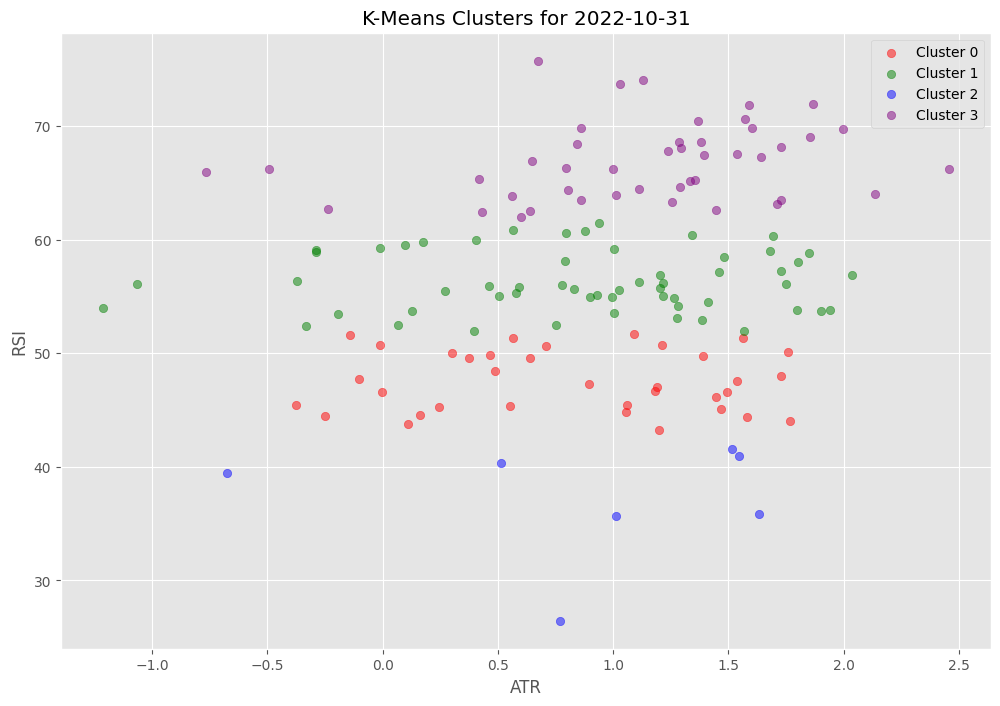

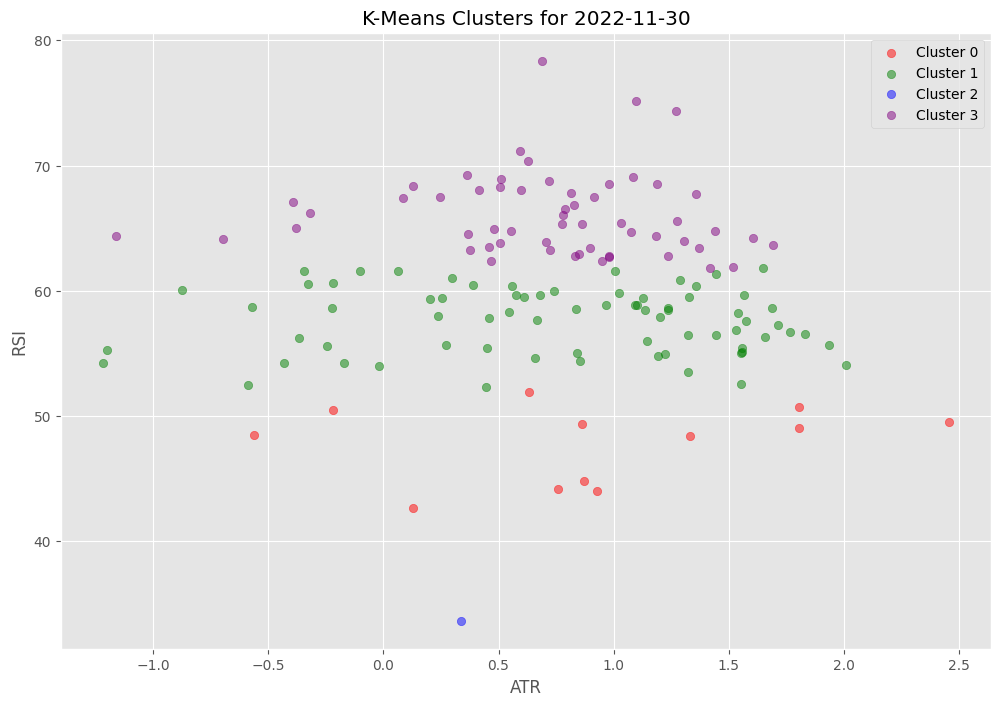

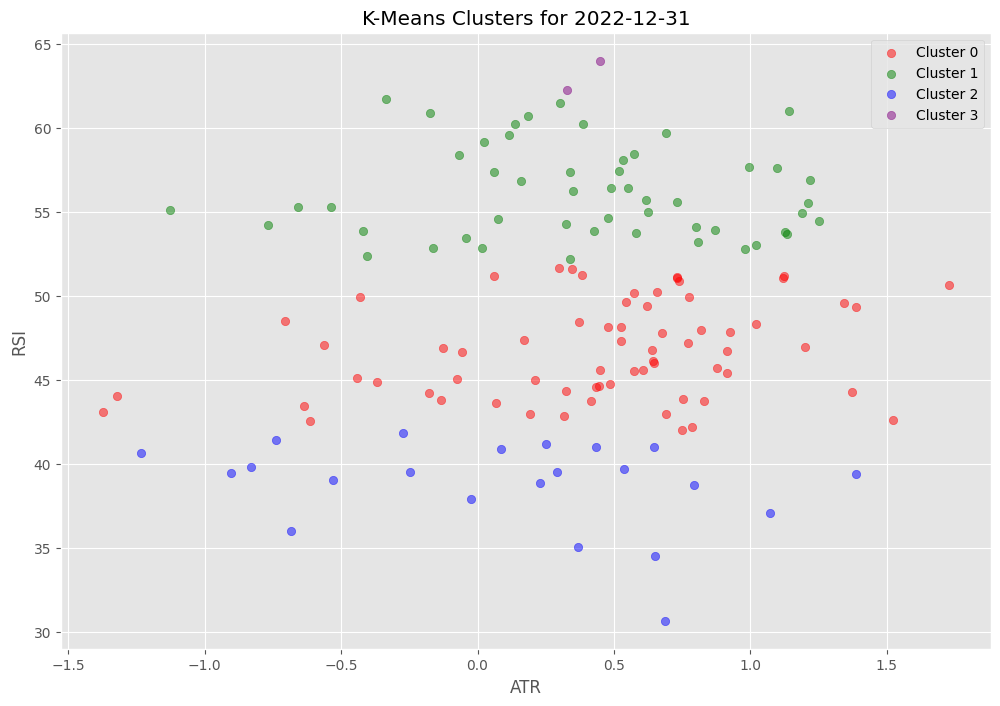

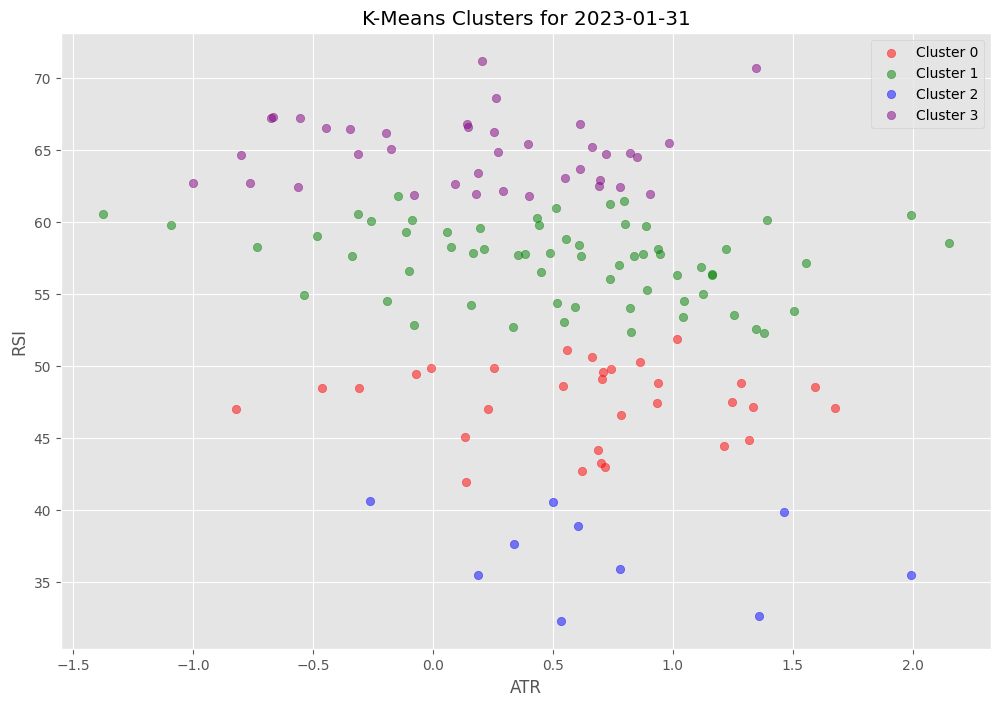

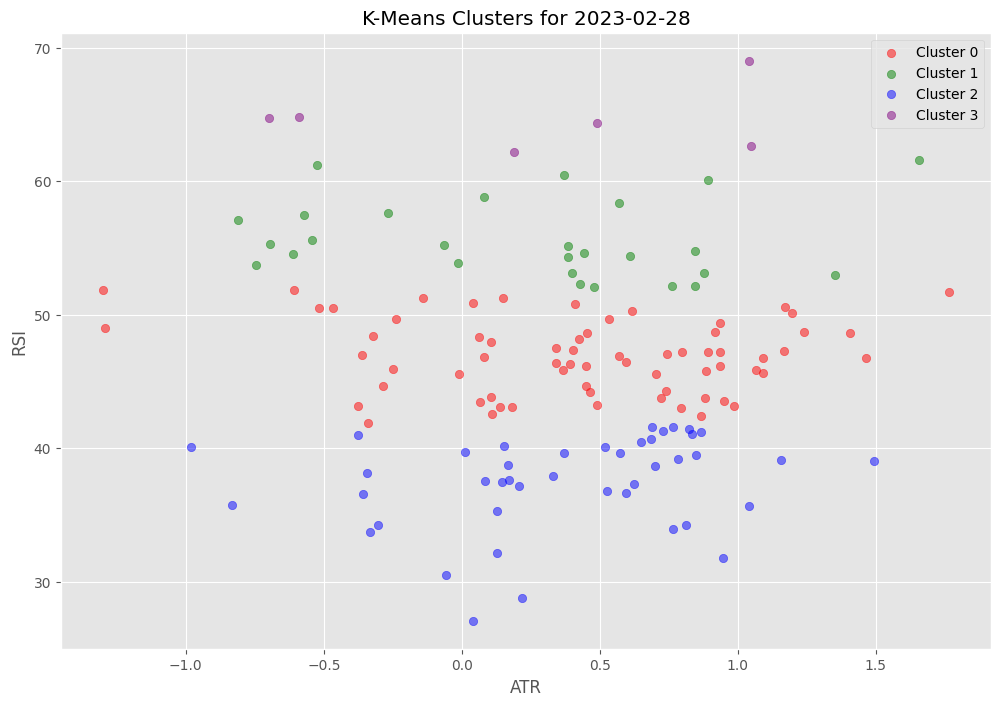

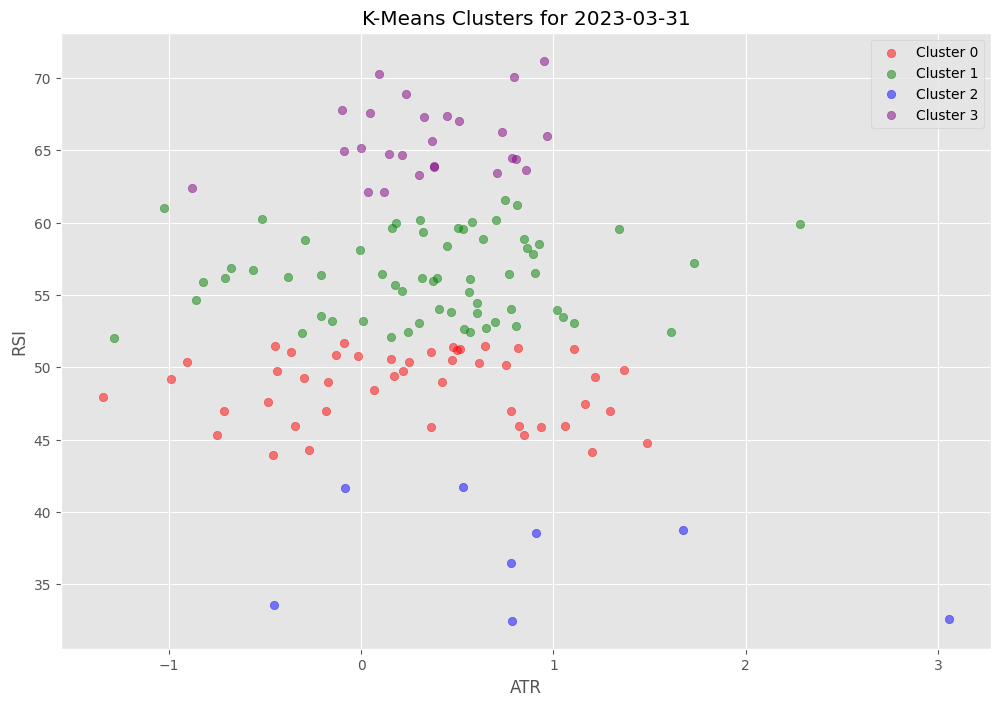

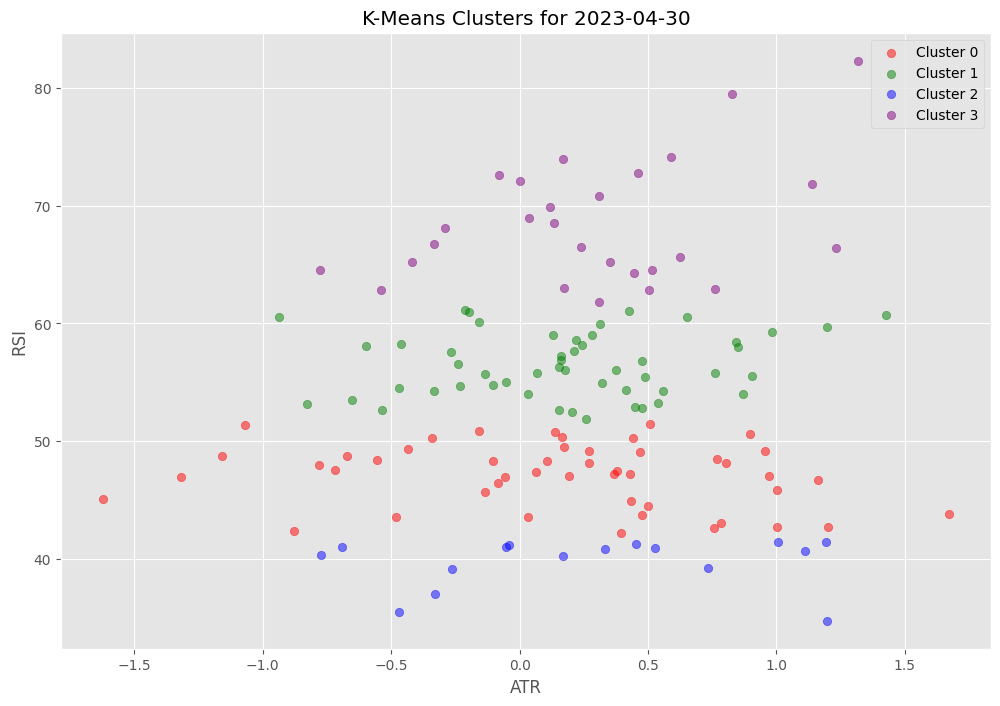

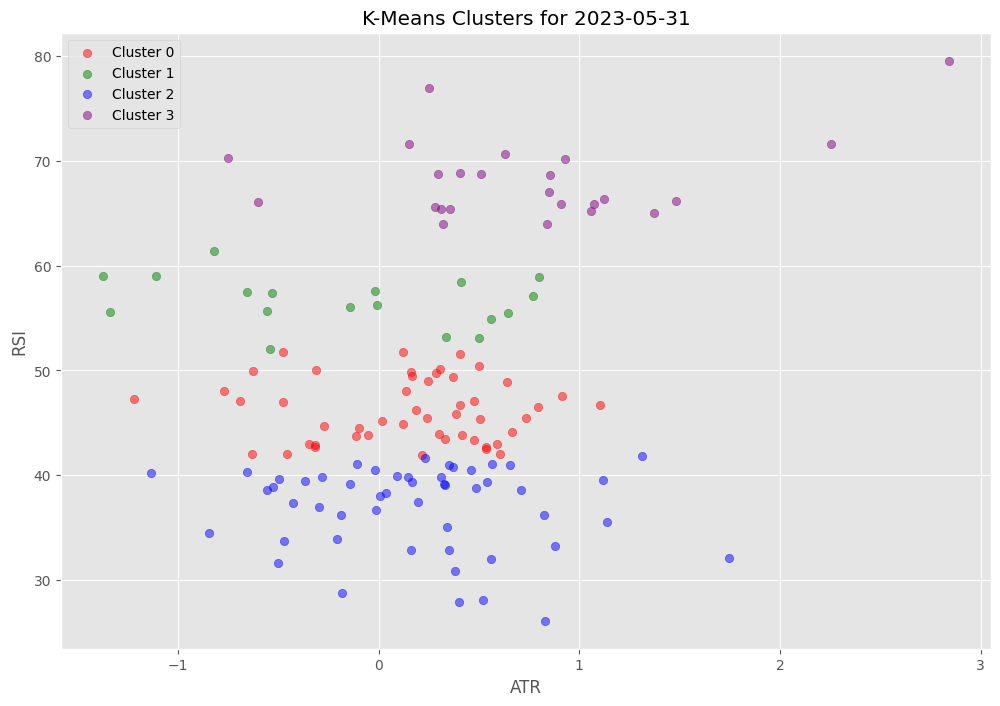

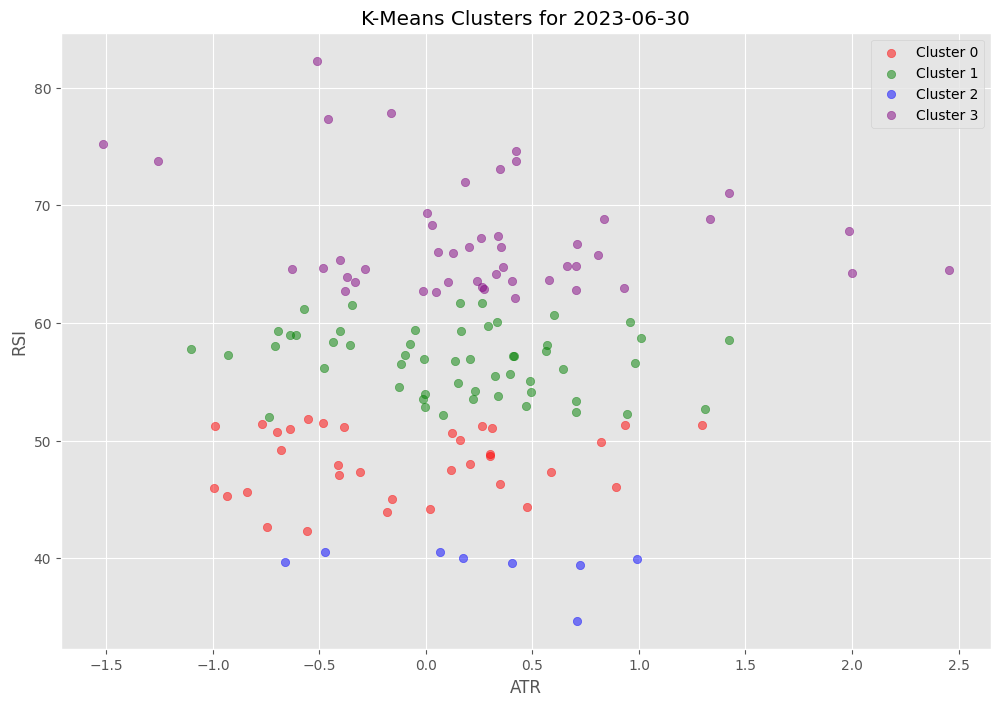

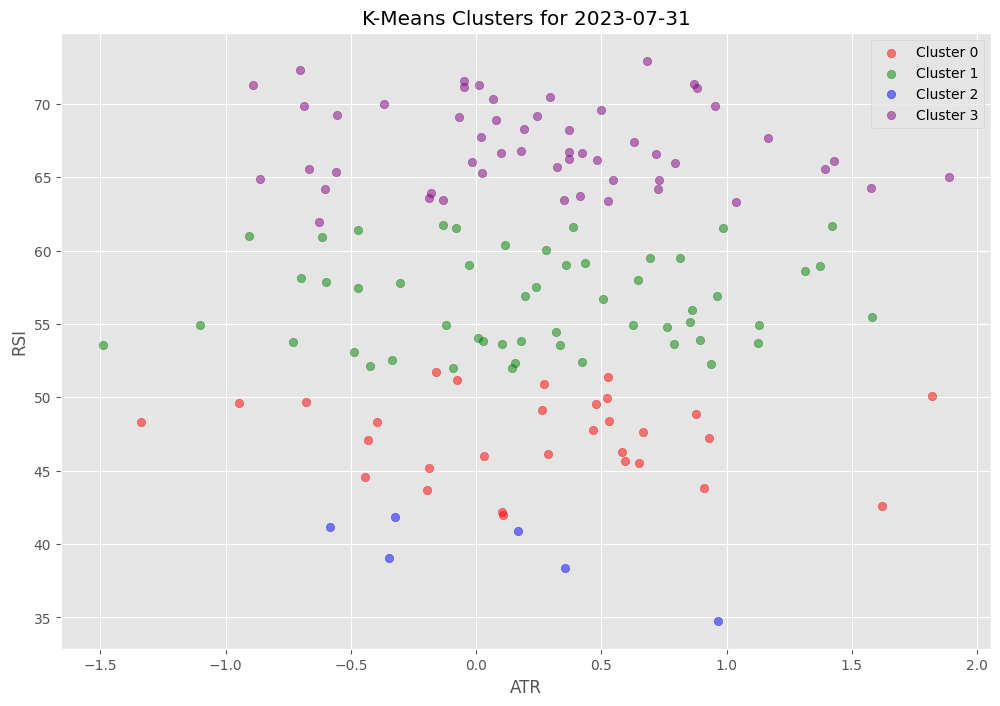

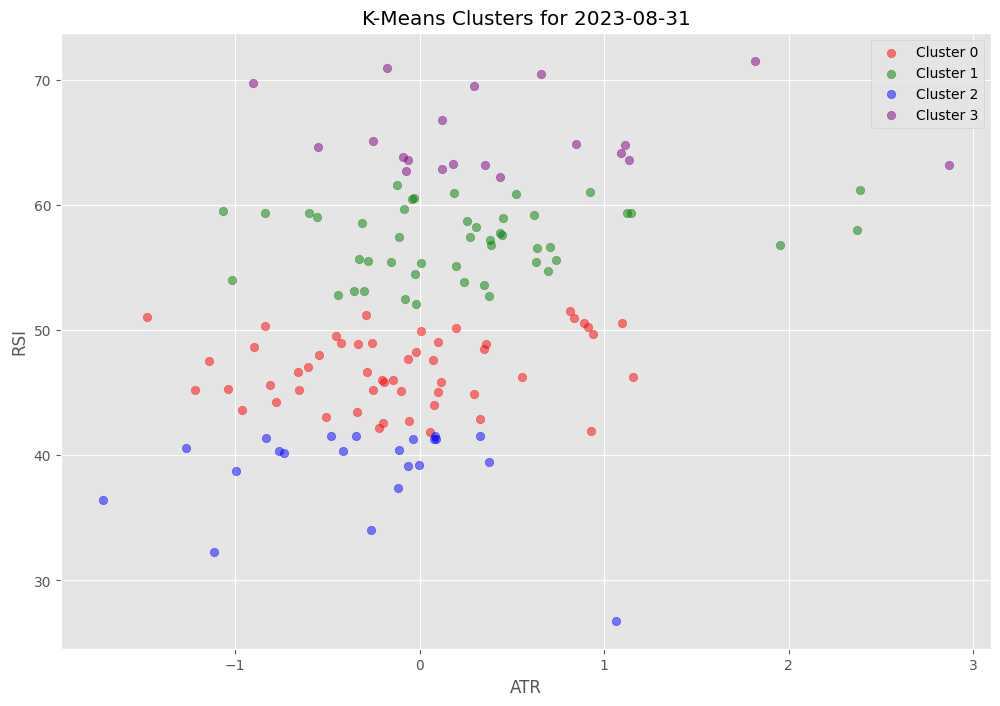

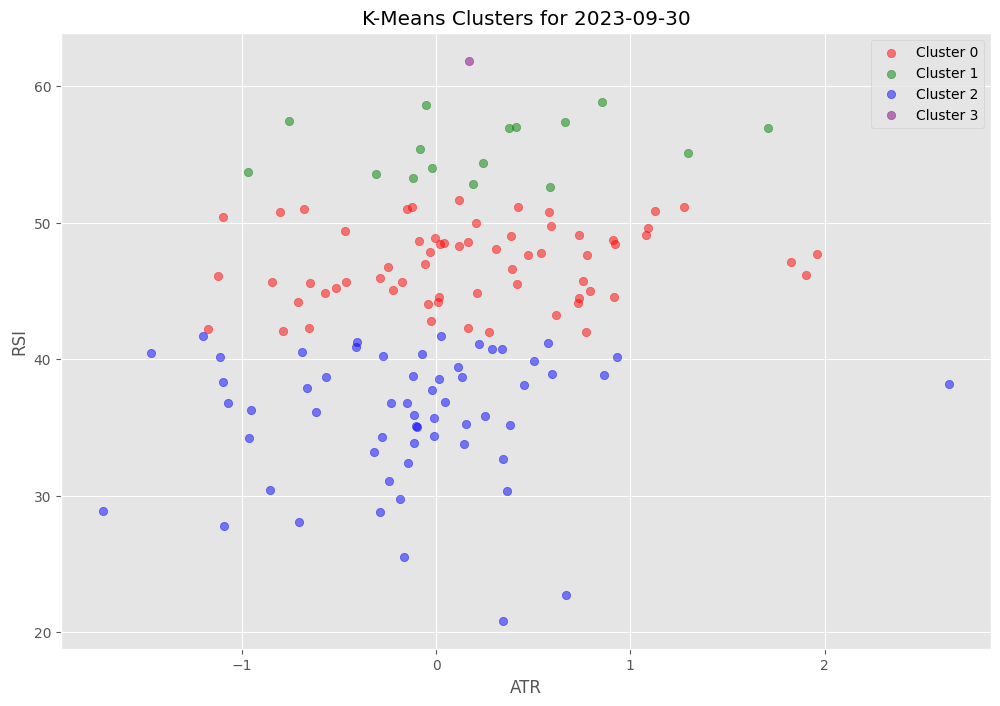

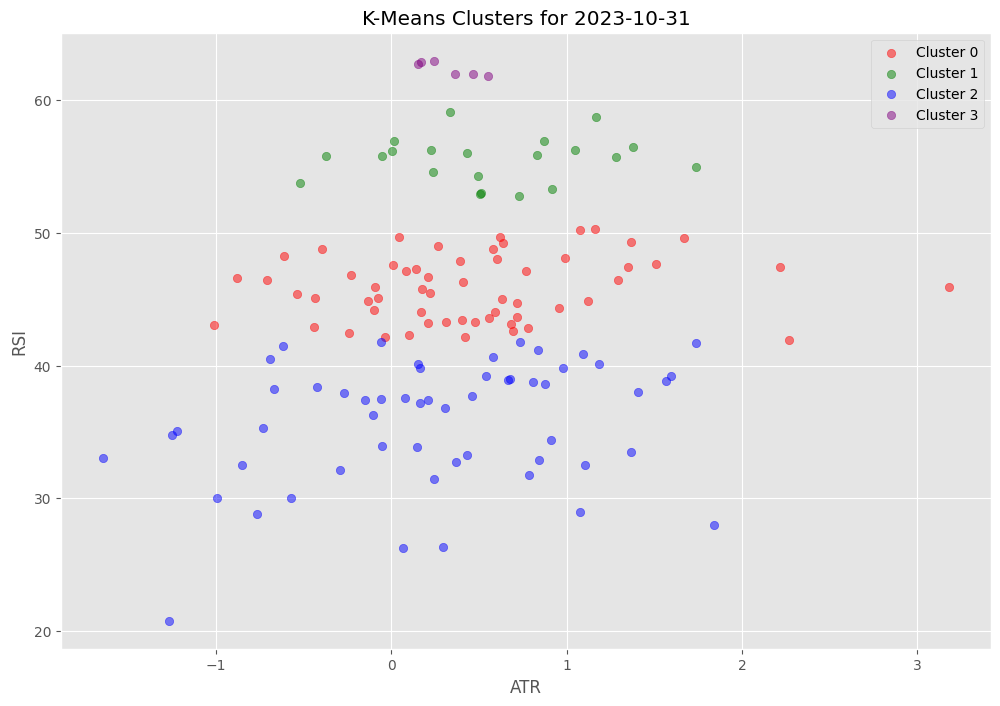

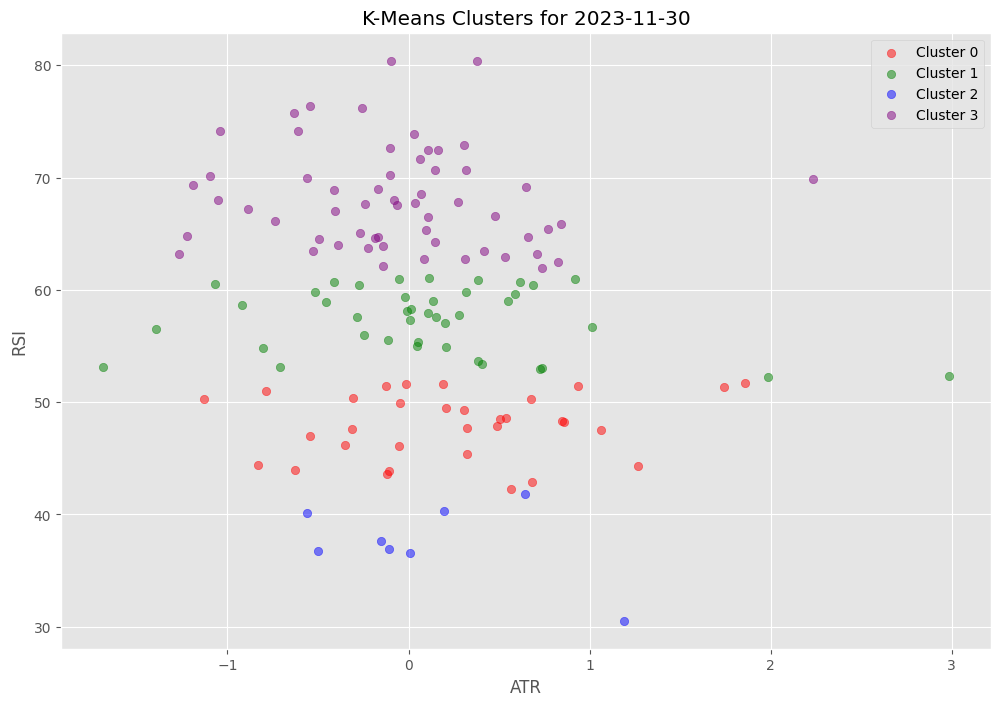

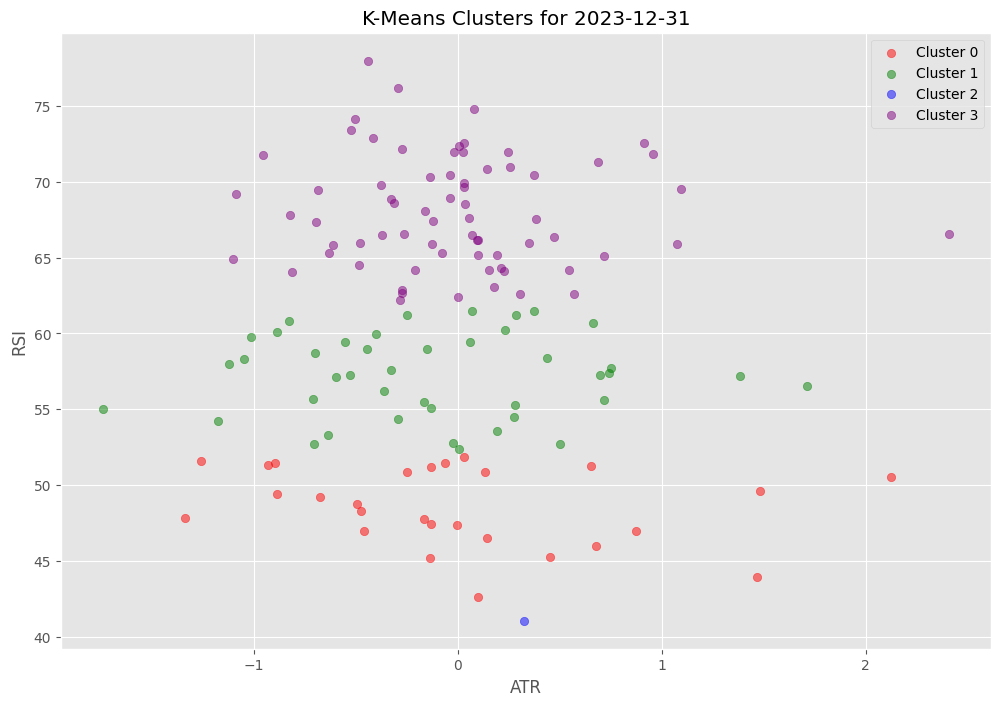

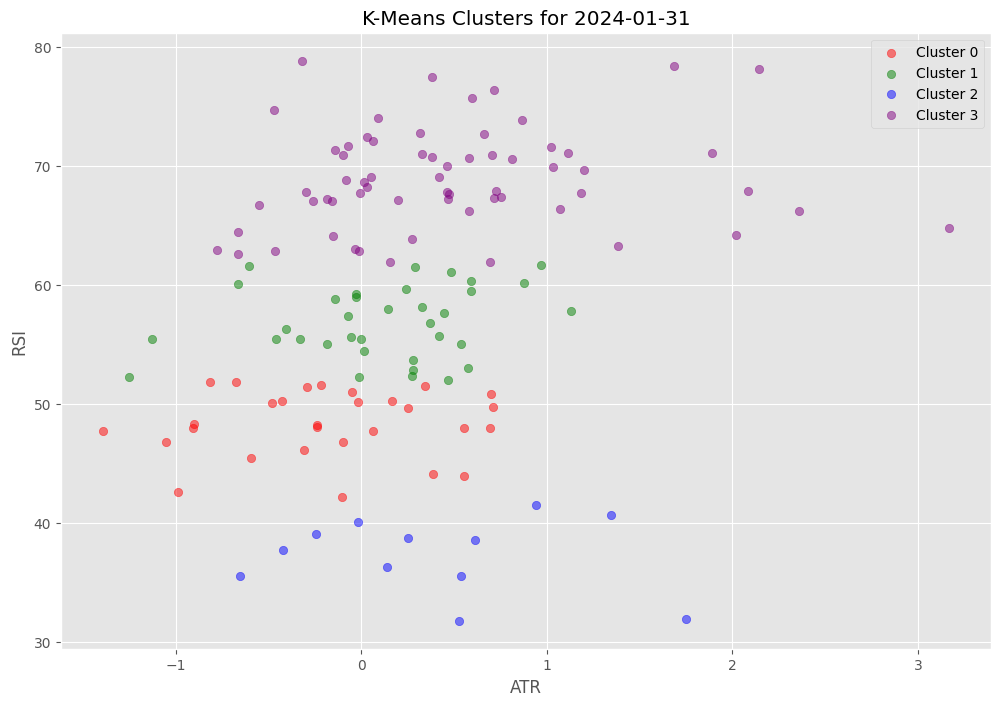

In [184]:
# Visualize the clusters for each month and can get the cluster the model allocates to have the upper bounds of rsi which we are using as the momentum indicator in our project.
start_plot_date = pd.to_datetime("2017-03-31")
end_plot_date = pd.to_datetime("2024-01-31")

dates_to_plot = pd.date_range(start=start_plot_date, end=end_plot_date, freq='M')

# Define a colormap with solid colors for the clusters
colors = ['red', 'green', 'blue', 'purple']
cmap = plt.cm.get_cmap('viridis', 4)
cmap = cmap(np.linspace(0, 1, 4))


for plot_date in dates_to_plot:
    if plot_date not in data.index.levels[0]:
        continue

    monthly_data = data.loc[plot_date]
    plt.figure(figsize=(12, 8))
    for cluster in range(4):
        clustered_data = monthly_data[monthly_data['cluster'] == cluster]
        plt.scatter(clustered_data['atr'], clustered_data['rsi'], color=colors[cluster], label=f'Cluster {cluster}', alpha=0.5)
    plt.title(f'K-Means Clusters for {plot_date.strftime("%Y-%m-%d")}')
    plt.xlabel('ATR')
    plt.ylabel('RSI')
    plt.legend()
    plt.show()

In [185]:
filtered_df = data[data["cluster"] == 3].copy()
filtered_df

garman_klass_vol        rsi       bb_low       bb_mid  \
date       ticker                                                          
2017-03-31 AAPL           -0.000924  72.900304    31.998916    32.810690   
           ADBE            0.000046  78.905856   117.396174   124.693001   
           AMAT           -0.001159  66.527845    34.020927    35.420524   
           AMZN            0.000098  70.465805    41.636906    42.739125   
           BKNG            0.000012  69.754447  1720.473101  1753.725482   
...                             ...        ...          ...          ...   
2024-01-31 WFC             0.000081  66.781175    45.838584    48.324308   
           WMT             0.000088  63.070014    51.866518    53.404134   
           UBER            0.000241  67.109316    56.722615    62.756500   
           CRWD            0.000098  71.050870   240.840662   279.376499   
           ABNB            0.000113  62.968005   129.458910   139.994998   

                       bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                          
2017-03-31 AAPL      33.622463 -1.142533 -0.014057   0.048690   0.090404   
           ADBE     131.989828 -1.267961  0.149264   0.099628   0.071323   
           AMAT      36.820121 -1.148870  0.079727   0.073992   0.067242   
           AMZN      43.841344 -1.337362 -0.007139   0.049110   0.037583   
           BKNG    1786.977864 -1.460831  0.525197   0.032387   0.063036   
...                        ...       ...       ...        ...        ...   
2024-01-31 WFC       50.810031 -0.551295  0.816076   0.040024   0.071455   
           WMT       54.941751 -0.035878  1.104626   0.050365   0.033217   
           UBER      68.790385 -0.257810  1.281652   0.085594   0.088819   
           CRWD     317.912337  0.328222  1.973549   0.180284   0.127640   
           ABNB     150.531086 -0.775295  0.702088   0.097694   0.087584   

                   return_3m  return_6m  return_9m  return_12m    Mkt-RF  \
date       ticker                                                          
2017-03-31 AAPL     0.075995   0.042385   0.048020    0.025068  1.180423   
           ADBE     0.081227   0.030698   0.034628    0.027656  1.087768   
           AMAT     0.065276   0.044434   0.056384    0.053182  1.270179   
           AMZN     0.057395   0.009567   0.024083    0.033986  1.361155   
           BKNG     0.066810   0.032229   0.040201    0.027262  1.149524   
...                      ...        ...        ...         ...       ...   
2024-01-31 WFC      0.091008   0.020218   0.031301    0.009965  1.029342   
           WMT      0.005669   0.007104   0.011564    0.013063  0.519175   
           UBER     0.155890   0.051470   0.086176    0.066321  1.122953   
           CRWD     0.194596   0.109374   0.107674    0.091058  0.522491   
           ABNB     0.081035  -0.003035   0.024991    0.025005  1.442532   

                        SMB       HML       RMW       CMA         RF  cluster  
date       ticker                                                              
2017-03-31 AAPL   -0.249837 -0.574393  0.639784  0.067639  -0.939087        3  
           ADBE   -0.398834 -0.053054 -0.312418 -0.941156 -20.220578        3  
           AMAT    0.548558  0.825825 -0.256356 -0.911573   7.880936        3  
           AMZN   -0.768436 -0.352115 -0.806983 -0.449209 -23.132964        3  
           BKNG   -0.225145  0.692239  0.116567 -0.609823  39.122371        3  
...                     ...       ...       ...       ...        ...      ...  
2024-01-31 WFC     0.194175  1.981542 -0.295178 -1.484406  -0.277930        3  
           WMT     0.192508 -0.754618  0.641414  0.811114  -0.410149        3  
           UBER    0.284971 -0.085751 -1.934036 -0.673074  18.570574        3  
           CRWD   -1.219987 -0.134867 -3.168212 -1.297379   6.031701        3  
           ABNB    0.650971 -0.111480 -1.008460 -0.165464   1.692649        3  

[2152 rows 

In [186]:
#I am going to create a dictionary which will tell use what stocks to invest in the next month based on rsi being a strong indicator of momentum in our model.

#Reset and adjust index
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(["date", "ticker"])

#Create a dictionary mapping each unique date to its corresponding tickers
dates = filtered_df.index.get_level_values("date").unique().tolist()
fixed_dates = {date.strftime("%Y-%m-%d"): filtered_df.xs(date, level=0).index.tolist() for date in dates}

fixed_dates

{'2017-04-01': ['AAPL',
  'ADBE',
  'AMAT',
  'AMZN',
  'BKNG',
  'CMG',
  'DIS',
  'ISRG',
  'MAR',
  'MCD',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NFLX',
  'ORCL',
  'PEP',
  'PM',
  'SBUX',
  'TSLA',
  'WDC',
  'WMT',
  'WYNN'],
 '2017-05-01': ['ABBV',
  'ADBE',
  'AMAT',
  'AMZN',
  'BA',
  'BKNG',
  'BSX',
  'CAT',
  'CHTR',
  'CMCSA',
  'CMG',
  'COST',
  'CRM',
  'CSCO',
  'CSX',
  'CVS',
  'DIS',
  'DLTR',
  'EA',
  'ELV',
  'EXPE',
  'GOOG',
  'GOOGL',
  'HD',
  'HON',
  'ISRG',
  'LOW',
  'MA',
  'MCD',
  'MDT',
  'META',
  'MMM',
  'MSFT',
  'NEE',
  'NXPI',
  'ORCL',
  'PYPL',
  'RTX',
  'SHW',
  'STZ',
  'TMO',
  'TSLA',
  'UNH',
  'UNP',
  'V',
  'WBA',
  'WDC',
  'WMT',
  'WYNN'],
 '2017-06-01': ['ABT',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'BA',
  'BSX',
  'CAT',
  'CHTR',
  'CL',
  'CMCSA',
  'COST',
  'CSX',
  'CTSH',
  'DE',
  'EA',
  'ELV',
  'EXPE',
  'GD',
  'GOOG',
  'GOOGL',
  'HON',
  'ISRG',
  'JNJ',
  'KO',
  'LMT',
  'MA',
  'MAR',
  'MCD',
  'MCK',
  'M

## Portfolio optimization function
1. I will define a function which optimizes portfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.
2. To optimize the weights of a given portfolio I will need to supply the past 1 year prices to the function
3. Apply single stock weight bounds constraint for diversification  

In [209]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

#252 days is one year of trading data
def optimized_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices, frequency=252)
    cov = risk_models.sample_cov(prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, 0.1), solver="SCS")
    weights = ef.max_sharpe()
    return ef.clean_weights()

In [203]:
# Example tickers and data (ensure this matches your actual data)
stocks = data.index.get_level_values("ticker").unique().tolist()
# Download stock data for the required date range
new_df = yf.download(tickers=stocks, start=(data.index.get_level_values("date").unique()[0] - pd.DateOffset(months=12)).strftime('%Y-%m-%d'),end=data.index.get_level_values("date").unique()[-1].strftime('%Y-%m-%d'))
new_df

[*********************100%%**********************]  159 of 159 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV        ABNB         ABT   
Date                                                                    
2016-03-31  39.297947   24.875011   39.729813         NaN   35.695053   
2016-04-01  37.870163   25.103249   39.938480         NaN   36.002266   
2016-04-04  37.726418   25.361149   41.183514         NaN   36.113201   
2016-04-05  37.304790   25.062168   40.717495         NaN   35.874264   
2016-04-06  37.276051   25.324631   41.656483         NaN   36.736126   
...               ...         ...         ...         ...         ...   
2024-01-24  13.930000  193.988998  161.219528  141.190002  109.641670   
2024-01-25  15.360000  193.659882  162.112915  142.110001  111.304558   
2024-01-26  15.130000  191.914474  161.396225  149.619995  110.869049   
2024-01-29  14.940000  191.226273  160.915192  152.699997  112.294373   
2024-01-30  14.530000  187.545975  161.906738  149.440002  112.324074   

Price                                                                  ...  \
Ticker             ACN        ADBE         ADP        ADSK        AIG  ...   
Date                                                                   ...   
2016-03-31  100.343971   93.800003   75.168732   58.310001  43.718437  ...   
2016-04-01  101.170059   95.160004   75.629562   57.770000  44.397877  ...   
2016-04-04  100.430954   94.500000   75.168732   58.189999  44.001541  ...   
2016-04-05   99.239677   94.169998   75.202263   57.110001  43.419170  ...   
2016-04-06   99.709236   95.400002   76.115562   57.779999  43.766975  ...   
...                ...         ...         ...         ...        ...  ...   
2024-01-24  365.872559  606.479980  235.711838  252.660004  68.460419  ...   
2024-01-25  368.887634  622.580017  234.011520  251.750000  68.282242  ...   
2024-01-26  368.024780  613.929993  233.398621  253.070007  68.826675  ...   
2024-01-29  370.286072  630.229980  234.990189  257.230011  68.668289  ...   
2024-01-30  368.252869  627.960022  235.860107  256.470001  69.668068  ...   

Price         Volume                                                  \
Ticker             V      VLO     VRTX        VZ       WBA       WDC   
Date                                                                   
2016-03-31   7490800  5731600  3259400  12428600   3820400   5202100   
2016-04-01  10183400  4441900  3638700  13807100   6502500   4007900   
2016-04-04   6905800  3466400  2744000  11402700   5114600   3553700   
2016-04-05   6012000  3946700  2849000  12979100   9433900   6061600   
2016-04-06   6220400  8103500  3460300  12993600   8017000   6531700   
...              ...      ...      ...       ...       ...       ...   
2024-01-24   5021700  3140800  1670900  27910400   9246400   9723800   
2024-01-25   6894900  5293300  1230600  24613200  14707700  23848700   
2024-01-26   8586500  5286000   944500  20367200  10150200  19645800   
2024-01-29   6574500  3464000  1004100  23905700  12197400   9380300   
2024-01-30   6549000  4304100  3329900  20044600  11689100   9717100   

Price                                              
Ticker           WFC       WMT     WYNN       XOM  
Date                                               
2016-03-31  16397600  18850500  2973100  13896900  
2016-04-01  14321400  19807200  4545000  12235300  
2016-04-04  12110200  20470200  2755000   8050200  
2016-04-05  18297700  17337000  4427100  10446800  
2016-04-06  17214400  16088100  7577100   9320200  
...              ...       ...      ...       ...  
2024-01-24  17776000  22932900  2318700  17330600  
2024-01-25  17979600  16369500  2568600  22089500  
2024-01-26  19211100  15746400  1465200  20817200  
2024-01-29  16725200  18240300  1261800  18317500  
2024-01-30  14736800  15270000  1388400  19610900  

[1972 rows x 954 columns]

1. Calculate daily returns for each stock which could land up in our portfolio.
2. Then loop over each month start, select the stocks for the month and calculate their weights for the next month.
3. If the maximum sharpe ratio optimization fails for a given months, apply equally-weighted weights.
4. Calculated each day portfolio return


In [210]:
return_df = np.log(new_df["Adj Close"]).diff()
return_df

Ticker           AAL      AAPL      ABBV      ABNB       ABT       ACN  \
Date                                                                     
2016-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
2016-04-01 -0.037009  0.009134  0.005238       NaN  0.008570  0.008199   
2016-04-04 -0.003803  0.010221  0.030698       NaN  0.003077 -0.007332   
2016-04-05 -0.011239 -0.011859 -0.011380       NaN -0.006638 -0.011933   
2016-04-06 -0.000771  0.010418  0.022799       NaN  0.023740  0.004720   
...              ...       ...       ...       ...       ...       ...   
2024-01-24 -0.005013 -0.003490 -0.019776 -0.007831 -0.028743 -0.002599   
2024-01-25  0.097722 -0.001698  0.005526  0.006495  0.015053  0.008207   
2024-01-26 -0.015087 -0.009054 -0.004431  0.051497 -0.003920 -0.002342   
2024-01-29 -0.012637 -0.003592 -0.002985  0.020376  0.012774  0.006126   
2024-01-30 -0.027827 -0.019433  0.006143 -0.021580  0.000264 -0.005506   

Ticker          ADBE       ADP      ADSK       AIG  ...         V       VLO  \
Date                                                ...                       
2016-03-31       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2016-04-01  0.014395  0.006112 -0.009304  0.015422  ...  0.014409 -0.019363   
2016-04-04 -0.006960 -0.006112  0.007244 -0.008967  ...  0.003089  0.006023   
2016-04-05 -0.003498  0.000446 -0.018734 -0.013324  ... -0.011111 -0.002373   
2016-04-06  0.012977  0.012071  0.011663  0.007978  ...  0.015982 -0.023395   
...              ...       ...       ...       ...  ...       ...       ...   
2024-01-24  0.015453 -0.008020 -0.000475  0.002316  ...  0.001437  0.008023   
2024-01-25  0.026200 -0.007240 -0.003608 -0.002606  ...  0.003528  0.032579   
2024-01-26 -0.013991 -0.002623  0.005230  0.007942  ... -0.017279  0.025335   
2024-01-29  0.026204  0.006796  0.016305 -0.002304  ...  0.021123  0.003402   
2024-01-30 -0.003608  0.003695 -0.002959  0.014455  ...  0.012672  0.025049   

Ticker          VRTX        VZ       WBA       WDC       WFC       WMT  \
Date                                                                     
2016-03-31       NaN       NaN       NaN       NaN       NaN       NaN   
2016-04-01 -0.004286 -0.001295  0.028784 -0.013641  0.001859  0.008288   
2016-04-04  0.045928  0.007563 -0.004508 -0.007107  0.001032  0.000579   
2016-04-05  0.015447 -0.006083 -0.034777 -0.047354 -0.020624 -0.006679   
2016-04-06  0.081540 -0.000093  0.003951  0.013281  0.011926  0.005810   
...              ...       ...       ...       ...       ...       ...   
2024-01-24 -0.027998 -0.022753 -0.009344  0.005183  0.007504 -0.014228   
2024-01-25  0.005598  0.024173  0.032545  0.038869  0.007849  0.014474   
2024-01-26  0.000488  0.002598 -0.011314 -0.035429  0.008783  0.008743   
2024-01-29  0.013049 -0.008289 -0.005706  0.025769  0.000596  0.004676   
2024-01-30  0.023269  0.009939  0.001759 -0.027659  0.016546  0.003327   

Ticker          WYNN       XOM  
Date                            
2016-03-31       NaN       NaN  
2016-04-01  0.013924 -0.007565  
2016-04-04 -0.014245  0.002408  
2016-04-05 -0.026911 -0.011490  
2016-04-06 -0.015183  0.013292  
...              ...       ...  
2024-01-24  0.012594  0.017113  
2024-01-25  0.022235  0.025084  
2024-01-26  0.003314  0.008483  
2024-01-29  0.003406  0.001261  
2024-01-30 -0.021558  0.016540  

[1972 rows x 159 columns]

In [211]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")
    cols = fixed_dates[start_date]
    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime("%Y-%m-%d")
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime("%Y-%m-%d")
    print(f"Start Date: {start_date}")
    print(f"End Date: {end_date}")
    print(f"Columns: {cols}")
    print(f"Optimization Start Date: {optimization_start_date}")
    print(f"Optimization End Date: {optimization_end_date}")
    print("\n")



Start Date: 2017-04-01
End Date: 2017-04-30
Columns: ['AAPL', 'ADBE', 'AMAT', 'AMZN', 'BKNG', 'CMG', 'DIS', 'ISRG', 'MAR', 'MCD', 'META', 'MMM', 'MSFT', 'MU', 'NFLX', 'ORCL', 'PEP', 'PM', 'SBUX', 'TSLA', 'WDC', 'WMT', 'WYNN']
Optimization Start Date: 2016-04-01
Optimization End Date: 2017-03-31


Start Date: 2017-05-01
End Date: 2017-05-31
Columns: ['ABBV', 'ADBE', 'AMAT', 'AMZN', 'BA', 'BKNG', 'BSX', 'CAT', 'CHTR', 'CMCSA', 'CMG', 'COST', 'CRM', 'CSCO', 'CSX', 'CVS', 'DIS', 'DLTR', 'EA', 'ELV', 'EXPE', 'GOOG', 'GOOGL', 'HD', 'HON', 'ISRG', 'LOW', 'MA', 'MCD', 'MDT', 'META', 'MMM', 'MSFT', 'NEE', 'NXPI', 'ORCL', 'PYPL', 'RTX', 'SHW', 'STZ', 'TMO', 'TSLA', 'UNH', 'UNP', 'V', 'WBA', 'WDC', 'WMT', 'WYNN']
Optimization Start Date: 2016-05-01
Optimization End Date: 2017-04-30


Start Date: 2017-06-01
End Date: 2017-06-30
Columns: ['ABT', 'ACN', 'ADBE', 'AMAT', 'AMZN', 'BA', 'BSX', 'CAT', 'CHTR', 'CL', 'CMCSA', 'COST', 'CSX', 'CTSH', 'DE', 'EA', 'ELV', 'EXPE', 'GD', 'GOOG', 'GOOGL', 'HON', '

In [212]:
portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime("%Y-%m-%d")
    cols = fixed_dates[start_date]
    optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime("%Y-%m-%d")
    optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime("%Y-%m-%d")
    #we are calculating the weights of each stock in the monthly optimization dataframe.
    weights = optimized_weights(prices = optimization_df,lower_bound=lower_bound)
    weights = pd.DataFrame(weights,index = pd.Series(0))
    temp_df = return_df[start_date:end_date]
    temp_df = temp_df.stack().to_frame("returns").reset_index(level=0).merge(weights.stack().to_frame("weights").reset_index(level=0,drop=True),left_index = True,right_index = True).reset_index().set_index(["Date","Ticker"])
    temp_df["weighted_returns"] = temp_df["returns"]*temp_df["weights"] 
    temp_df = temp_df.groupby(level = 0)["weighted_returns"].sum().to_frame("Strategy Returns")
    portfolio_df = pd.concat([portfolio_df,temp_df], axis = 0)
portfolio_df

Strategy Returns
Date                        
2017-04-03          0.001517
2017-04-04          0.002060
2017-04-05         -0.004659
2017-04-06          0.001094
2017-04-07          0.001180
...                      ...
2024-01-24          0.009168
2024-01-25          0.004175
2024-01-26         -0.005010
2024-01-29          0.011644
2024-01-30         -0.008576

[1656 rows x 1 columns]

In [207]:
# 2016-04-01 is one year before the start date in our data set above which will be used as the optimization dataframe to calculate the weights 
optimization_df = new_df["2016-04-01":"2017-03-31"]["Adj Close"][fixed_dates["2017-04-01"]]
optimization_df

Ticker           AAPL        ADBE       AMAT       AMZN         BKNG     CMG  \
Date                                                                           
2016-04-01  25.103249   95.160004  19.445398  29.924999  1293.405273  9.2962   
2016-04-04  25.361149   94.500000  19.218443  29.659500  1275.552124  9.3000   
2016-04-05  25.062168   94.169998  19.018724  29.306999  1272.885010  9.2684   
2016-04-06  25.324631   95.400002  19.118587  30.104000  1286.747681  9.1050   
2016-04-07  24.772312   93.779999  18.882557  29.571501  1270.317627  9.0120   
...               ...         ...        ...        ...          ...     ...   
2017-03-27  32.833061  128.250000  35.769840  42.341000  1763.417847  8.2992   
2017-03-28  33.513588  128.690002  35.733021  42.799999  1779.788086  8.5246   
2017-03-29  33.588161  129.580002  35.779041  43.716000  1776.404663  8.6868   
2017-03-30  33.543880  129.610001  35.797462  43.817001  1780.534546  8.8784   
2017-03-31  33.480961  130.130005  35.806675  44.327000  1771.349243  8.9104   

Ticker             DIS       ISRG        MAR         MCD  ...         MU  \
Date                                                      ...              
2016-04-01   92.735458  67.388885  62.158272  103.883690  ...  10.823408   
2016-04-04   92.370399  69.117775  61.445305  104.333488  ...  10.597714   
2016-04-05   90.797821  68.102219  60.963795  104.178101  ...  10.205208   
2016-04-06   91.247124  69.568886  61.241592  104.292610  ...  10.273898   
2016-04-07   90.011520  68.308891  60.676758  104.799683  ...  10.313148   
...                ...        ...        ...         ...  ...        ...   
2017-03-27  106.775162  85.257774  87.668205  109.144844  ...  28.221321   
2017-03-28  107.411751  84.941109  88.910248  109.111099  ...  28.152634   
2017-03-29  106.917664  85.075554  89.004349  108.596947  ...  27.966192   
2017-03-30  107.535263  85.139999  89.051392  109.001541  ...  28.427391   
2017-03-31  107.734787  85.163330  88.618568  109.245956  ...  28.358700   

Ticker            NFLX       ORCL        PEP         PM       SBUX       TSLA  \
Date                                                                            
2016-04-01  105.699997  35.963978  81.713379  64.926811  51.680305  15.839333   
2016-04-04  104.349998  35.885342  81.744873  65.323860  51.028172  16.466000   
2016-04-05  104.940002  35.413509  81.177994  65.258766  50.850311  17.031334   
2016-04-06  104.830002  35.605743  81.823616  65.851082  51.519398  17.694668   
2016-04-07  104.449997  34.924202  81.571671  65.467064  51.807350  17.146667   
...                ...        ...        ...        ...        ...        ...   
2017-03-27  144.059998  39.778198  90.618614  76.208344  49.256447  18.014668   
2017-03-28  145.169998  39.645134  91.120979  76.493164  49.359722  18.496668   
2017-03-29  146.470001  39.494316  91.104797  76.900055  49.523262  18.492001   
2017-03-30  148.059998  39.636261  90.902214  76.981415  50.056862  18.528000   
2017-03-31  147.809998  39.574162  90.642906  76.560974  50.254829  18.553333   

Ticker            WDC        WMT        WYNN  
Date                                          
2016-04-01  40.636406  19.612371   85.262283  
2016-04-04  40.348640  19.623734   84.056343  
2016-04-05  38.482506  19.493103   81.824448  
2016-04-06  38.997002  19.606693   80.591507  
2016-04-07  37.715122  19.373823   89.987099  
...               ...        ...         ...  
2017-03-27  70.395958  20.356216  105.410278  
2017-03-28  72.178940  20.549086  105.897560  
2017-03-29  73.378006  20.671816  106.182587  
2017-03-30  75.505692  20.920202  105.088501  
2017-03-31  74.405792  21.063393  105.373497  

[253 rows x 23 columns]

In [150]:
#Making the lower_bound weight dynamic based on the number of stocks in a given month which is 1/half the number of stocks in a given month
#Also making the upper bound

lower_bound = 1/(len(optimization_df.columns)*2)
lower_bound

0.03571428571428571

In [213]:
#we are calculating the weights of each stock in the monthly optimization dataframe.
weights = optimized_weights(prices = optimization_df,lower_bound=lower_bound)
weights = pd.DataFrame(weights,index = pd.Series(0))
weights

AAPL     ADBE  AMAT     AMZN     BKNG      CMG      DIS     ISRG  \
0  0.03571  0.03571   0.1  0.08573  0.03571  0.03571  0.03571  0.03571   

       MAR      MCD  ...   MU     NFLX     ORCL      PEP       PM     SBUX  \
0  0.03571  0.03571  ...  0.1  0.03571  0.03571  0.03571  0.03571  0.03571   

      TSLA      WDC      WMT     WYNN  
0  0.03571  0.03571  0.03571  0.03571  

[1 rows x 23 columns]

In [215]:
#stock return for each day from 2017-04-01 to 2017-04-30 used for testing if we can create a temp dataframe that combines the weights with returns 
temp_df = return_df["2017-04-01":"2017-04-30"]
#now we would want to merge wih the weights dataframe to get the stock return for each day for the weight that day
temp_df = temp_df.stack().to_frame("returns").reset_index(level=0).merge(weights.stack().to_frame("weights").reset_index(level=0,drop=True),left_index = True,right_index = True).reset_index().set_index(["Date","Ticker"])
temp_df

returns  weights
Date       Ticker                   
2017-04-03 AAPL    0.000279  0.03571
           ADBE   -0.004158  0.03571
           AMAT   -0.000257  0.10000
           AMZN    0.005590  0.08573
           BKNG   -0.003365  0.03571
...                     ...      ...
2017-04-28 SBUX   -0.020436  0.03571
           TSLA    0.017473  0.03571
           WDC     0.038453  0.03571
           WMT    -0.003452  0.03571
           WYNN   -0.012040  0.03571

[437 rows x 2 columns]

In [135]:
#preparing weights to be merged with the returns dataframe so we can get daily corresponding returns with each of the stock weights
weights.stack().to_frame("weights").reset_index(level=0,drop=True) # dropping the unwanted column at index 0.

weights
AAPL  0.10000
ADBE  0.09222
AMAT  0.10000
AMZN  0.10000
BKNG  0.03571
CMG   0.03571
ISRG  0.06558
MAR   0.10000
MCD   0.05621
META  0.03571
MU    0.10000
PEP   0.09131
PM    0.05183
WYNN  0.03571

In [216]:
#Calculating weighted returns since we already have the returns and weight columns for each stock for each day of the month
temp_df["weighted_return"] = temp_df["returns"]*temp_df["weights"] 
temp_df
#Sum of the daily weighted returns
temp_df = temp_df.groupby(level = 0)["weighted_return"].sum().to_frame("Strategy Returns")
temp_df

Strategy Returns
Date                        
2017-04-03          0.001517
2017-04-04          0.002060
2017-04-05         -0.004659
2017-04-06          0.001094
2017-04-07          0.001180
2017-04-10         -0.000833
2017-04-11         -0.003664
2017-04-12         -0.005804
2017-04-13         -0.003360
2017-04-17          0.010701
2017-04-18         -0.000642
2017-04-19          0.004757
2017-04-20          0.008485
2017-04-21         -0.002466
2017-04-24          0.006137
2017-04-25          0.010758
2017-04-26          0.000393
2017-04-27          0.007047
2017-04-28         -0.000393

In [141]:
portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
portfolio_df

Strategy Return
Date                       
2017-04-03        -0.001355
2017-04-04         0.002241
2017-04-05        -0.003243
2017-04-06        -0.000137
2017-04-07        -0.000557
...                     ...
2024-01-24         0.006140
2024-01-25         0.006837
2024-01-26        -0.006265
2024-01-29         0.009389
2024-01-30        -0.007582

[1551 rows x 1 columns]

<Axes: xlabel='Date'>

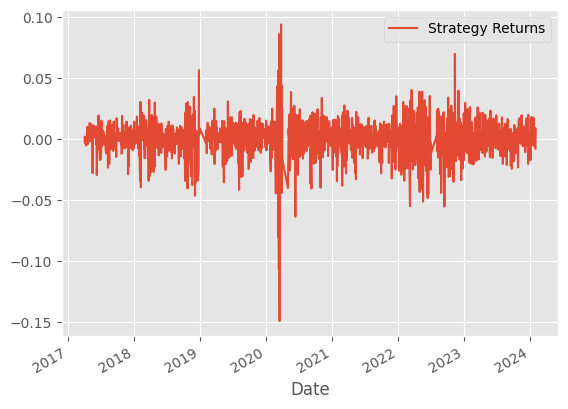

In [196]:
#showcase Max Sharpy ratio of sum of daily weighted returns over period of time
portfolio_df.plot()

## Visualize the Portfolio returns and compare it to that of the S&P 500 returns

In [199]:
spy = yf.download(tickers = "SPY",start = "2016-01-01",end = dt.date.today())
spy_return = np.log(spy[["Adj Close"]]).diff().dropna().rename({"Adj Close": "S&P500_returns"},axis = 1)
spy_return

[*********************100%%**********************]  1 of 1 completed


S&P500_returns
Date                      
2016-01-05        0.001690
2016-01-06       -0.012695
2016-01-07       -0.024284
2016-01-08       -0.011038
2016-01-11        0.000990
...                    ...
2024-07-17       -0.014120
2024-07-18       -0.007715
2024-07-19       -0.006663
2024-07-22        0.010257
2024-07-23       -0.001570

[2151 rows x 1 columns]

In [218]:
portfolio_df = portfolio_df.merge(spy_return,left_index = True,right_index = True)
portfolio_df

Strategy Returns  S&P500_returns
Date                                        
2017-04-03          0.001517       -0.001741
2017-04-04          0.002060        0.000637
2017-04-05         -0.004659       -0.002977
2017-04-06          0.001094        0.002807
2017-04-07          0.001180       -0.001020
...                      ...             ...
2024-01-24          0.009168        0.001093
2024-01-25          0.004175        0.005424
2024-01-26         -0.005010       -0.001271
2024-01-29          0.011644        0.007888
2024-01-30         -0.008576       -0.000774

[1656 rows x 2 columns]

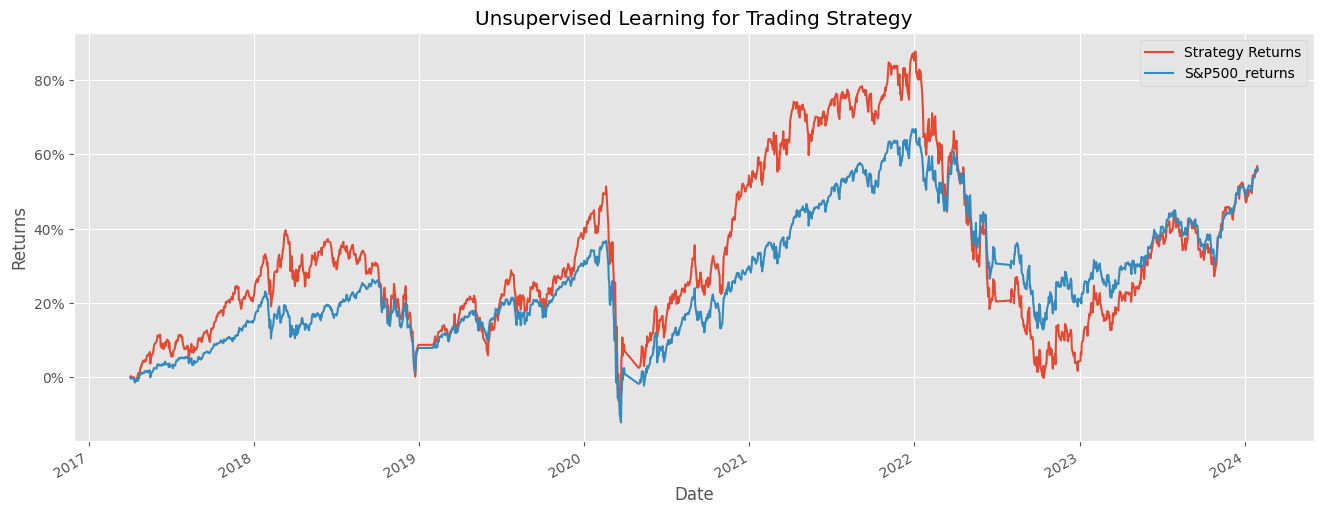

In [219]:
#Time to compare them visually
import matplotlib.ticker as mtick
plt.style.use("ggplot")
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:"2024-01-30"].plot(figsize = (16,6))
plt.title("Unsupervised Learning for Trading Strategy")
plt.ylabel("Returns")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.show()